In this notebook, we modify the previous 10-nouns-testing notebook (which contains a working prototype editor network).

We are going to edit it to take an additional input of a specific intervention layer, and then limit its editing outputs to that layer.

Then, we will augment each editor-instruction with a new field, "output_layer" in 0 ... 12

Speculatively, maybe we'll be able to reconstruct some kind of actual circuit from the result?

Note 1: the understanding we have from the IOI task is still quite poor!
In particular, there is little in the way of logic of why the model expects these names to be relevant, what is triggering the heads, etc.

Note 2: I still feel like I don't have quite the exact right modeling shape. The reason is that our network, here, is capable of outputting changes at different layers that are going to be inconsistent with one another, and not form a real circuit.
What would it mean to have an output form that implies some notion of consistency between the edits across multiple layers?
Is there some kind of tensor-component output we could give which would train the model to develop this kind of inner-consistency?

Perhaps that boils down to a kind of sequential-reconstruction loss, where our model, instead of trying to force the end-output, is also trying to generate the changes in the specific next layer each iterations.

The problem with this is, perhaps we don't quite want everything drawn down to exact-attribution levels, since some features will sort-of-sponetaneously emerge or be formed out of collections of others which are too noisy to chase back down. We want attribution where it is clear, and creation where it is unclear.

This perhaps does imply a kind of joint objective, where we could try to do a tracing-step of checking which edits imply each other, and then form circuits on that basis using the known neural-networks machinery. Hmm....

One alternative idea:

-proceed iteratively upward through the model;

-use a penalization that encourages use of a joint-combo of explained - and - unexplained circuitry

-So, in layer l, a feature can be directly edited-in, at cost of its L-2 norm: C || I ||_2
-But we give a discount, to the extent that the edit is already implied by what happened in the previous layer:
    so, what we ACTUALLY do, is compute:
    forward(l-1) to get 'newstate' 
    Then, we predict the 'net-edit-vector' in layer l.
    The result will be set to 'oldstate' + 'net-edit-vector', so the 'unexplained' component-penalty is therefore
    ||'oldstate' + 'net-edit-vector' - 'newstate' ||_2
    
    This can all be done in the same pass, so it does not particularly cost us computational overhead.

-This encourages the editor model to form "circuits" wherein the impact of its edits can be causally traced, needing as few new features as possible to be added-in throughout the process. Indeed, given proper tuning, we should be able to encourage the model to "work backwards." 

-But, I now have serious doubts that this is going to work anywhere near as well the current version, where I simply set

    'newstate' += 'net-edit-vector

    which conveniently allows gradients to pass through at every layer. Which is a huge learning advantage! So, e.g., the model can directly learn to focus on layer 0 rather than having to learn layer zero...

    I suppose what my current method mostly does not do, is conveniently offer tracking through the rest of the pathway after the initial edit. 
    How to do that in a sensible way, I wonder? 

    Oh: I could use a reconstruction objective on the consequent changes, where I try to predict the results of the edit, the whole way thru?

    Hmm...could reconstruct either the consequences of the context change, or the consequences of the edit. 
    Constructing the consequences of the edit is sensible!

    I also wonder: is there a sort of diffusion-objective I could possibly give here? What's the equivalent of noise-corruption - that we allow greater injections of new signals along the circuit path? Or that we require our dataset-predictions to hold over a set of many context-datapoints, as we resample different contexts?

    I could, in parallel: 
    to have edit-heads, and prediction-heads for every layer and token-position, trying to anticipate the edit's results... the prediction-heads could then just lag the editor-head, basically be a descriptor/predictor of what the editor's consequences will be.

    Or they could just try to describe the inner states from the run of the soft-label modification-run, rather than the editor's circuitry'. That's in some sense more efficient, data-wise.


In [1]:
stopping_index=8
additional_tokens =15
#edit_layer = 4 #this is currently detached from everything
#edit_scale = 1/10 
num_editing_heads = 384 #more seems to be better for this
max_grad_clip = 0.1 #usually this is 1, but I'm going to be more aggressive here and see if I can find a point that works

In [3]:
# Trying out the editor hypernetwork on the dune dataset
import wandb

wandb.init(
    # set the wandb project where this run will be logged
    project="hypernetworks",
    config={"targetmodel": "gpt2", "editormodel": "gpt2"},
)
# Copy this below where needed!
# run.log_model(path="<path-to-model>", name="<name>")

# wandb.log({"acc": acc, "loss": loss})

# wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michaelbsklar (michaelsklar). Use `wandb login --relogin` to force relogin


In [4]:
CUDA_LAUNCH_BLOCKING=1

In [5]:
import transformers
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config, GPT2Model
from transformers.models.gpt2.modeling_gpt2 import GPT2Attention
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import transformers
from tqdm import tqdm
import pandas as pd
import yaml
import contextlib
import os

In [6]:
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [7]:
# Set torch default device
torch.set_default_device("cuda")

In [8]:
tokenizer = transformers.GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

In [9]:
def f_data_to_soft_labels(data, stop_editing_index=8):
    # previous code: we now 
    #Replace cat with dog tokens as was done in the data generation step
    #data[:, :stop_editing_index][data[:, :stop_editing_index] == 3797] = 3290

    # Will search global namespace for model, then use it to predict logits
    with torch.no_grad():
        logits = model(data).logits
        predictions = torch.nn.functional.softmax(logits, dim=2)
        return predictions[:, stop_editing_index:, :].reshape(-1, 50257)
    
def edit_add_simple(module, input, output, perturbation_vector):
    #we using a scaling factor; the edit will be in this proportion to the vector norm
    relative_edit_magnitude = 1/10
    scale_factor = relative_edit_magnitude*torch.norm(output[0],
        dim=2,keepdim=True)
    #Note: implicitly assumes that the perturbation will be sparse, in a single position in each batch example
    output[0][:] = output[0] + (perturbation_vector/torch.norm(perturbation_vector,dim=[1,2],keepdim=True))*scale_factor

def edit_add_simple_embedding(module, input, output, perturbation_vector):
    #unscaled!
    output[:] = output + perturbation_vector

In [10]:
def add_cross_attention_to_layer(block, config):
    block.crossattention = GPT2Attention(config, is_cross_attention=True)
    block.ln_cross_attn = nn.LayerNorm(
        normalized_shape=768, eps=config.layer_norm_epsilon
    )
    original_query_weights = block.attn.c_attn.weight[:, :768]
    original_keys_values = block.attn.c_attn.weight[:, 768:]
    original_query_bias = block.attn.c_attn.bias[:768]
    original_keys_values_bias = block.attn.c_attn.bias[768:]
    with torch.no_grad():
        # Initialize the new layer with these parameters
        block.crossattention.q_attn.weight = nn.Parameter(original_query_weights)
        block.crossattention.q_attn.bias = nn.Parameter(original_query_bias)
        block.crossattention.c_attn.weight = nn.Parameter(original_keys_values)
        block.crossattention.c_attn.bias = nn.Parameter(original_keys_values_bias)
    return

Now, we stick on the "reverse attention" module at the end!
This is a customized attention head that reads from the editor model, and writes to the target model's activations

In [11]:
class Editor_Attention(nn.Module):
    def __init__(self, config):
        super().__init__()

        #Controls whether the head will do a global softmax in all positions & layers
        #If True, the attn is global and will sum to 1
        #If False, the attn is a logistic fxn independently for every layer & token
        #I suspect we will also want to penalize the intervention norm
        self.global_softmax = config.global_softmax
        self.num_editing_heads = config.num_editing_heads #should default to 1, but we're going to test adding more
        if config.hidden_size % self.num_editing_heads != 0:
            print("Error: config hidden size is not divisible by num_editing_heads")
        self.head_dim = config.hidden_size // self.num_editing_heads
        self.embed_dim = config.hidden_size

        max_positions = config.max_position_embeddings
        self.register_buffer(
            "bias",
            torch.tril(
                torch.ones((max_positions, max_positions), dtype=torch.bool)
            ).view(1, 1, max_positions, max_positions),
            persistent=False,
        )
        self.register_buffer("masked_bias", torch.tensor(-1e4), persistent=False)

        # We compute Q and K as a single nn.linear; but will later break apart into subcomponents
        self.q_attn = nn.Linear(self.embed_dim, self.embed_dim)
        self.k_attn = nn.Linear(self.embed_dim, self.embed_dim)
        self.v_attn = nn.Linear(self.embed_dim, self.embed_dim)
        self.out_proj = nn.Linear(self.embed_dim, self.embed_dim)  # newly added!
        
    def _split_heads(self, x):
        """Split the last dimension into (num_heads, head_dim)."""
        new_shape = x.size()[:-1] + (self.num_editing_heads, self.head_dim)
        return x.view(*new_shape)
    
    def _new_reverse_attn(self, query, key, value, attention_mask=None, head_mask=None):
        # Assume that we are doing softmax attention

        # Project and split the query, key, value tensors
        split_query = self._split_heads(self.q_attn(query))
        split_key = self._split_heads(self.k_attn(key))
        split_value = self._split_heads(self.v_attn(value))
        
        if split_query.dim() != 4:
            print("Error: Expected query to be 4D tensor, but got something else!")
        if split_key.dim() != 3:
            print("Error: Expected key to be 3D tensor, but got something else!")
        if split_value.dim() != 3:
            print("Error: Expected value to be 3D tensor, but got something else!")

        # Query should be shaped as (batch_index, sequence_index, head_index, head_dim)
        # Key and value should be shaped as (batch_index, head_index, head_dim)
    
        KQ_weights = torch.matmul(split_query.permute(0,2,1,3),split_key.unsqueeze(-1)).squeeze(-1)

        # Then we take the softmax within the positional divisions
        softmaxed_weights = nn.functional.softmax(KQ_weights, dim=-1)
        
        # Adjusting value selection for head dimension
        attn_output = torch.matmul(softmaxed_weights.unsqueeze(-1), split_value.unsqueeze(-2))

        #combine heads: change 50, 8, 104, 96 to 50, 104, 768
        #first, permute
        attn_output = attn_output.permute(0,2,1,3)
        #combin heads x head_dims
        attn_output = attn_output.reshape(-1,attn_output.size(1),attn_output.size(2)*attn_output.size(3))
        # now project back
        projected_output = self.out_proj(attn_output)
    
        return projected_output, softmaxed_weights

    def _reverse_attn(self, query, key, value, attention_mask=None, head_mask=None):
        # The softmax is global over ALL attentions if num_editing_heads = 1
        # We also only use reverse attention from the final token of the edit sequence (last position in key)

        # Awkward error handling, because apparently, it seems like if the batch size is 1,
        # we wind up with a 3D tensor, not a 4D tensor??? Should trace this issue back!
        
        # if self.global_softmax:
        #     if key.dim() == 4:
        #         K_reduced = key[
        #             :, :, -1, :
        #         ]  # R# Check: that the second dimension of K is only a single element when we have batching
        #         # ^I believe this line is selecting only the last layer for editing output? check this!
        #         KQ_weights = torch.bmm(K_reduced, query.transpose(1, 2))
        #         #Then we take the softmax within the positional divisions
        #         softmaxed_weights = nn.functional.softmax(KQ_weights, dim=2)
        #         attn_output = torch.bmm(
        #             softmaxed_weights.transpose(1, 2), value[:, :, -1, :]
        #         )

        #     if key.dim() == 3:
        #         QK_weights = torch.matmul(query, key.transpose(-1, -2))
        #         softmaxed_weights = nn.functional.softmax(QK_weights, dim=1)
        #         attn_output = torch.matmul(softmaxed_weights, value)

        #     return attn_output, softmaxed_weights

        if self.global_softmax == False:
            if key.dim() == 4:
                K_reduced = key[
                    :, :, -1, :
                ]  # R# Check: that the second dimension of K is only a single element when we have batching
                KQ_weights = torch.bmm(K_reduced, query.transpose(1, 2))
                logistic_weights = torch.atan(KQ_weights)
                attn_output = torch.bmm(
                    logistic_weights.transpose(1, 2), value[:, :, -1, :]
                )

            if key.dim() == 3:
                QK_weights = torch.matmul(query, key.transpose(-1, -2))
                logistic_weights = torch.atan(QK_weights)
                attn_output = torch.matmul(logistic_weights, value)

            return attn_output, logistic_weights


    def forward(
        self,
        editor_hidden_states,
        target_hidden_states,
        attention_mask=None,
        output_attentions=False,
    ):

        # Here, the query is the target hidden encoder, the key is the editor, and the value is the editor
        query = self.q_attn(target_hidden_states)
        if editor_hidden_states.dim() == 3:
            key = self.k_attn(
                # I don't quite understand why sometimes editor_hidden_states is 4 dimensional, sometimes 3
                #seems like it's sometimes 20, 1, 4, 768 and sometimes 20, 4, 768. what gives?
                editor_hidden_states[:, -1, :]
            )  # Pull only the final token position
            value = self.v_attn(
                # [:, 0, :1, :]
                editor_hidden_states[:, -1, :]
            )  # Pull only the final token position

        if editor_hidden_states.dim() == 4:
            key = self.k_attn(
                editor_hidden_states[:, 0, -1, :]
            )  # Pull only the final token position
            value = self.v_attn(
                # [:, 0, :1, :]
                editor_hidden_states[:, 0, -1, :]
            )  # Pull only the final token position

        attn_output, attn_weights = self._new_reverse_attn(query, key, value)

        if output_attentions:
            return attn_output, attn_weights
        else:
            return attn_output

In [12]:
import types
from typing import Optional, Tuple, Union


def new_forward(
    self,
    input_ids: Optional[torch.LongTensor] = None,
    past_key_values: Optional[Tuple[Tuple[torch.Tensor]]] = None,
    attention_mask: Optional[torch.FloatTensor] = None,
    token_type_ids: Optional[torch.LongTensor] = None,
    position_ids: Optional[torch.LongTensor] = None,
    head_mask: Optional[torch.FloatTensor] = None,
    inputs_embeds: Optional[torch.FloatTensor] = None,
    encoder_hidden_states: Optional[torch.Tensor] = None,
    encoder_attention_mask: Optional[torch.FloatTensor] = None,
    # labels: Optional[torch.LongTensor] = None,
    use_cache: Optional[bool] = None,
    output_attentions: Optional[bool] = None,
    output_hidden_states: Optional[bool] = None,
    return_dict: Optional[bool] = None,
) -> Union[Tuple]:
    r"""
    labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
        Labels for language modeling. Note that the labels **are shifted** inside the model, i.e. you can set
        `labels = input_ids` Indices are selected in `[-100, 0, ..., config.vocab_size]` All labels set to `-100`
        are ignored (masked), the loss is only computed for labels in `[0, ..., config.vocab_size]`
    """

    transformer_outputs = self.transformer(
        input_ids,
        past_key_values=past_key_values,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids,
        position_ids=position_ids,
        head_mask=head_mask,
        inputs_embeds=inputs_embeds,
        encoder_hidden_states=encoder_hidden_states,
        encoder_attention_mask=encoder_attention_mask,
        use_cache=use_cache,
        output_attentions=output_attentions,
        output_hidden_states=output_hidden_states,
        return_dict=return_dict,
    )
    hidden_states = transformer_outputs[0]

    # Set device for model parallelism
    if self.model_parallel:
        torch.cuda.set_device(self.transformer.first_device)
        hidden_states = hidden_states.to(self.lm_head.weight.device)

    # lm_logits = self.lm_head(hidden_states)
    reverse_attention_output = self.lm_head(
        hidden_states, encoder_hidden_states, output_attentions=output_attentions
    )

    return reverse_attention_output

In [13]:
def replace_linear_final_layer_with_bespoke_reverse_attention(model):
    model.lm_head = Editor_Attention(config=model.config)
    model.forward = new_forward.__get__(model, GPT2LMHeadModel)
    return

In [14]:
@contextlib.contextmanager
def add_fwd_hooks(module_hooks):
    """
    Context manager for temporarily adding forward hooks to a model.

    Parameters
    ----------
    module_hooks
        A list of pairs: (module, fnc) The function will be registered as a
            forward hook on the module
    """
    try:
        handles = []
        for mod, hk in module_hooks:
            handles.append(mod.register_forward_hook(hk))
        yield
    finally:
        for h in handles:
            h.remove()

In [15]:
def assign_layer_indices(model):
    """
    Assigns a custom attribute 'layer_index' to each transformer layer in the GPT-2 model.
    This function iterates over the transformer blocks and assigns an index to each.
    """
    model.transformer.wte.layer_index = 0
    for i, layer in enumerate(model.transformer.h):
        layer.layer_index = i + 1


# Usage:
# assign_layer_indices(target_model)

In [16]:
class EditorHypernetwork(nn.Module):
    # Separating the editor config file, from its base model's configurations
    def __init__(self, 
        editor_yaml_file_path="config/editor_omniscient.yaml", 
        global_softmax=False,
        num_editing_heads=32,
        use_layerwise_embeddings=True,
        edit_dampening_factor=.001,#tuning parameter to help the edits not be initialized too large
        kill_token_zero = False #multiplies edits to token pos zero by zero
        ):

        super().__init__()

        # Construct Editor Model
        # Load the configuration from the YAML file
        # with open(editor_yaml_file_path, 'r') as file:
        #     self.config = yaml.safe_load(file)
        self.editor_model = GPT2LMHeadModel.from_pretrained(
            "gpt2"
        ).cuda().eval()  # have recently added .cuda() so it uses the gpu

        # Add cross-attention to each layer
        self.editor_model.config.add_cross_attention = True
        self.editor_model.config.global_softmax = global_softmax
        self.editor_model.config.num_editing_heads = num_editing_heads
        self.editor_model.config.kill_token_zero = kill_token_zero
        
        for i in range(12):
            add_cross_attention_to_layer(
                self.editor_model.transformer.h[i], self.editor_model.config
            )
        # Replace the final linear layer with special reverse attention output
        self.editor_model.lm_head = Editor_Attention(config=self.editor_model.config)
        self.editor_model.forward = new_forward.__get__(
            self.editor_model, GPT2LMHeadModel
        )
        self.editor_model.cuda()

        # Construct Target Model
        self.target_model = transformers.AutoModelForCausalLM.from_pretrained(
            "gpt2"
        ).cuda().eval()
        for param in self.target_model.parameters():
            param.requires_grad = False
        assign_layer_indices(self.target_model)

        self.target_model.cuda()

        # Add module for layerwise embeddings
        if use_layerwise_embeddings:
            self.use_layerwise_embeddings = True
            self.layerwise_embeddings = torch.randn(13, 768, requires_grad=True).cuda()
        else:
            self.use_layerwise_embeddings = False
            self.layerwise_embeddings = 0

        self.edit_dampening_factor = edit_dampening_factor

        self.residual_cache = None
        self.opt = None
        self.lossfn = None
        self.lam = None
        self.penalty_loss= None
        self.training_loss = None

    # Gets the hidden states from the target model, if necessary
    def run_target_model_for_encoded_hidden_states(self, target_ids):
        with torch.no_grad():
            outputs = self.target_model(target_ids, output_hidden_states=True)
            hidden_states = outputs.hidden_states
            return hidden_states

    def forward(
        self,
        editor_input_ids,
        target_input_ids,
        target_hidden_states=None,
        output_target_hidden_states=False,
        output_edited_hidden_states=False,
        output_edit_vectors=False,
        output_editor_attention=False,
        stop_editing_index=None,
        batch_edit_vectors=None,
    ):

        # Run target model for encoded hidden states
        if target_hidden_states is None:
            target_hidden_states = torch.stack(
                self.run_target_model_for_encoded_hidden_states(
                    target_input_ids.to("cuda")
                ), #seems to break while we are passing thru batch_size=1; the last (12th =) has different dimensions
                dim=2,
            )
        # dimensions of target_hidden_states:
        # batch_size, token_sequence_length, num_layers = 13, resid_width = 768

        # If we are stopping editing at stop_editing_index, then we eliminate target_hidden_states beyond that index
        if stop_editing_index is not None:
            target_hidden_states = target_hidden_states[
                :, :stop_editing_index, :, :
            ].clone()

        # Normalize along the last dimension
        normalization_factors = target_hidden_states.norm(dim=-1, keepdim=True)
        target_hidden_states = target_hidden_states / normalization_factors

        # Error catching:
        if batch_edit_vectors is not None:
            if output_edit_vectors or output_editor_attention:
                return "Error: Inputting your own batch_edit_vectors means the model does not construct the outputs you are requesting"

        # Run editor model, get edit vectors
        if batch_edit_vectors is None:
            if self.use_layerwise_embeddings:
                # Now, add in the layerwise embeddings
                embedded_hidden_states = target_hidden_states + self.layerwise_embeddings[None, None, :, :]

                collapsed_target_hidden_states = embedded_hidden_states.reshape(
                    target_hidden_states.shape[0],
                    target_hidden_states.shape[1] * target_hidden_states.shape[2],
                    target_hidden_states.shape[3],
                )
            else:
                collapsed_target_hidden_states = target_hidden_states.reshape(
                    target_hidden_states.shape[0],
                    target_hidden_states.shape[1] * target_hidden_states.shape[2],
                    target_hidden_states.shape[3],
                )
            
            editor_output = self.editor_model(
                editor_input_ids.to("cuda"),
                encoder_hidden_states=collapsed_target_hidden_states,
                output_attentions=output_editor_attention,
            )
            # Multiply the outputs by normalization factors
            if output_editor_attention:
                temp_edit_vectors = editor_output[0]
                # Might want to reshape this too but whatever
                batch_editor_attention = editor_output[1]
            else:
                temp_edit_vectors = editor_output
            
            #Renormalize to the scale of the target hidden states
            #and reshape to proper dimensions
            batch_edit_vectors = self.edit_dampening_factor * normalization_factors * temp_edit_vectors.reshape(
                    temp_edit_vectors.shape[0], stop_editing_index, 13, 768
                )
            
        # If we are stopping editing at stop_editing_index,
        # this pads batch_edit_vectors with 0's to the right of the edited positions
        if stop_editing_index is not None:
            batch_edit_vectors = torch.cat(
                (
                    batch_edit_vectors,
                    torch.zeros(
                        batch_edit_vectors.shape[0],
                        target_input_ids.shape[1] - stop_editing_index,
                        13,
                        768,
                    ),
                ),
                dim=1,
            )

        # Run target model with edit vectors. This adds the edit vectors to the given hidden state at the specified batch index, position, and layer
        def edit_add(module, input, output):
            layer_index = module.layer_index
            output[0][:] = output[0] + batch_edit_vectors[:, :, layer_index, :]
            if self.editor_model.config.kill_token_zero == True:
                output[0][:, 0, :] = 0

        def embedding_edit_add(module, input, output):
            output[:] = output + batch_edit_vectors[:, :, 0, :]
            if self.editor_model.config.kill_token_zero == True:
                output[:, 0, :] = 0

        # Now editing the target model
        hooks1 = [(self.target_model.transformer.wte, embedding_edit_add)]
        hooks2 = [(self.target_model.transformer.h[L], edit_add) for L in range(12)]
        hooks = hooks1 + hooks2
        with add_fwd_hooks(hooks):
            # THIS IS THE LINE WHERE THE MODEL IS CALLED (AND THE EDITOR IS CALLED AT
            # THE END OF `layer` AS A SIDE EFFECT)
            target_result = self.target_model(
                target_input_ids.to("cuda"),
                output_hidden_states=output_edited_hidden_states,
            )

        logits = target_result.logits

        output = {}
        output["logits"] = logits
        if output_target_hidden_states:
            output["target_hidden_states"] = (
                target_hidden_states * normalization_factors
            )
        if output_edited_hidden_states:
            output["edited_hidden_states"] = target_result.hidden_states
        if output_edit_vectors:
            output["edit_vectors"] = batch_edit_vectors
        if output_editor_attention:
            output["editor_attention"] = batch_editor_attention
        return output

    # Generate text using the target model, with a new edit application at every step.
    # This is a very slow way to generate text.
    # If you only want to edit first k tokens, use the forward pass instead with stop_editing_index = k
    def generate_with_repeated_edits(
        self, editor_input_ids, target_input_ids, max_length=10
    ):
        """Generate text using the target model, with a new edit application at every step."""
        generated_ids = target_input_ids
        for _ in range(max_length):
            # Use the target model's forward pass, which applies cached residuals
            outputs = self.forward(
                editor_input_ids=editor_input_ids.to("cuda"),
                target_input_ids=generated_ids.to("cuda"),
            )
            # Get the next token here (simplified for brevity)
            next_token_id = outputs["logits"][:, -1, :].argmax(dim=-1)
            generated_ids = torch.cat(
                (generated_ids, next_token_id.unsqueeze(-1)), dim=1
            )
        return generated_ids

    def evaluate_KL_test_loss_nogradient(self,dataloader, f_data_to_soft_labels = None, stop_editing_index=8):
        with torch.no_grad():
            sum_weighted_losses = 0.0
            total_samples = 0
            for batch in dataloader:
                current_batch_size = len(batch["editor_sequence"])
                self.editor_inputs = batch["editor_sequence"].squeeze(1)
                self.target_inputs = batch["target_tokens"].squeeze(1)
                self.prediction = self.forward( #check the batch size
                    self.editor_inputs,
                    self.target_inputs,
                    stop_editing_index=stop_editing_index
                )
                log_prob_predictions = torch.nn.functional.log_softmax(
                    self.prediction["logits"][
                        :, stop_editing_index:, :
                    ].reshape(-1, 50257),
                    dim=1,
                )
                # Now we must compute the soft labels!
                soft_labels = f_data_to_soft_labels(
                    torch.tensor(
                        #dataframe["test"]["edit_result_ids"][i : i + batch_size]
                        batch["result_text"]
                    ),
                    stop_editing_index,
                )
                self.loss = torch.nn.functional.kl_div(log_prob_predictions, soft_labels, reduction = 'batchmean')
                # Weight the loss by current batch size and update the sum of weighted losses
                sum_weighted_losses += self.loss.item() * current_batch_size
                total_samples += current_batch_size
            weighted_average_loss = sum_weighted_losses / total_samples
        return weighted_average_loss

        
    # def evaluate_crossentropy_test_loss_nogradient(self, 
    #                     dataloader, 
    #                     stop_editing_index= 8, 
    #                     batch_size = 50):
    #     with torch.no_grad():
    #         sum_weighted_losses = 0.0
    #         total_samples = 0
    #         for batch in dataloader:
    #             current_batch_size = len(batch['editor_sequence'])
    #             # self.editor_inputs = torch.tensor(
    #             #     dataframe["test"]["edit_tokens"][i : i + batch_size]
    #             # ).squeeze(1)
    #             # self.target_inputs = torch.tensor(
    #             #     dataframe["test"]["target_tokens][i : i + batch_size]
    #             # ).squeeze(1)
    #             self.prediction = self.forward(batch["editor_sequence"],batch["target_tokens], stop_editing_index=stop_editing_index)
    #         #take only the final prediction!

    #             self.y = batch["result_text"]  # torch.tensor(dataframe["train"]["answer_tokens"][i : i + batch_size]).to("cuda")
    #             end_sequence_index = [len(x) - torch.sum(x==0) - 1 for x in batch["target_tokens]]
    #             indices = torch.stack(end_sequence_index).unsqueeze(-1).unsqueeze(-1).expand(-1,-1, 50257)
    #             self.loss = self.lossfn(
    #                 torch.gather(self.prediction["logits"],1,indices).squeeze(1),
    #                 self.y.reshape(-1))
    #             # Weight the loss by current batch size and update the sum of weighted losses
    #             sum_weighted_losses += self.loss.item() * current_batch_size
    #             total_samples += current_batch_size
    #         weighted_average_loss = sum_weighted_losses / total_samples
    #     return weighted_average_loss

    def train(
        self,
        train_loader,
        test_loader=None,
        stop_editing_index=8,
        epochs=1,
        KL_divergence_loss=False,
        lam = 0, #20000
        lam_testing_penalty = 0, #100000
        f_data_to_soft_labels=None,
    ):
        self.opt = optim.AdamW(self.parameters(), lr=1e-3, weight_decay=.02) #usually: lr = 5e-5. 1e-3 worked well!

        if KL_divergence_loss:
            self.lossfn = nn.KLDivLoss(reduction = 'batchmean')
        else:
            self.lossfn = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            # Create a tqdm progress bar
            with tqdm(
                total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}", unit="batch"
            ) as pbar:
                num_datapoints_in_epoch=0
                epoch_train_loss = 0
                epoch_gradient_norm = 0
                # Train loop
                
                for batch in train_loader: #not sure what this does for fractional batches. meh whatev
                    current_batch_size = len(batch["result_text"])
                    num_datapoints_in_epoch += current_batch_size
                    self.opt.zero_grad()
                    # self.editor_inputs = torch.tensor(
                    #     dataframe["train"]["edit_tokens"][i : i + batch_size]
                    # ).squeeze(1)
                    # self.target_inputs = torch.tensor(
                    #     dataframe["train"]["target_tokens][i : i + batch_size]
                    # ).squeeze(1)
                    self.prediction = self.forward(
                        batch["editor_sequence"],
                        batch["target_tokens"],
                        stop_editing_index=stop_editing_index,
                        output_target_hidden_states=True,
                        output_edited_hidden_states=True,
                        output_edit_vectors=True,
                    )

                    # Compute the penalty (edit size relative to the hidden state)
                    self.lam = lam
                    edit_ratio = self.prediction['edit_vectors'].norm(dim=-1)[:,:stop_editing_index,:]/self.prediction['target_hidden_states'].norm(dim=-1)
                    self.per_datapoint_penalty_loss = self.lam * torch.sum(edit_ratio,dim=[1,2])
                    self.penalty_loss = torch.mean(self.per_datapoint_penalty_loss)
                    # Compute the data loss

                    # if KL_divergence_loss:
                    #     log_prob_predictions = torch.nn.functional.log_softmax(
                    #         self.prediction["logits"][:, stop_editing_index:, :
                    #         ].reshape(-1, 50257),
                    #         dim=1,
                    #         )
                    #     # Now we must compute the soft labels! This is outsourced to the user-provided function, teacher_model
                    #     soft_labels = f_data_to_soft_labels(
                    #         torch.tensor(
                    #             dataframe["train"]["edit_result_ids"][i : i + batch_size]
                    #             ),stop_editing_index)
                    #     self.prediction_loss = self.lossfn(log_prob_predictions, soft_labels)
                    # else:
                    
                    # self.y = batch["result_text"]  # torch.tensor(dataframe["train"]["answer_tokens"][i : i + batch_size]).to("cuda")
                    # end_sequence_index = [len(x) - torch.sum(x==0) - 1 for x in batch["result_text"]]
                    # indices = torch.stack(end_sequence_index).unsqueeze(-1).unsqueeze(-1).expand(-1,-1, 50257)
                    # self.prediction_loss = self.lossfn(
                    #     torch.gather(self.prediction["logits"],1,indices).squeeze(1),
                    #     #self.prediction["logits"][:, end_sequence_index, :].reshape(-1, 50257),
                    #     #self.y.reshape(-1) #use this for coss-entropy
                    # )

                    if KL_divergence_loss:
                        log_prob_predictions = torch.nn.functional.log_softmax(
                            self.prediction["logits"][:, stop_editing_index:, :
                            ].reshape(-1, 50257),
                            dim=1,
                            )
                        # Now we must compute the soft labels! This is outsourced to the user-provided function, teacher_model
                        soft_labels = f_data_to_soft_labels(
                                batch["result_text"]
                                ,stop_editing_index)
                        self.prediction_loss = self.lossfn(log_prob_predictions, soft_labels)
                            
                    self.training_loss = self.prediction_loss + self.penalty_loss
                    self.training_loss.backward()
                    nn.utils.clip_grad_norm_(self.parameters(), max_grad_clip) #just implemented this! dunno if a cap of 1 to large, so I'm messing with reducing it
                    self.opt.step()

                    #metrics
                    epoch_train_loss += self.training_loss.item()*current_batch_size
                    gradients = [p.grad.view(-1) for p in self.parameters() if p.grad is not None]
                    all_gradients = torch.cat(gradients)
                    gradient_norm = torch.norm(all_gradients).item()
                    epoch_gradient_norm += gradient_norm*current_batch_size
                    wandb.log({"train_batch_total_loss": self.training_loss.item(),
                               "train_batch_prediction_loss": self.prediction_loss.item(),
                                "train_batch_penalty_loss": self.penalty_loss,
                                "train_batch_gradient_norm": gradient_norm,
                               })

                    # Update progress bar
                    pbar.update(batch_size)
                ####END TRAIN LOOP   
                #########################
            
                #epoch loss
                # epoch_test_prediction_loss = self.evaluate_crossentropy_test_loss_nogradient(
                #     test_loader,
                #     stop_editing_index, 
                #     batch_size
                # )
                if KL_divergence_loss:
                    epoch_test_prediction_loss = self.evaluate_KL_test_loss_nogradient(
                        dataloader=test_loader,
                        f_data_to_soft_labels= f_data_to_soft_labels, 
                        stop_editing_index=stop_editing_index, 
                    )
                
            
                # Calculate and accumulate gradient norm for logging
                gradients = [p.grad.view(-1) for p in self.parameters() if p.grad is not None]
                all_gradients = torch.cat(gradients)
                gradient_norm = torch.norm(all_gradients).item()
                epoch_gradient_norm += gradient_norm

                wandb.log({"epoch_train_total_loss": epoch_train_loss /num_datapoints_in_epoch,
                            "test_prediction_loss": epoch_test_prediction_loss,
                            "gradient_norm": epoch_gradient_norm /num_datapoints_in_epoch
                            })   

Next, let's design a dataset for the task: change "cat" to "dog"
Load file: cat_segments.json

In [17]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained("gpt2").cuda().eval()
#turn off gradients
for param in model.parameters():
    param.requires_grad = False
model.config.pad_token_id = model.config.eos_token_id

In [18]:
import os
import pandas as pd
from datasets import Dataset
from transformers import GPT2Tokenizer
from torch.utils.data import DataLoader
import torch
import random
#set random seed
random.seed(0)

replacement_nouns_list=[" mountain", " ocean", " chair", " computer", " flower", " bird", " city", " star", " bicycle", " cat"]
#tokenize the replacement nouns
replacement_nouns_tokens = [tokenizer.encode(noun, add_special_tokens=False) for noun in replacement_nouns_list]

# Assuming GPT2Tokenizer and Dataset are properly imported
def create_noun_dataset(data_dir):
    sentences = []
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    noun_list = []
    tokenized_noun_list = []
    for file_name in os.listdir(data_dir):
        if file_name.startswith("output_") and file_name.endswith(".txt"):
            noun = file_name.replace("output_", " ").replace(".txt", "")
            noun_list.append(noun.strip())
            tokenized_noun = tokenizer.encode(noun, add_special_tokens=False)
            tokenized_noun_list.append(tokenized_noun)
            with open(os.path.join(data_dir, file_name), 'r', encoding = 'utf-8') as f:
                for line in f:
                    sentence_text = line.strip()
                    tokenized = tokenizer(sentence_text, add_special_tokens=False)['input_ids']
                    # Check if the noun is in the first 8 tokens and occurs exactly once
                    noun_occurrences = sum(token == tokenized_noun[0] for token in tokenized[:stopping_index])
                    if noun_occurrences == 1:
                        #sample a random entry of replacement_nouns_list
                        replacement_token = random.choice(replacement_nouns_tokens)
                        # add replacement_nouns_token to 
                        combined_edit_tokens = [tokenized_noun, replacement_token]
                        # next, perform replacement of tokenized_noun with replacement_token
                        for i in range(stopping_index-len(tokenized_noun)):
                            if tokenized[i:(i+len(tokenized_noun))] == tokenized_noun:
                                replaced_tokens = tokenized[:stopping_index]
                                replaced_tokens[i:(i+len(tokenized_noun))] = replacement_token #this part will fail if replacement_token is not same exact length
                                replaced_tokens = torch.tensor(replaced_tokens).unsqueeze(0)
                                #generate 10 additional tokens from gpt2, starting from stopping_index
                                generated_tokens = model.generate(
                                    replaced_tokens, 
                                    max_length= stopping_index + additional_tokens, 
                                    pad_token_id= model.config.eos_token_id , 
                                    attention_mask=torch.ones_like(replaced_tokens), 
                                    num_return_sequences=1
                                ).cpu().numpy()
                                #make a copy
                                consistent_tokens = generated_tokens[0].copy()
                                consistent_tokens[i:(i+len(tokenized_noun))] = tokenized_noun
                                sentences.append({                            
                                    "target_tokens": consistent_tokens.tolist(), #tokenized[:stopping_index],
                                    "editor_sequence": combined_edit_tokens,
                                    "original_text": sentence_text,
                                    "result_text": generated_tokens[0].tolist(),
                                    "noun": noun.strip(),
                                })
                                break
    return(sentences, noun_list)


In [19]:
# Usage
data_dir = '10completions_data/'

#check if a file exists at savelocation. If so, load
if os.path.exists("dataset.pt"):
    dataset = torch.load("dataset.pt")
else:#save dataset
    sentences, noun_list = create_noun_dataset(data_dir)
    df = pd.DataFrame(sentences)
    for i in range(len(df["result_text"])):
        df["editor_sequence"][i] = df["editor_sequence"][i][0][0], df["editor_sequence"][i][1][0]
    dataset = Dataset.from_pandas(df)

    # Convert to a PyTorch dataset
    dataset.set_format(type='torch', columns=["target_tokens", 'editor_sequence', 'result_text'])
    torch.save(dataset,"dataset.pt")

In [20]:
dataset

Dataset({
    features: ['target_tokens', 'editor_sequence', 'original_text', 'result_text', 'noun'],
    num_rows: 7709
})

In [21]:
def collate_fn(batch):
    res = {}
    for k in batch[0].keys():
        els = [x[k] for x in batch]
        max_length = max(len(x) for x in els)
        # for x in els:
        #     x += [0] * (max_length - len(x))
        #res[k] = torch.cat([y , torch.zeros(max_length - len(x))],for y in els)
        #res[k]=torch.tensor([x + [0] * (max_length - len(x)) for x in els], dtype=torch.long)
        res[k]=torch.stack([ torch.cat((x.long(),torch.zeros((max_length - len(x))))) for x in els]).int()
    return res


In [22]:
dataset

Dataset({
    features: ['target_tokens', 'editor_sequence', 'original_text', 'result_text', 'noun'],
    num_rows: 7709
})

In [23]:
tokenizer.decode(dataset["target_tokens"][0]),tokenizer.decode(dataset["result_text"][0])

("In my closet, the shoe sits quietly, and I can't see the city. I can't see the city",
 "In my closet, the city sits quietly, and I can't see the city. I can't see the city")

In [24]:
test_ratio = .08
temp = dataset.train_test_split(test_size=test_ratio)
temp

DatasetDict({
    train: Dataset({
        features: ['target_tokens', 'editor_sequence', 'original_text', 'result_text', 'noun'],
        num_rows: 7092
    })
    test: Dataset({
        features: ['target_tokens', 'editor_sequence', 'original_text', 'result_text', 'noun'],
        num_rows: 617
    })
})

In [25]:
batch_size=150
data_loader = DataLoader(temp["train"], batch_size=batch_size, collate_fn = collate_fn)#batch_size, collate_fn=collate_fn)
test_data_loader = DataLoader(temp["test"], batch_size=batch_size, collate_fn = collate_fn)#batch_size, collate_fn=collate_fn)

# # Now you can iterate over data_loader in your training loop
# j=0
# for batch in data_loader:
#     j=j+1
# print(j)
# #Good! we have all the data now

In [26]:
dataset, data_loader.batch_size

(Dataset({
     features: ['target_tokens', 'editor_sequence', 'original_text', 'result_text', 'noun'],
     num_rows: 7709
 }),
 160)

In [27]:
for batch in data_loader:
    temp = batch
    break
temp.keys()

dict_keys(['target_tokens', 'editor_sequence', 'result_text'])

In [28]:
stop_editing_index = 8
hypernetwork = EditorHypernetwork(
    global_softmax=True, 
    edit_dampening_factor = 1/10000, #1/10000, 
    use_layerwise_embeddings=False,
)

In [29]:
for batch in data_loader:
    temp = batch
    break
# temp["result_text"]

In [30]:
hypernetwork.train(
    train_loader=data_loader,
    test_loader=test_data_loader,
    stop_editing_index=stop_editing_index,
    epochs=100,
    lam = 0,#20000
    lam_testing_penalty = 0,
    KL_divergence_loss=True,
    f_data_to_soft_labels=f_data_to_soft_labels
)

Epoch 1/100: 7200batch [01:13, 119.79batch/s]         /opt/conda/lib/python3.10/site-packages/torch/utils/_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
Epoch 1/100: 7200batch [01:16, 93.59batch/s] 
Epoch 2/100: 7200batch [01:17, 93.13batch/s]          
Epoch 3/100: 7200batch [01:17, 92.94batch/s]          
Epoch 4/100: 7200batch [01:17, 92.73batch/s]          
Epoch 5/100: 7200batch [01:17, 92.75batch/s]          
Epoch 6/100: 7200batch [01:17, 92.90batch/s]          
Epoch 7/100: 7200batch [01:17, 92.87batch/s]          
Epoch 8/100: 7200batch [01:17, 92.79batch/s]          
Epoch 9/100: 7200batch [01:17, 92.78batch/s]          
Epoch 10/100: 7200batch [01:17, 92.83batch/s]          
Epoch 11/100: 7200batch [01:17, 92.73batch/s]          
Epoch 12/100: 7200batch [01:17, 92.70batch/s]         

KeyboardInterrupt: 

Let's now look at some outputs!

In [31]:
for batch in data_loader:
    result = hypernetwork.forward(
        editor_input_ids=batch['editor_sequence'],
        target_input_ids=batch['result_text'],
        stop_editing_index=stop_editing_index,
        output_target_hidden_states=True,
        output_edited_hidden_states=True,
        output_edit_vectors=True,
        output_editor_attention=True,
    )
    break

OutOfMemoryError: CUDA out of memory. Tried to allocate 44.00 MiB. GPU 0 has a total capacity of 14.58 GiB of which 9.56 MiB is free. Including non-PyTorch memory, this process has 14.57 GiB memory in use. Of the allocated memory 14.12 GiB is allocated by PyTorch, and 324.00 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# hypernetwork.evaluate_KL_test_loss_nogradient(data_loader, f_data_to_soft_labels, stop_editing_index=stop_editing_index)

In [ ]:
#decoding the first element of batch
tokenizer.decode(batch["target_tokens"][0]), tokenizer.decode(batch["result_text"][0]), tokenizer.decode(batch["editor_sequence"][0][0]), tokenizer.decode(batch["editor_sequence"][0][1])

('In a shiny shoe box, new possibilities are being explored.\n\nThe city of San Francisco is home to the',
 'In a shiny city box, new possibilities are being explored.\n\nThe city of San Francisco is home to the',
 ' shoe',
 ' city')

In [ ]:
result["edit_vectors"].shape

torch.Size([160, 23, 13, 768])

In [ ]:
# test_output['edited_hidden_states'][0][0,7][0:10] - model(cat_example,output_hidden_states = True).hidden_states[0][0][7][0:10]

In [ ]:
# edit_embedding[0:10]
result['editor_attention'].shape

torch.Size([160, 32, 104])

In [ ]:
# result

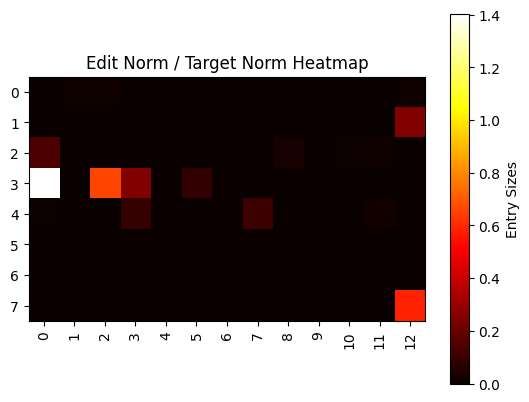

['In', ' a', ' shiny', ' city', ' box', ',', ' new', ' possibilities']


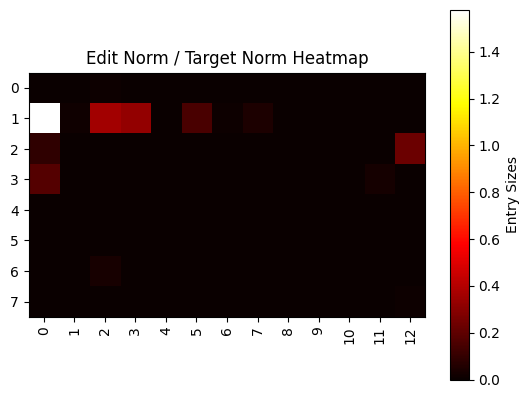

['The', ' flower', ' flowed', ' gently', ' through', ' the', ' valley', '.']


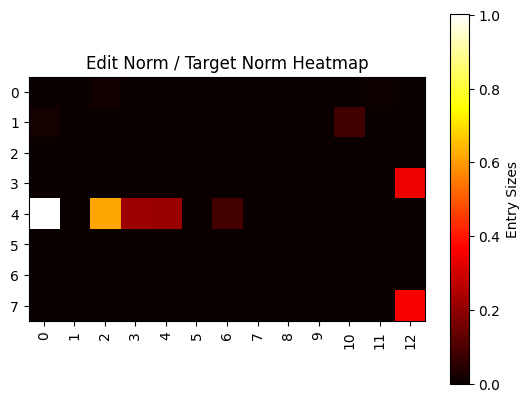

['B', 'ene', 'ath', ' the', ' computer', ',', ' the', ' children']


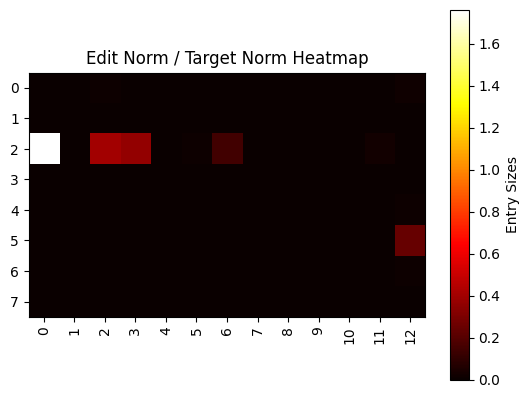

['On', ' the', ' flower', ',', ' she', ' whispered', ' a', ' secret']


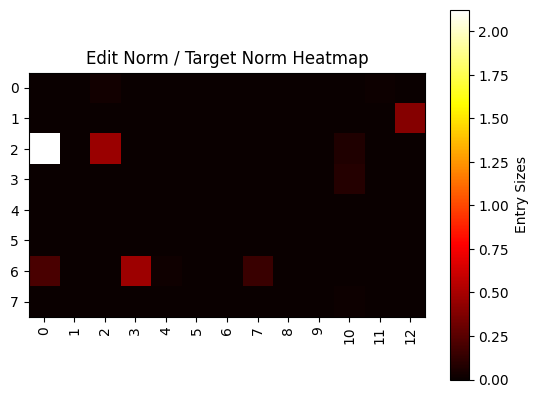

['In', ' the', ' morning', ' light', ',', ' the', ' star', ' gle']


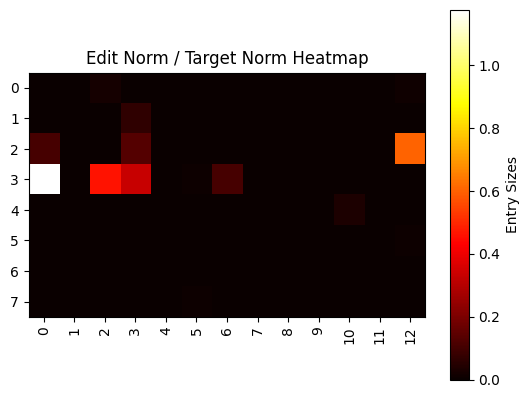

['In', ' my', ' favorite', ' ocean', ',', ' I', ' dance', ' grace']


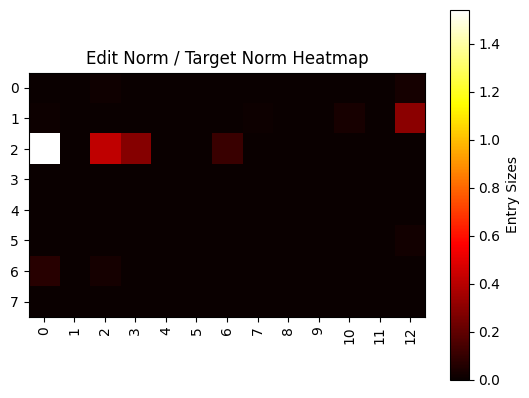

['A', ' delightful', ' bird', ' sat', ' on', ' the', ' table', ',']


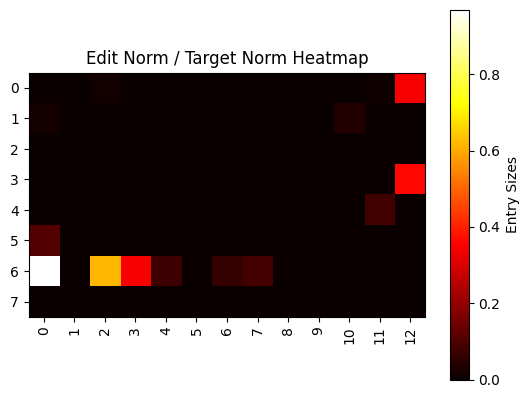

['B', 'ene', 'ath', ' the', ' old', ' oak', ' computer', ',']


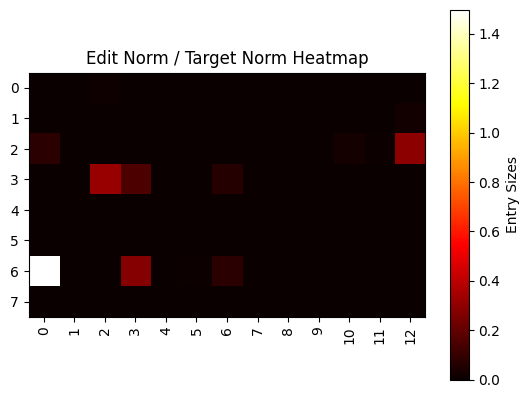

['In', ' the', ' Georgian', ' mansion', ',', ' the', ' bird', ' party']


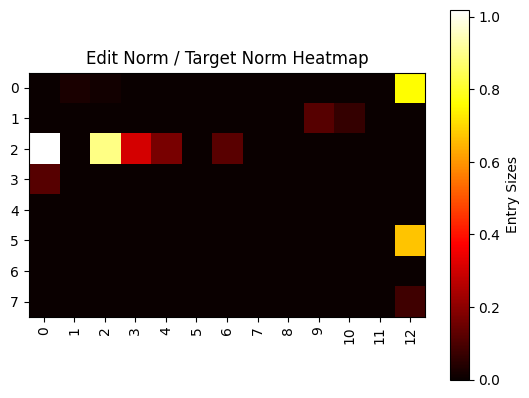

['A', ' faithful', ' bicycle', ' waits', ' for', ' his', ' master', '.']


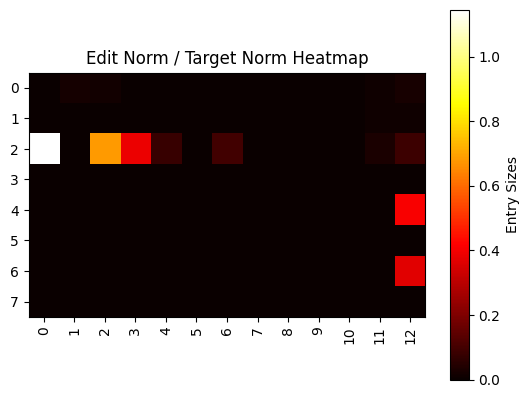

['On', ' the', ' computer', ',', ' she', ' heard', ' the', ' news']


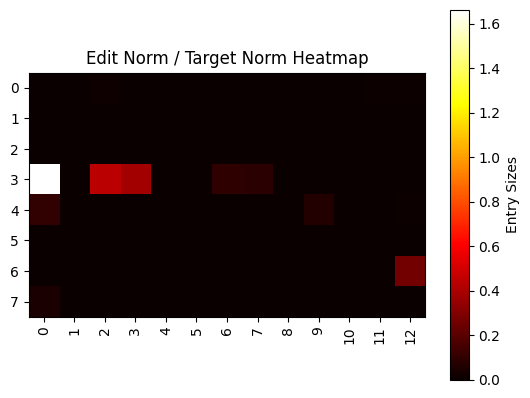

['Bat', 'hed', ' in', ' mountain', 'light', ',', ' the', ' night']


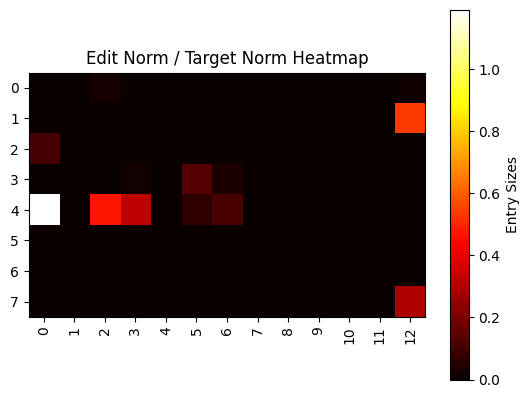

['In', ' a', ' shiny', ' red', ' ocean', ',', ' we', ' drove']


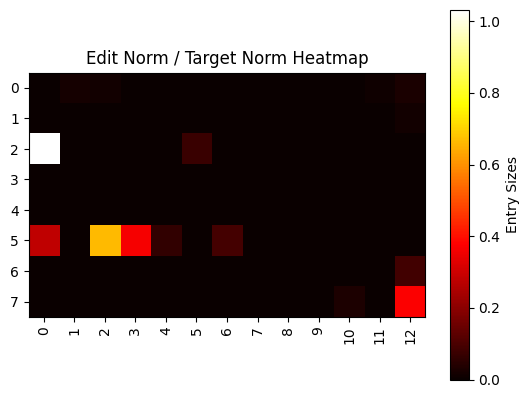

['In', ' the', ' sky', ',', ' the', ' computer', ' shone', ' brightly']


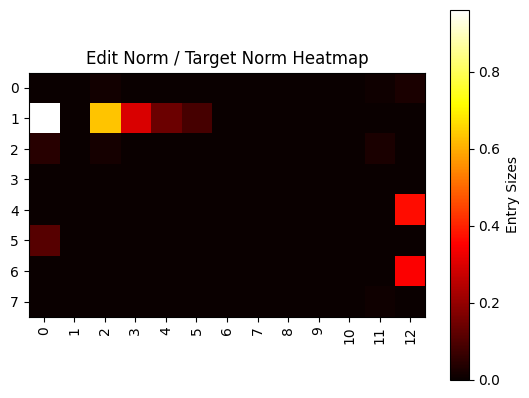

['The', ' computer', ' wound', ' grace', 'fully', ' through', ' the', ' valley']


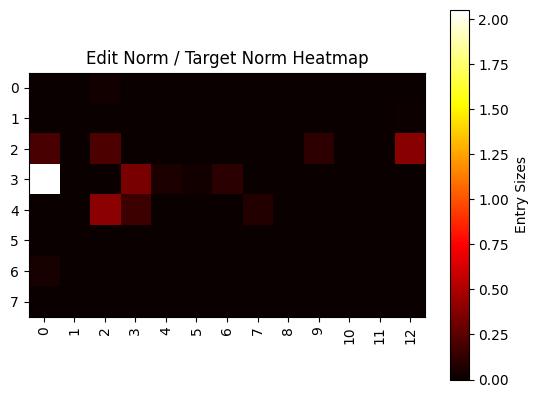

['On', ' the', ' elegant', ' star', ' rack', ',', ' lives', ' shine']


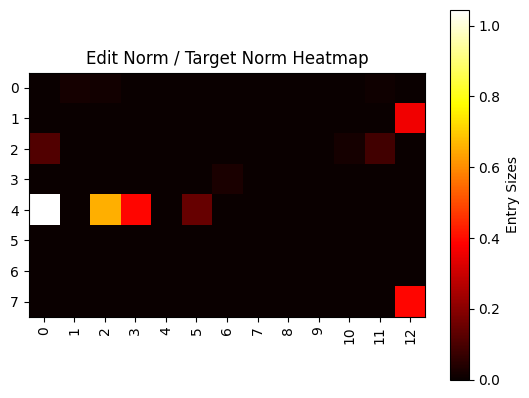

['In', ' her', ' sleek', ' red', ' computer', ',', ' she', ' sped']


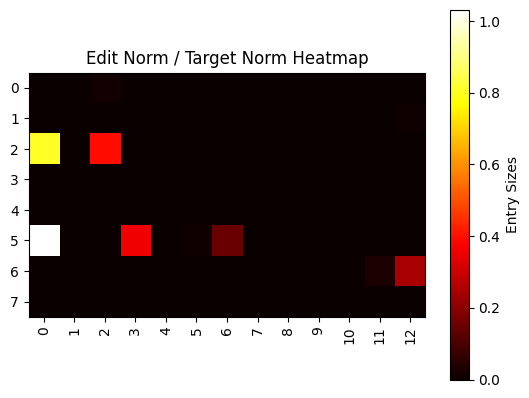

['In', ' the', ' city', ',', ' the', ' flower', ' sped', ' by']


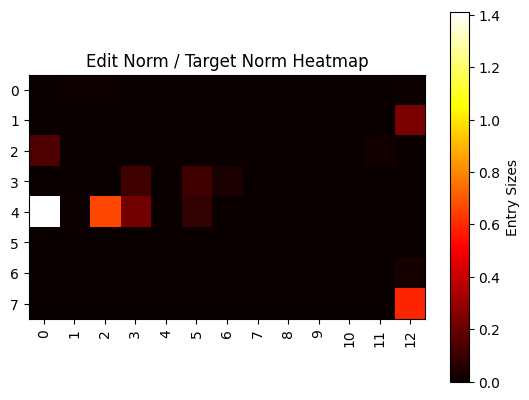

['In', ' a', ' shiny', ' red', ' city', ',', ' they', ' drove']


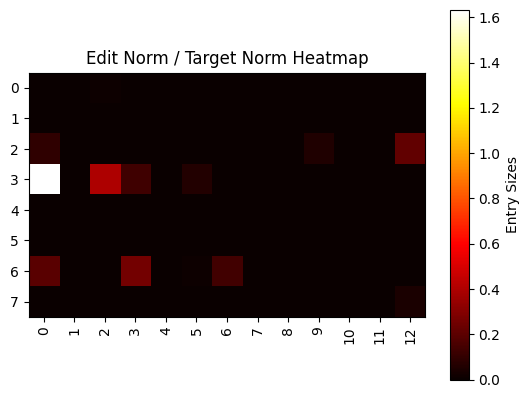

['In', ' the', ' crowded', ' street', ',', ' the', ' flower', ' sped']


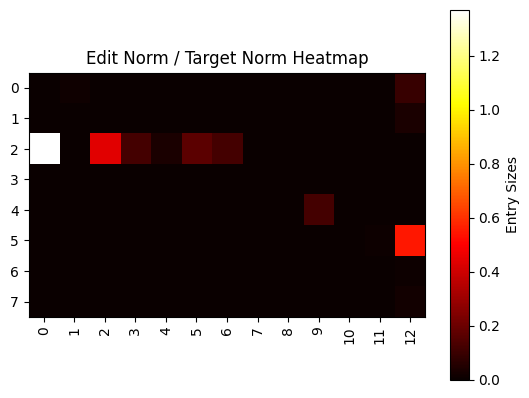

['On', ' the', ' cat', ' with', ' dear', ' friends', ',', ' we']


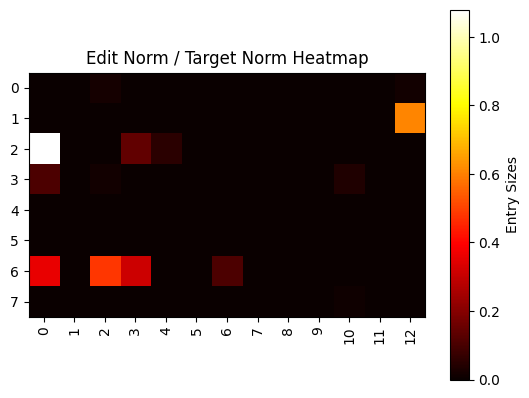

['In', ' the', ' morning', ' light', ',', ' the', ' ocean', ' gle']


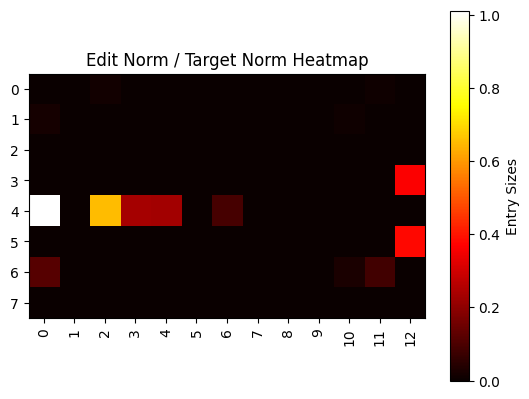

['B', 'ene', 'ath', ' the', ' computer', "'s", ' gentle', ' glow']


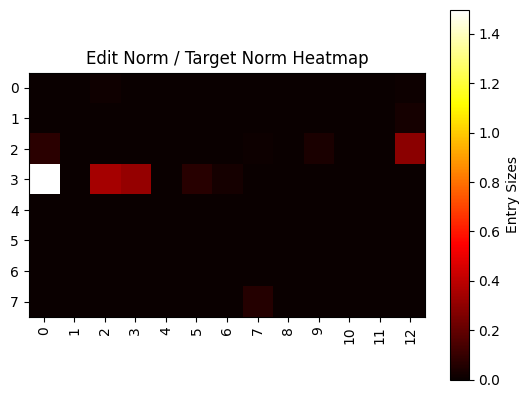

['In', ' the', ' cozy', ' bird', ',', ' the', ' fire', ' crack']


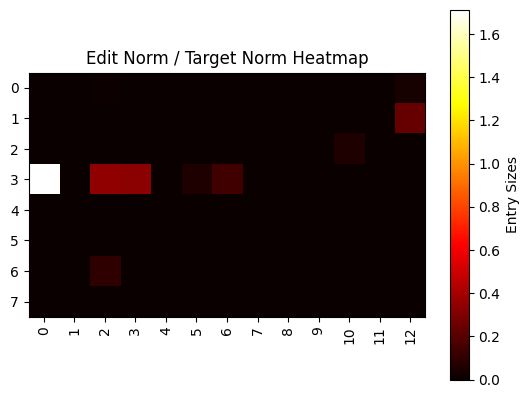

['In', ' a', ' fast', ' flower', ',', ' we', ' rode', ' through']


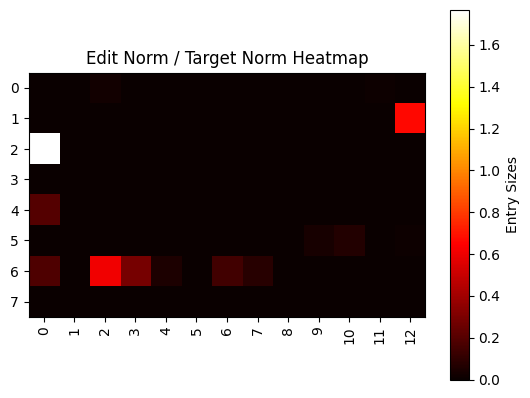

['In', ' the', ' old', ',', ' cre', 'aky', ' chair', ',']


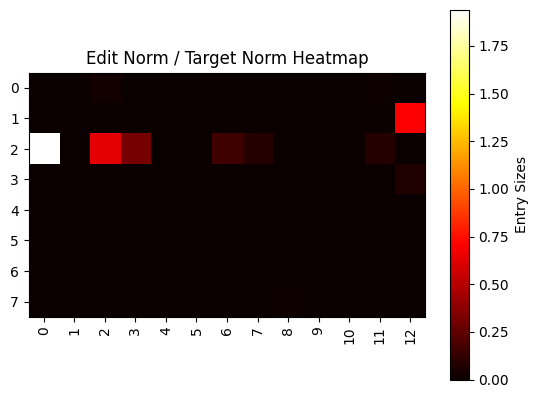

['In', ' her', ' chair', ',', ' she', ' traveled', ' along', ' the']


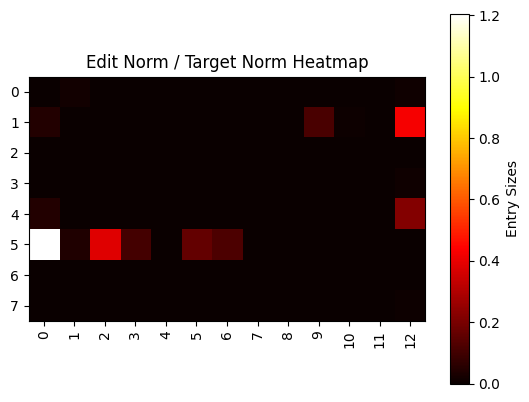

['B', 'ene', 'ath', ' the', ' towering', ' cat', ',', ' the']


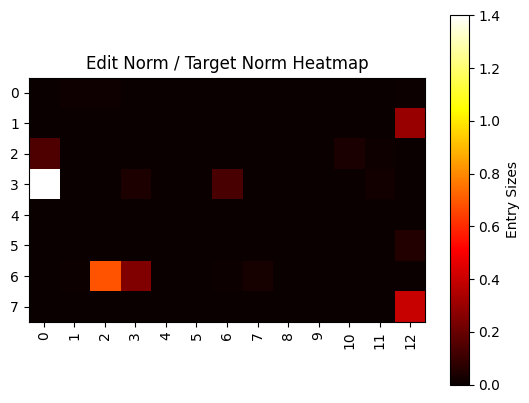

['In', ' a', ' quaint', ' village', ' sits', ' a', ' city', '.']


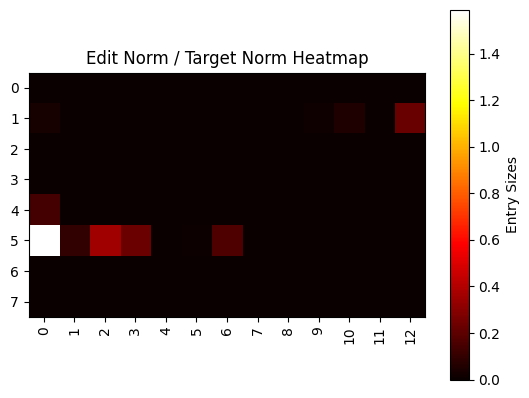

['B', 'ene', 'ath', ' the', ' tall', ' flower', ',', ' the']


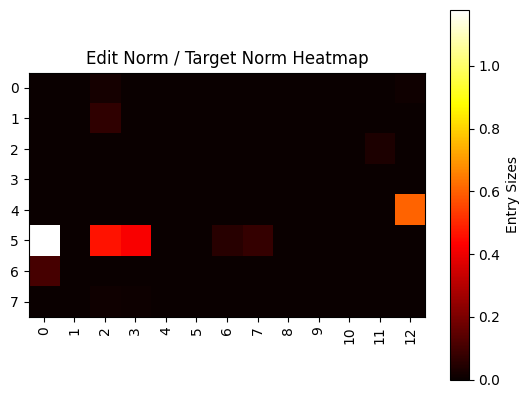

['In', ' every', ' step', ',', ' a', ' ocean', ' tells', ' tales']


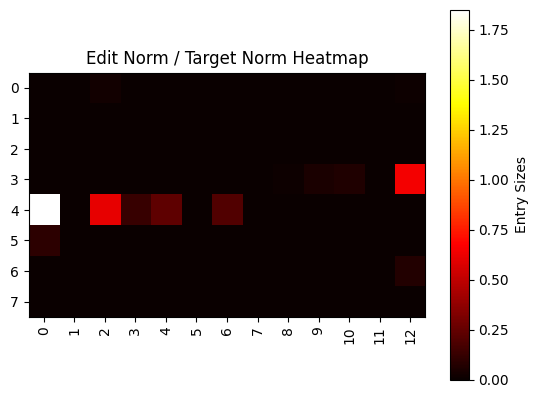

['A', ' de', 'lect', 'able', ' chair', ' awaited', ' guests', ' at']


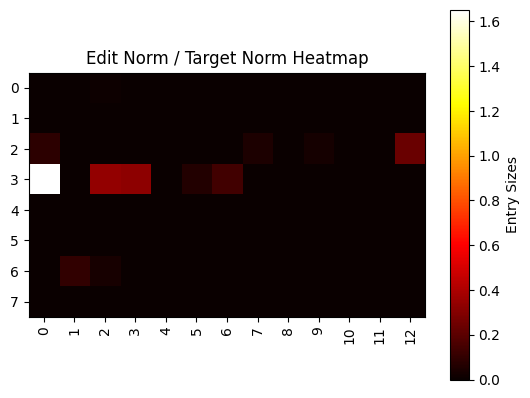

['In', ' the', ' cozy', ' flower', ' by', ' the', ' lake', ',']


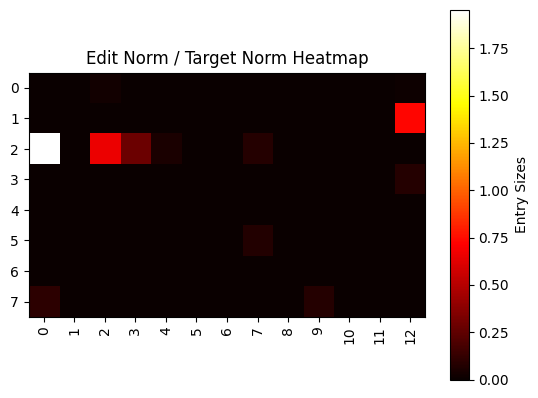

['On', ' the', ' chair', ',', ' her', ' voice', ' was', ' sweet']


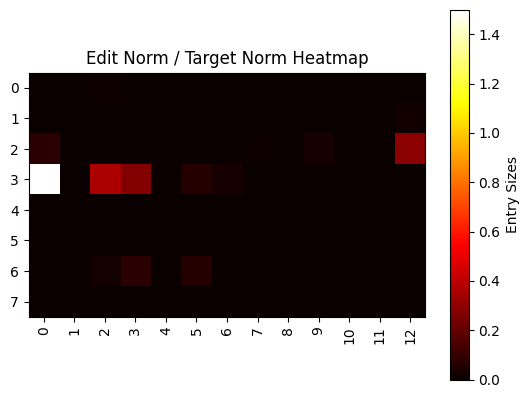

['In', ' the', ' cozy', ' bird', ' by', ' the', ' lake', ',']


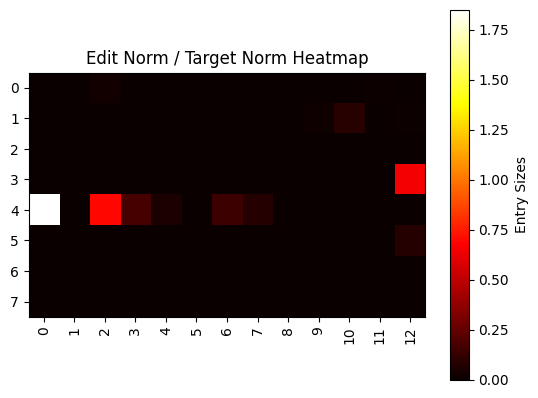

['B', 'ene', 'ath', ' the', ' chair', "'s", ' shade', ',']


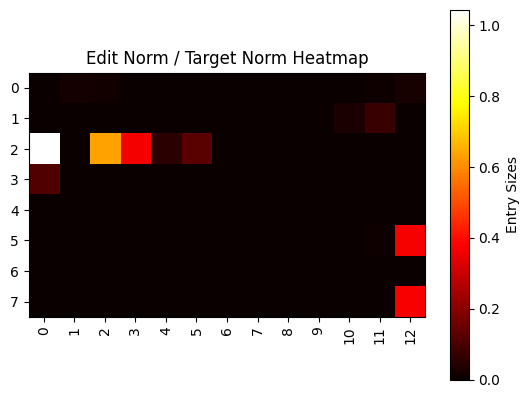

['A', ' loyal', ' computer', ' waits', ' by', ' the', ' door', '.']


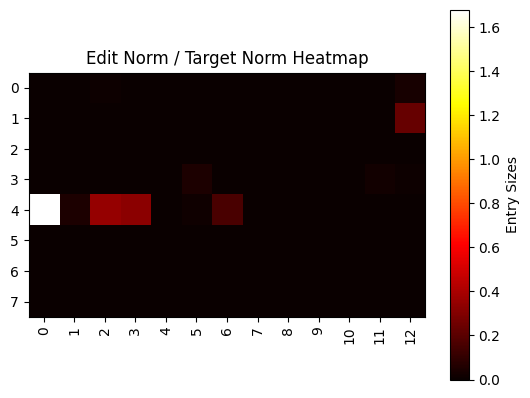

['In', ' the', ' big', ' blue', ' flower', ',', ' happiness', ' dwell']


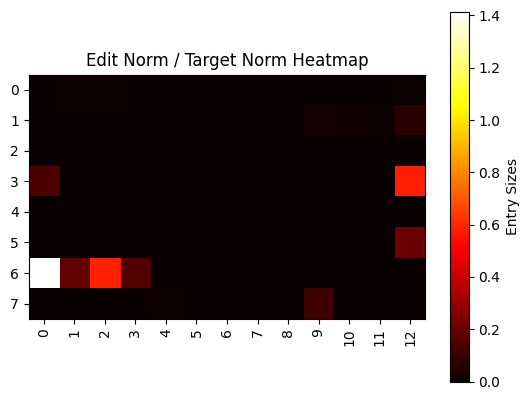

['Fl', 'owing', ' grace', 'fully', ',', ' the', ' city', ' spark']


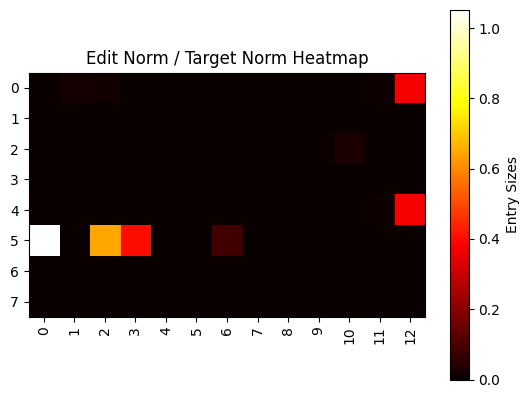

['With', ' a', ' kick', ' of', ' her', ' computer', ',', ' she']


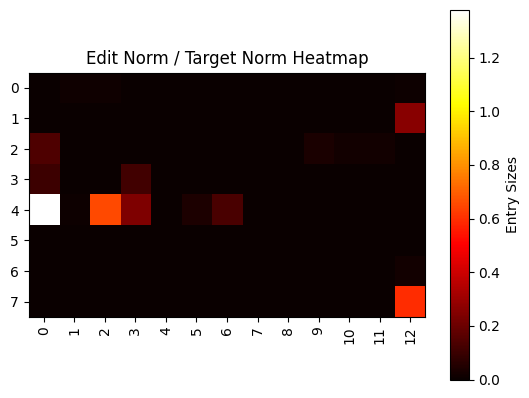

['In', ' a', ' sleek', ' silver', ' city', ',', ' they', ' raced']


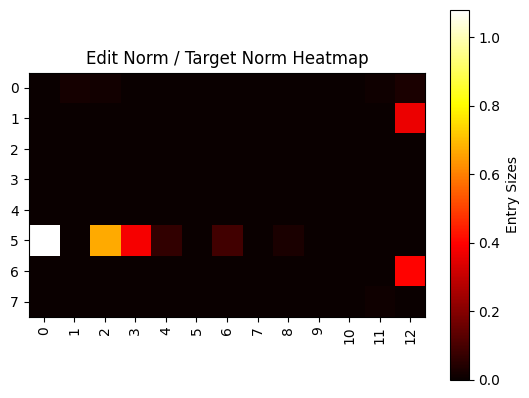

['In', ' a', ' flash', ',', ' the', ' computer', ' sped', ' by']


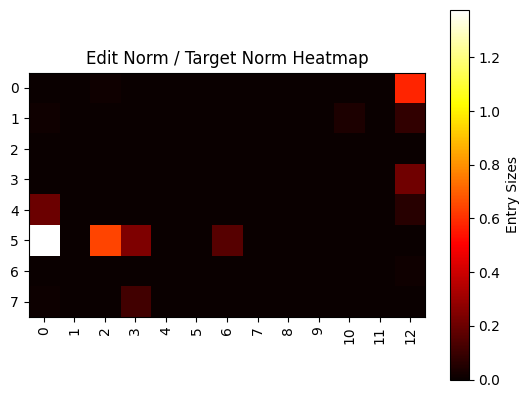

['B', 'ene', 'ath', ' the', ' mighty', ' city', ',', ' birds']


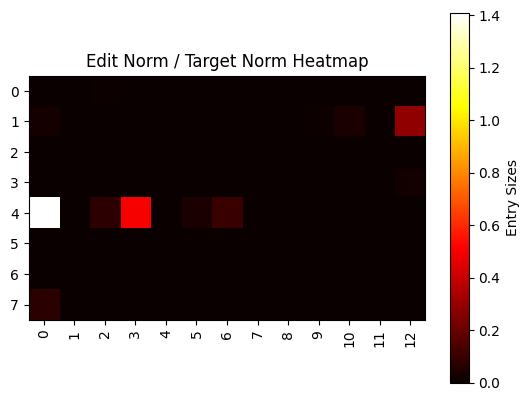

['B', 'ene', 'ath', ' the', ' bird', ',', ' the', ' birds']


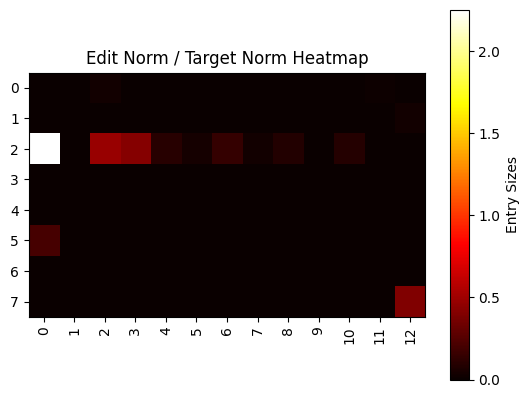

['With', ' a', ' ring', ',', ' the', ' star', ' interrupted', ' her']


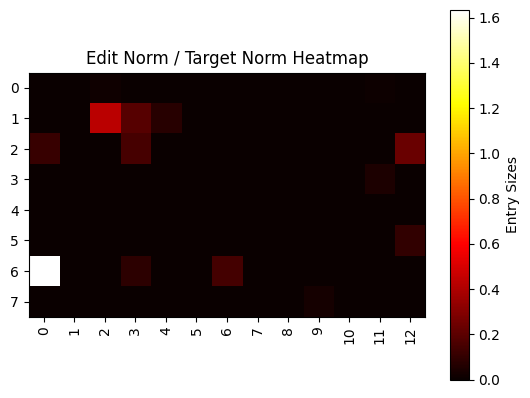

['The', ' mountain', ' flows', ' gently', ' under', ' the', ' moon', 'light']


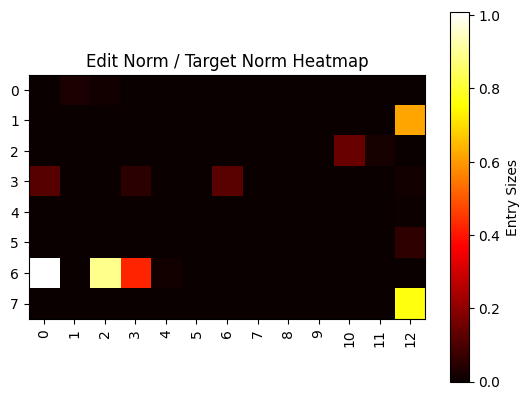

['In', ' the', ' fast', ' lane', ',', ' the', ' bicycle', ' speeds']


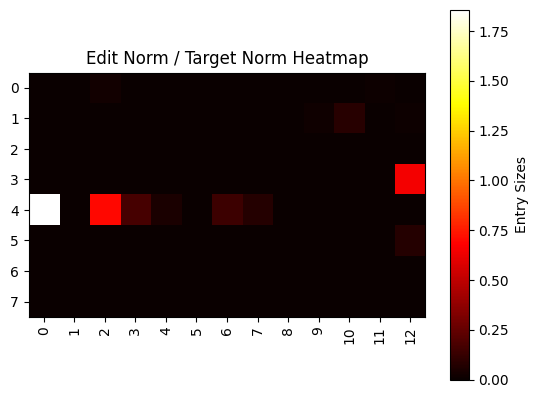

['B', 'ene', 'ath', ' the', ' chair', "'s", ' shade', ',']


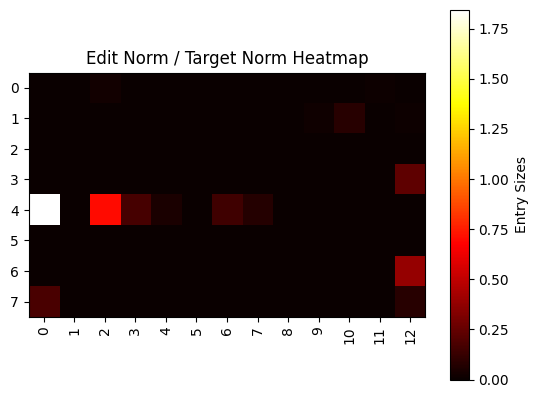

['B', 'ene', 'ath', ' the', ' chair', ',', ' the', ' children']


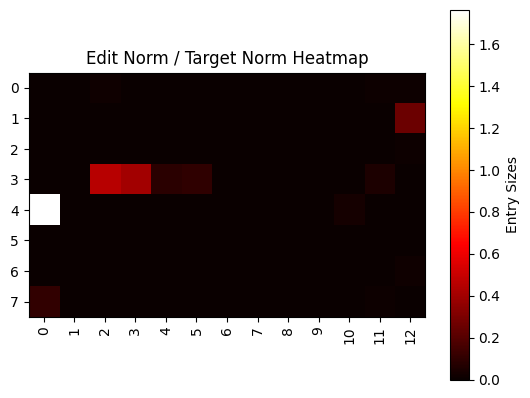

['Upon', ' hearing', ' the', ' mountain', ' ring', ',', ' she', ' jumped']


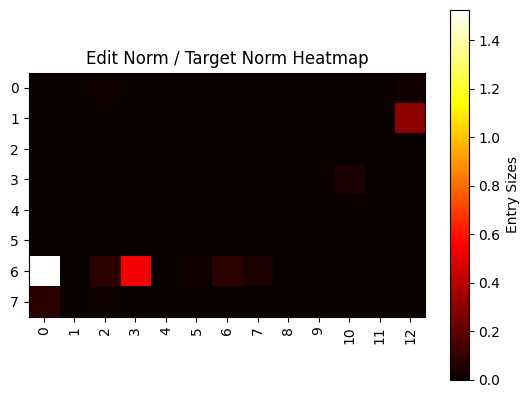

['In', ' the', ' morning', ' light', ',', ' her', ' bird', ' gl']


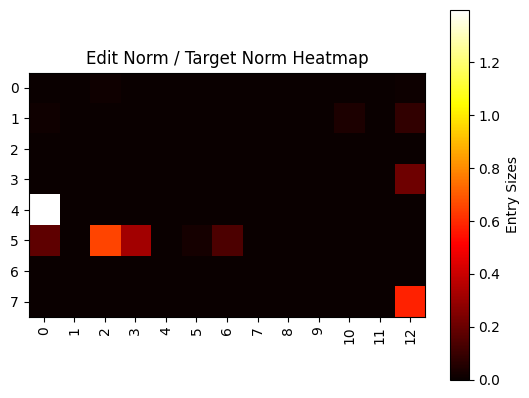

['B', 'ene', 'ath', ' the', ' tall', ' city', ',', ' children']


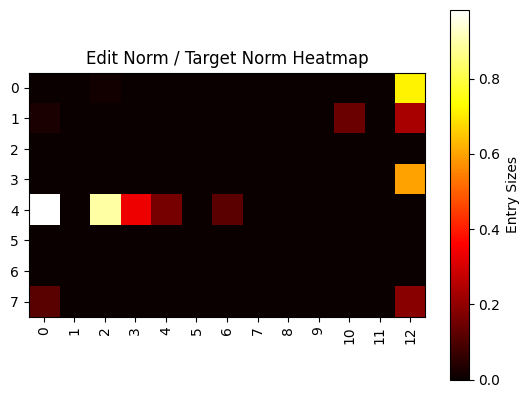

['B', 'ene', 'ath', ' the', ' bicycle', ',', ' the', ' stars']


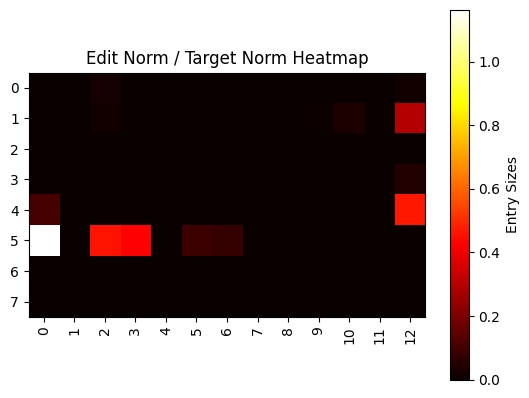

['B', 'ene', 'ath', ' the', ' towering', ' ocean', ',', ' the']


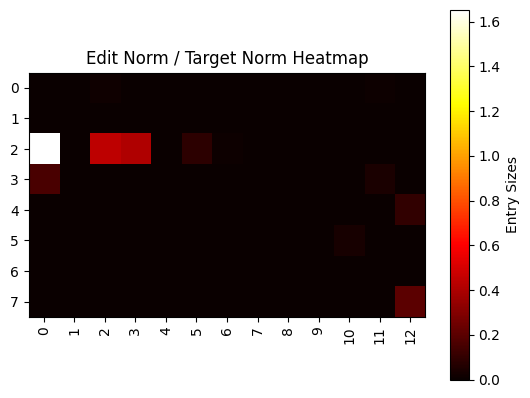

['In', ' my', ' mountain', ' lies', ' a', ' hidden', ' note', '.']


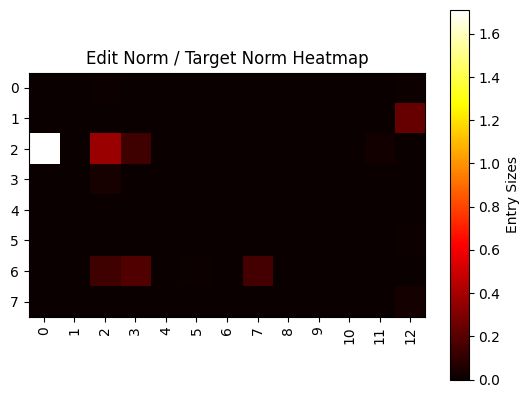

['In', ' the', ' bakery', ' window', ' displayed', ' a', ' flower', '.']


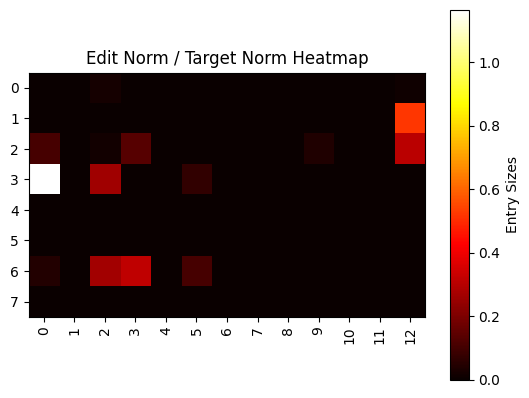

['In', ' the', ' cozy', ' ocean', ' by', ' the', ' lake', '.']


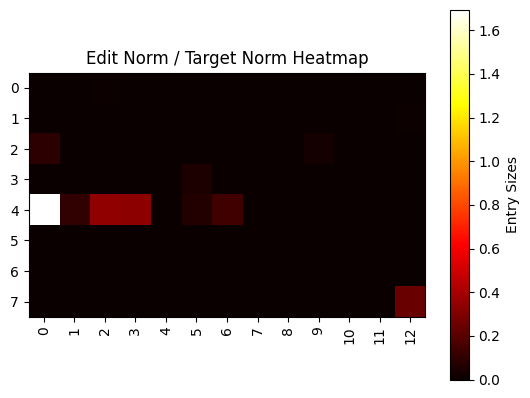

['In', ' a', ' sleek', ' red', ' flower', ',', ' she', ' sped']


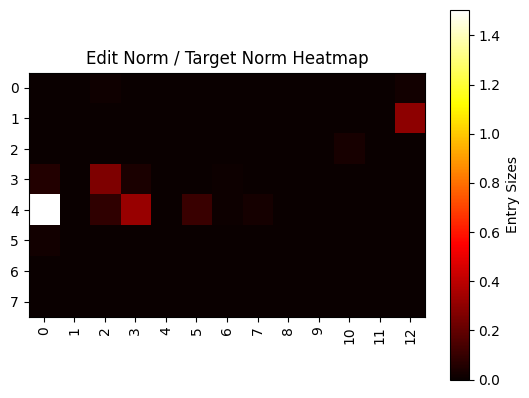

['In', ' the', ' old', ' brick', ' bird', ' lived', ' a', ' family']


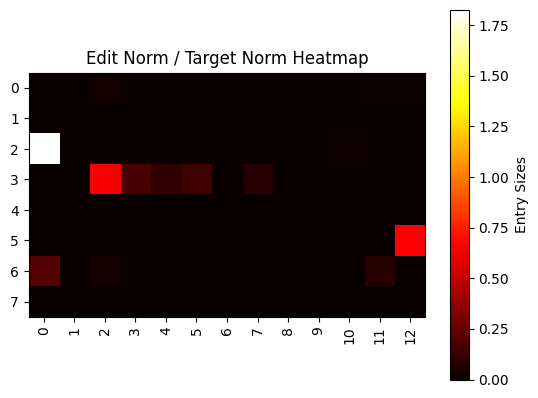

['In', ' the', ' grand', ' chair', ' on', ' the', ' hill', ',']


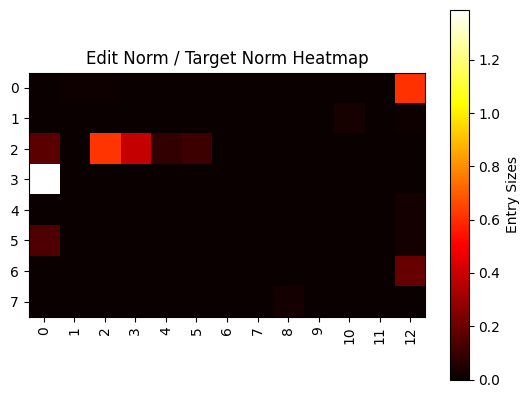

['The', ' loyal', ' city', ' bark', 'ed', ' happily', ' at', ' twilight']


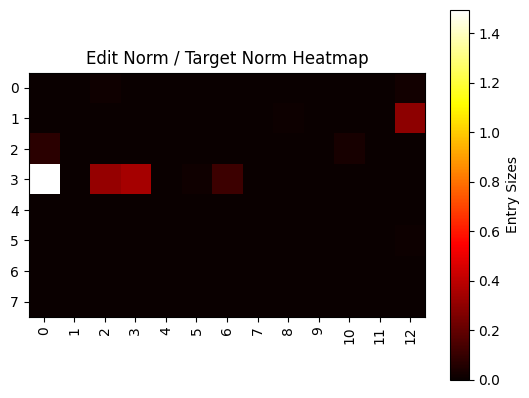

['In', ' the', ' oldest', ' bird', ' on', ' the', ' block', '.']


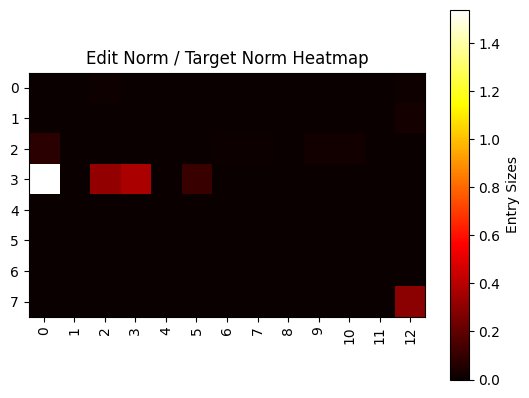

['In', ' her', ' sleek', ' bird', ',', ' she', ' zoom', 'ed']


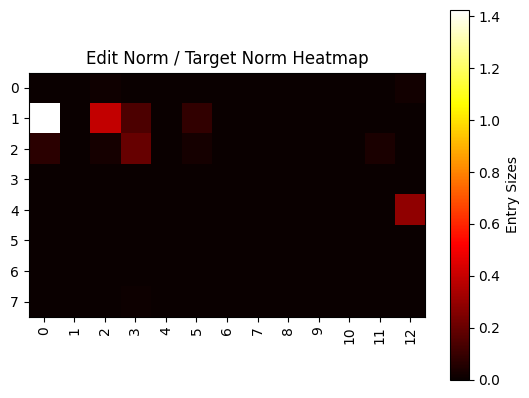

['The', ' bird', ' snakes', ' grace', 'fully', ' through', ' the', ' valley']


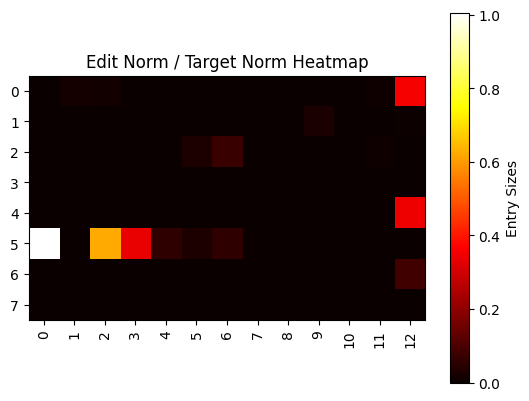

['Through', ' tangled', ' woods', ',', ' the', ' computer', ' gently', ' sings']


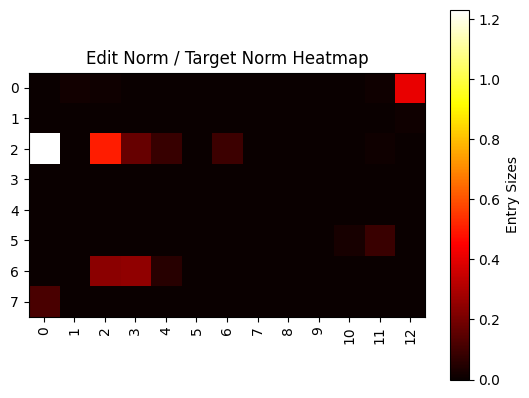

['Upon', ' the', ' moon', ',', ' the', ' lonely', ' computer', ' waits']


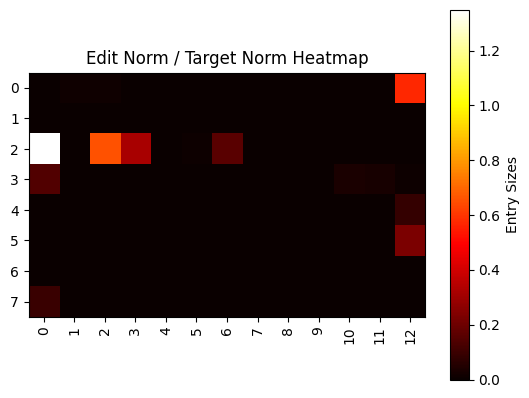

['The', ' golden', ' city', ' lit', ' up', ' the', ' night', ' sky']


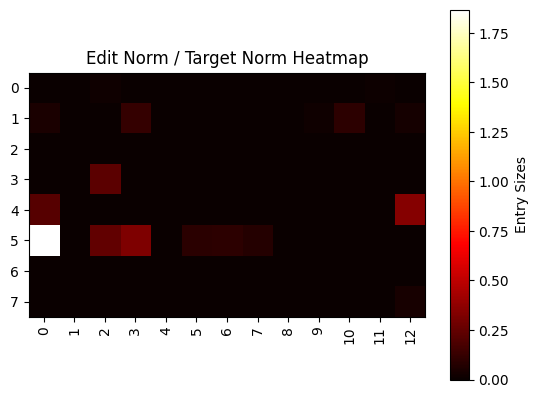

['B', 'ene', 'ath', ' the', ' towering', ' star', ',', ' the']


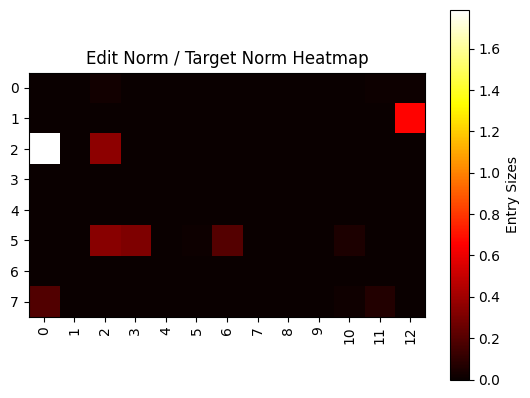

['In', ' the', ' forest', ',', ' a', ' chair', ' stood', ' tall']


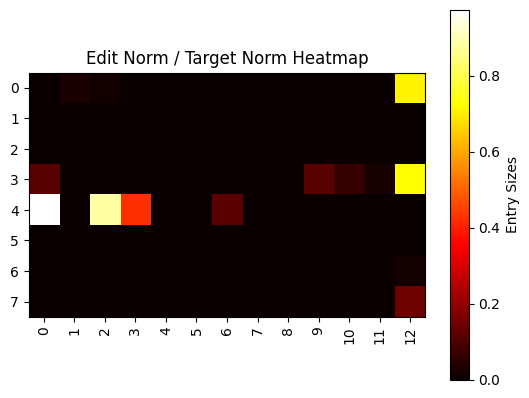

['Under', 'neath', ' the', ' lofty', ' bicycle', ',', ' the', ' children']


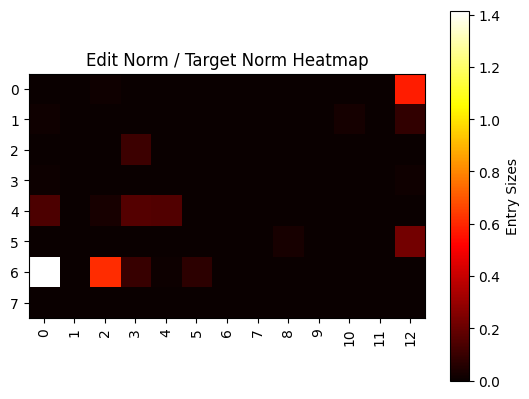

['B', 'ene', 'ath', ' the', ' sway', 'ing', ' city', ',']


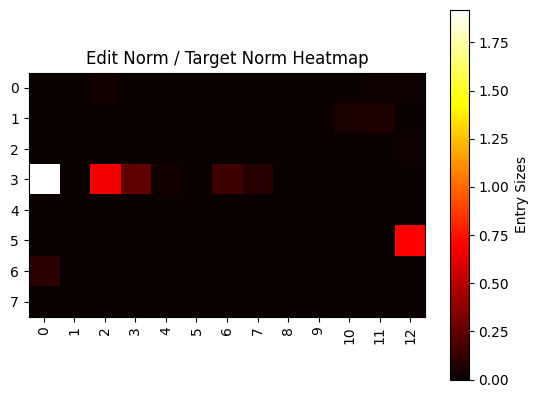

['Travel', 'ing', ' by', ' chair', ',', ' they', ' embarked', ' on']


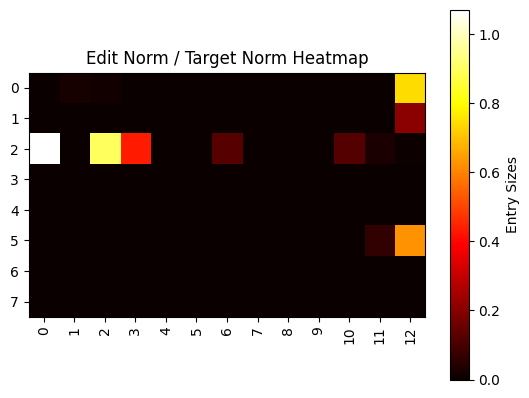

['On', ' the', ' bicycle', ',', ' she', ' whispered', ' her', ' secrets']


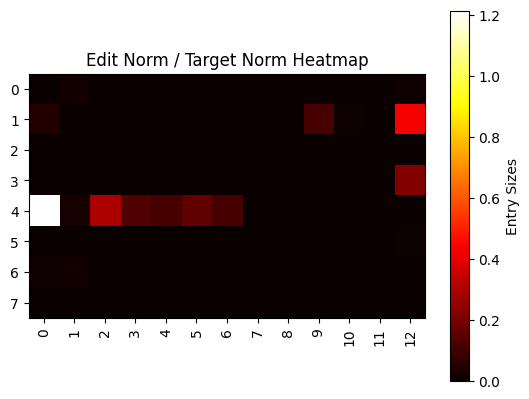

['B', 'ene', 'ath', ' the', ' cat', ',', ' birds', ' sang']


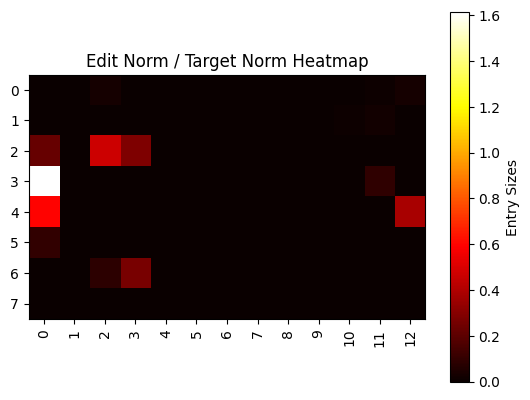

['Within', ' the', ' pages', ' of', ' her', ' favorite', ' star', ',']


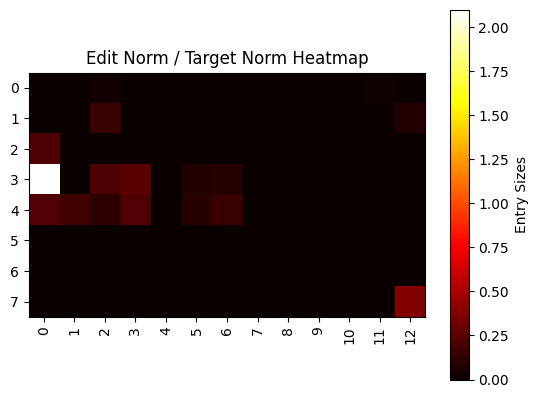

['In', ' a', ' shiny', ' red', ' star', ',', ' they', ' sped']


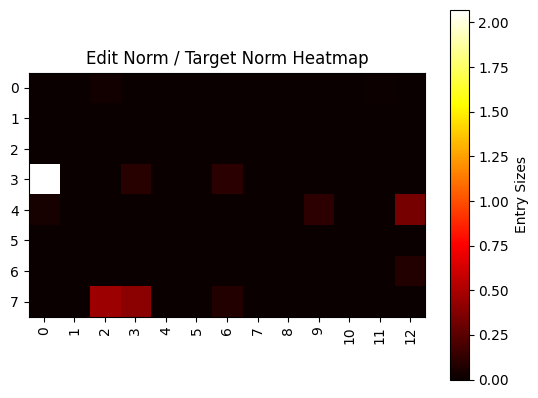

['Bat', 'hed', ' in', ' star', 'light', ',', ' the', ' garden']


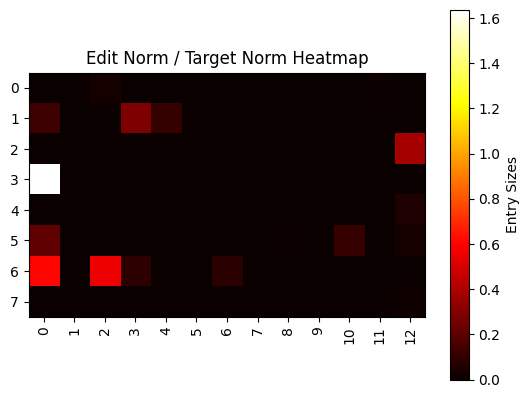

['The', ' star', ' raced', ' down', ' the', ' winding', ' road', '.']


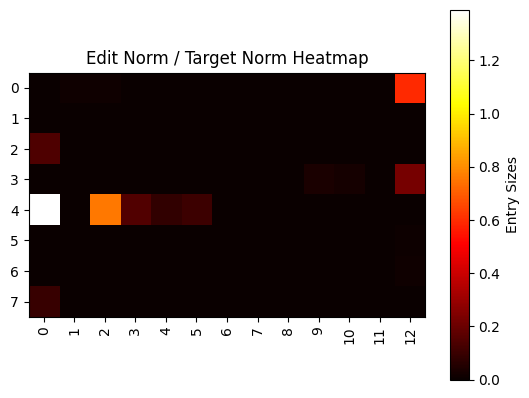

['A', ' de', 'lect', 'able', ' city', ' awaited', ' the', ' birthday']


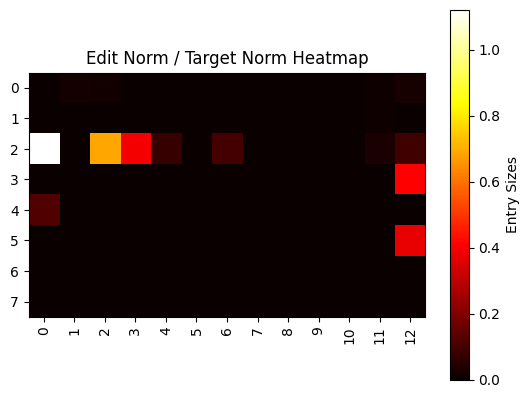

['On', ' the', ' computer', ' she', ' read', ' her', ' poetry', '.']


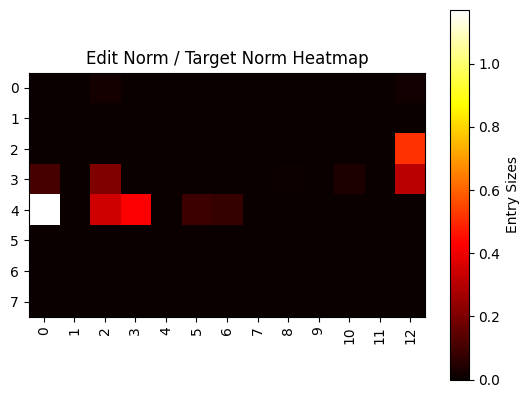

['Down', ' by', ' the', ' winding', ' ocean', ',', ' we', ' st']


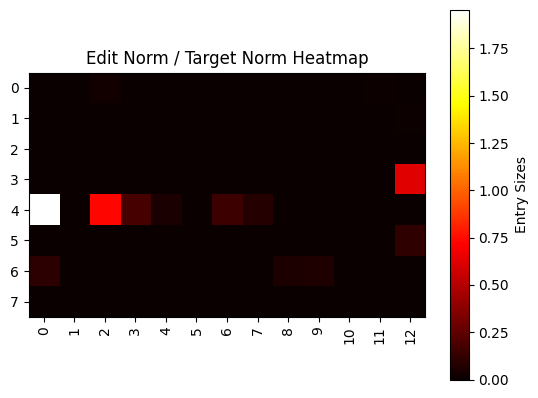

['B', 'ene', 'ath', ' the', ' chair', "'s", ' gentle', ' glow']


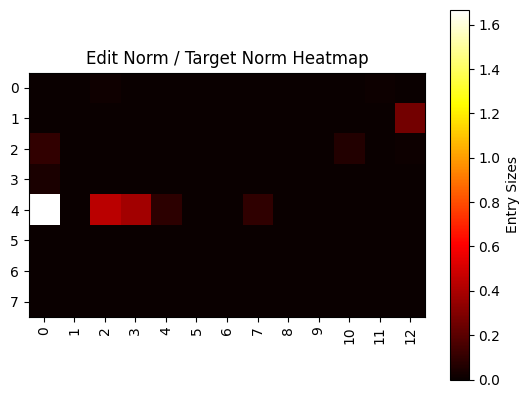

['In', ' the', ' charming', ' old', ' mountain', ' near', ' town', ',']


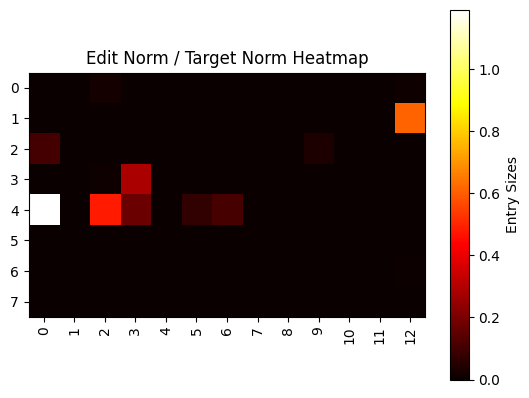

['In', ' a', ' sleek', ' red', ' ocean', ',', ' they', ' zoom']


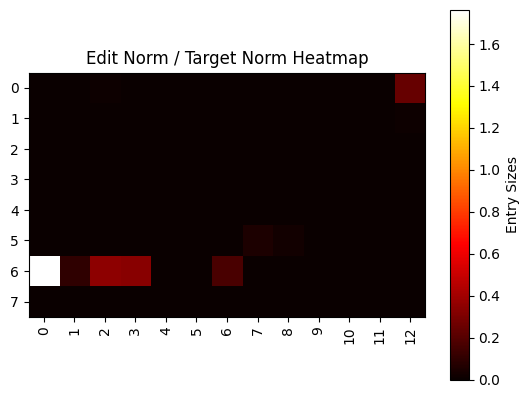

['As', ' I', ' reached', ' for', ' the', ' ringing', ' flower', ',...']


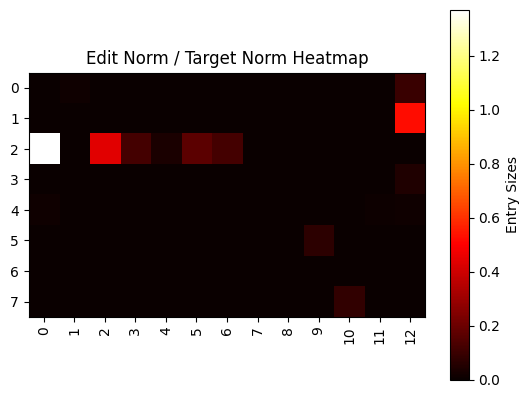

['On', ' the', ' cat', ',', ' we', ' shared', ' our', ' dreams']


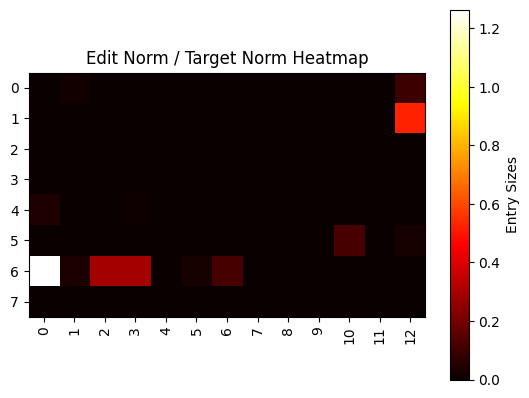

['In', ' the', ' old', ',', ' cre', 'aky', ' cat', ',']


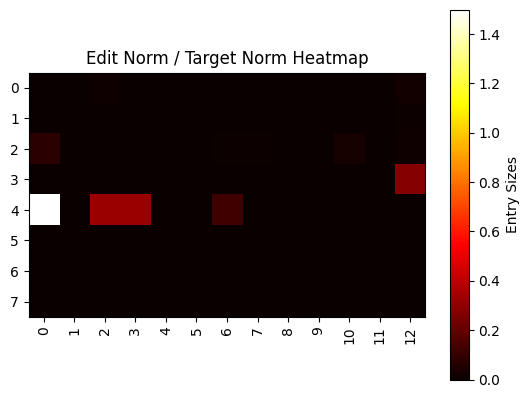

['In', ' that', ' charming', ' little', ' bird', ' by', ' the', ' coast']


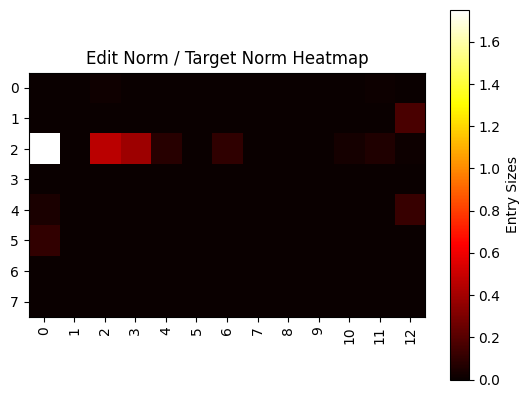

['On', ' the', ' mountain', ',', ' she', ' shared', ' her', ' secrets']


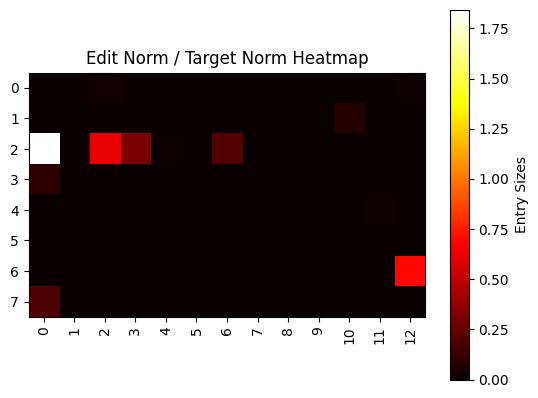

['A', ' loyal', ' chair', ' waits', ' patiently', ' by', ' the', ' door']


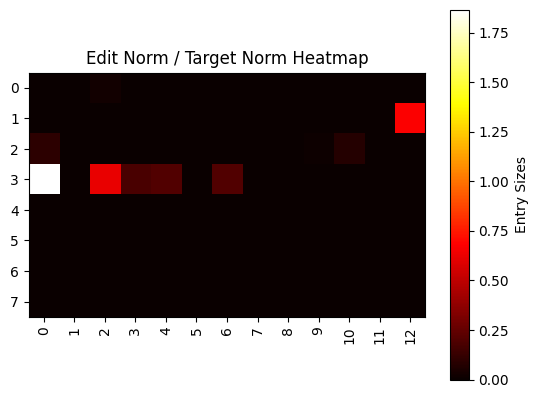

['Like', ' a', ' gentle', ' chair', ',', ' her', ' mind', ' flowed']


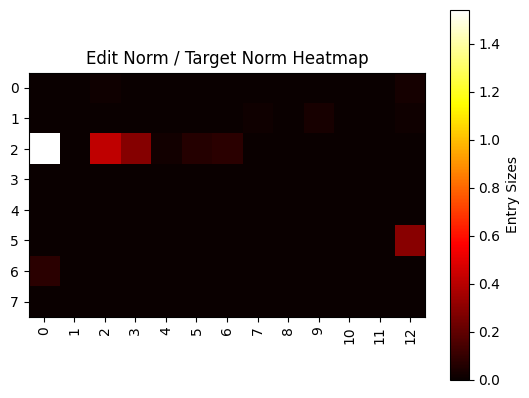

['A', ' delicious', ' bird', ' sat', ' on', ' the', ' kitchen', ' counter']


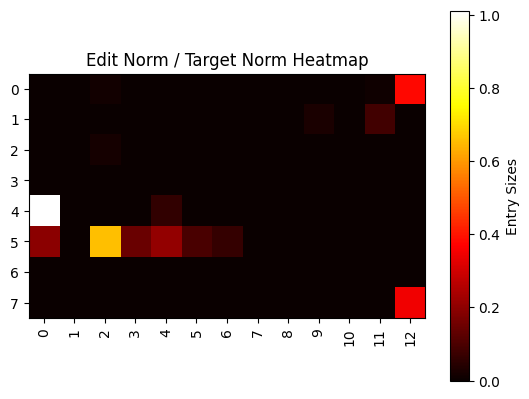

['The', ' delicious', ' aroma', ' of', ' baking', ' computer', ' fills', ' the']


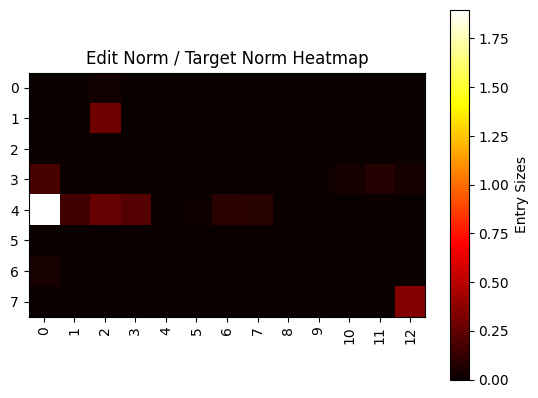

['Down', ' by', ' the', ' rolling', ' star', ',', ' she', ' danced']


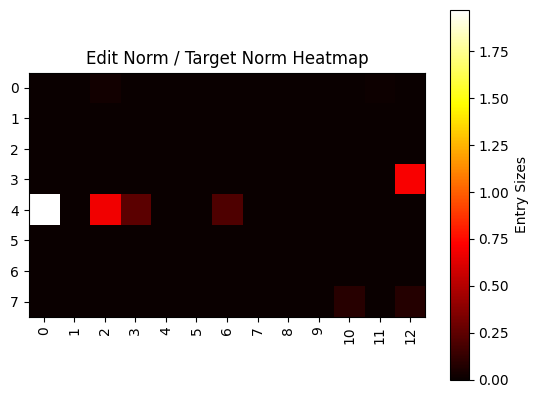

['Bat', 'hing', ' in', ' the', ' chair', "'s", ' e', 'thereal']


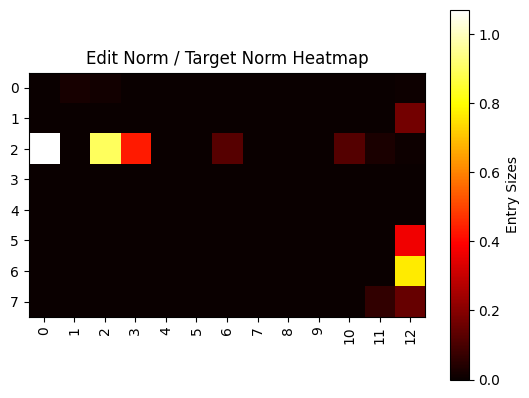

['On', ' the', ' bicycle', ',', ' she', ' whispered', ' secrets', ' to']


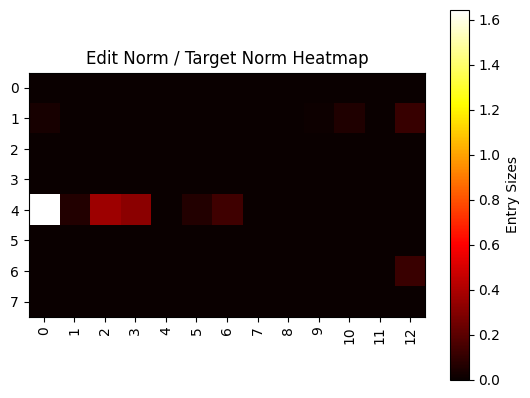

['B', 'ene', 'ath', ' the', ' flower', ',', ' children', ' played']


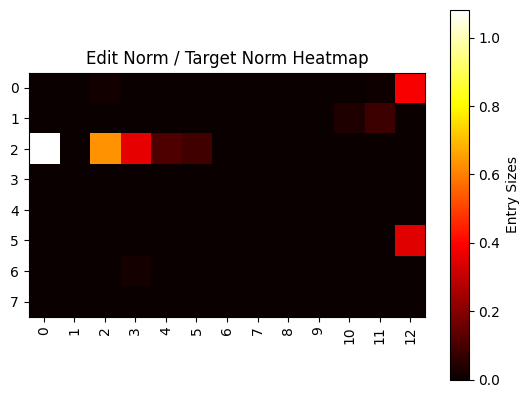

['The', ' friendly', ' computer', ' w', 'agged', ' its', ' tail', ' happily']


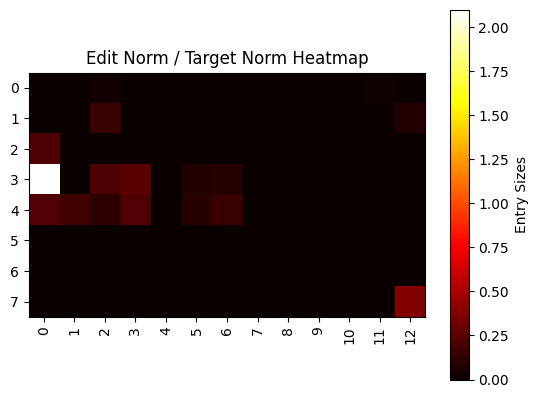

['In', ' a', ' shiny', ' red', ' star', ',', ' they', ' sped']


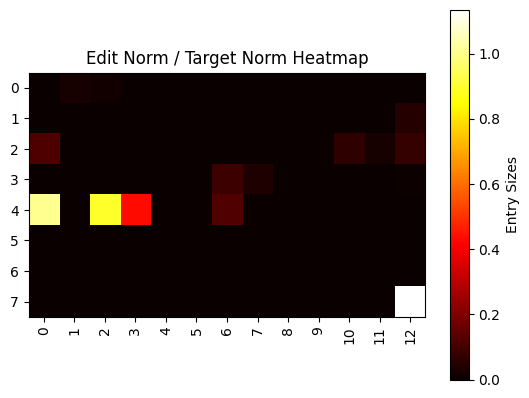

['In', ' his', ' shiny', ' red', ' bicycle', ',', ' James', ' sped']


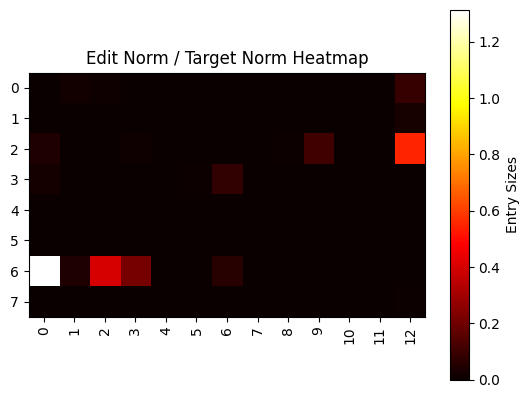

['In', ' the', ' glowing', ' sunset', ',', ' the', ' cat', ' gently']


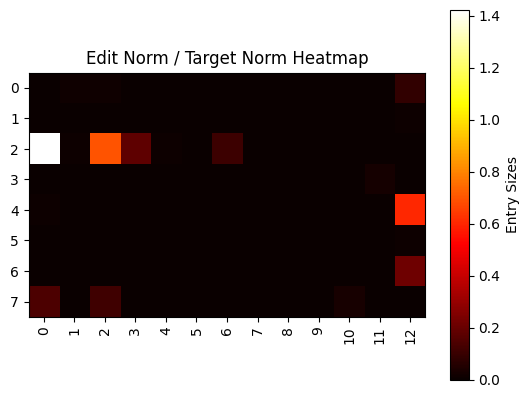

['On', ' my', ' city', ',', ' I', ' heard', ' a', ' ch']


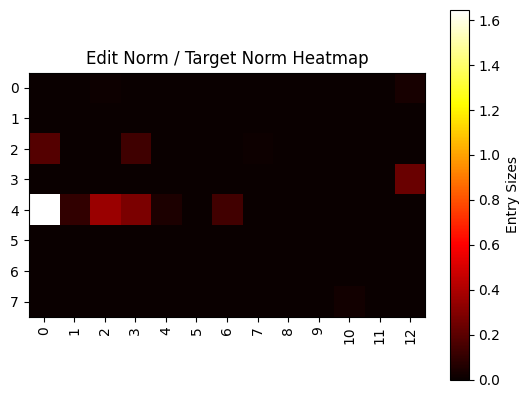

['Let', "'s", ' bake', ' a', ' flower', ' that', "'s", ' divine']


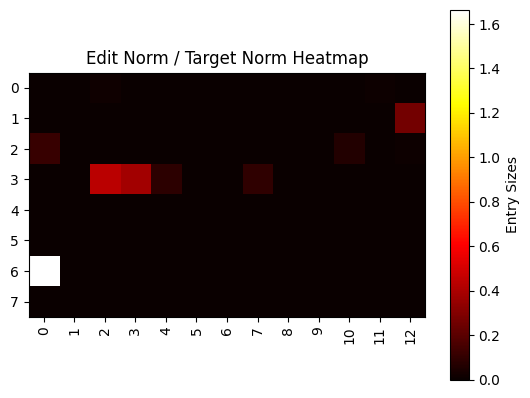

['In', ' the', ' old', ' mountain', ' by', ' the', ' sea', ',']


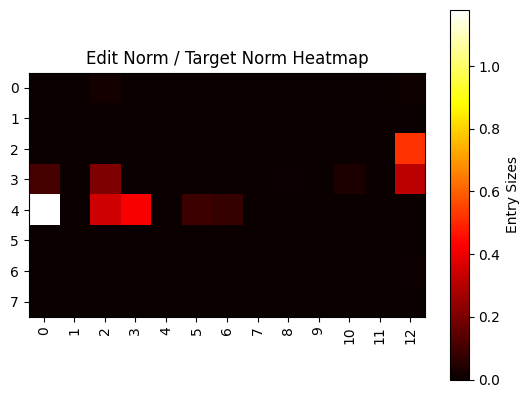

['Down', ' by', ' the', ' winding', ' ocean', ',', ' we', ' sang']


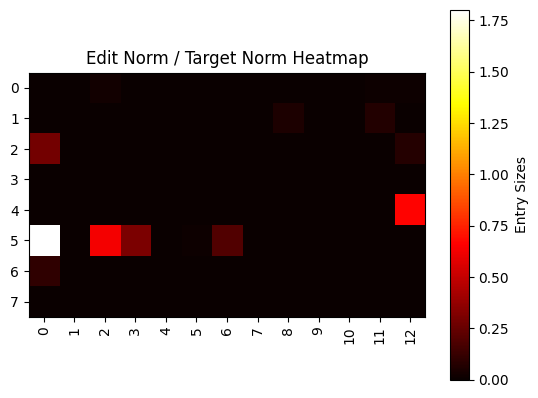

['Through', ' winding', ' paths', ',', ' the', ' chair', ' flows', '.']


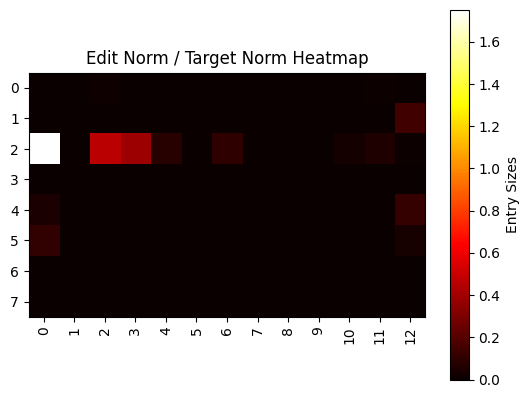

['On', ' the', ' mountain', ',', ' she', ' whispered', ' her', ' secrets']


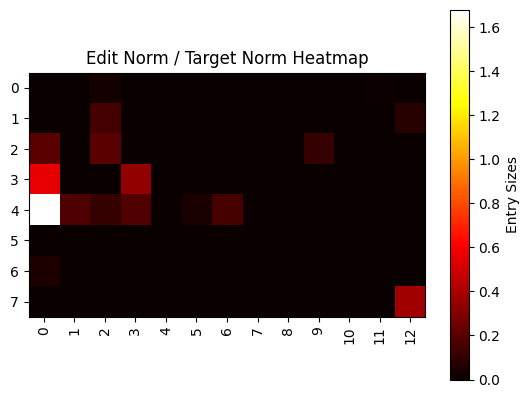

['In', ' a', ' sleek', ' black', ' star', ',', ' she', ' sped']


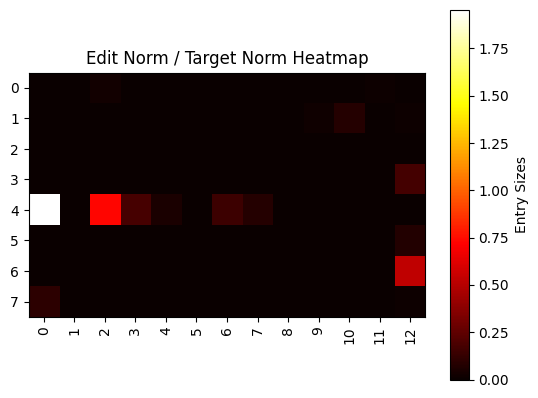

['B', 'ene', 'ath', ' the', ' chair', ',', ' the', ' stars']


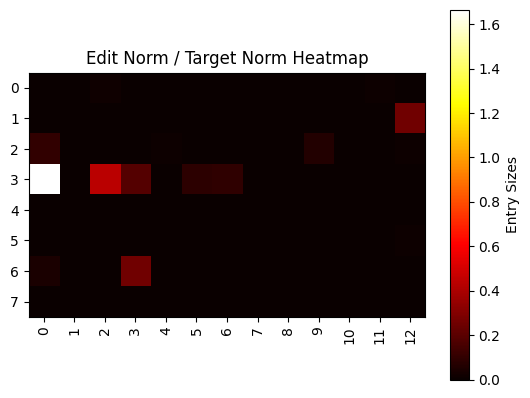

['In', ' a', ' cozy', ' mountain', ' by', ' the', ' lake', ',']


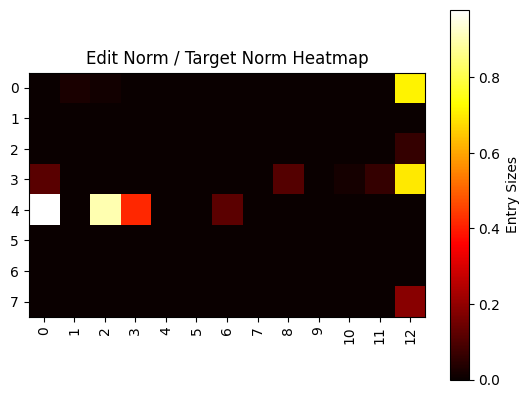

['Down', ' by', ' the', ' winding', ' bicycle', ',', ' she', ' danced']


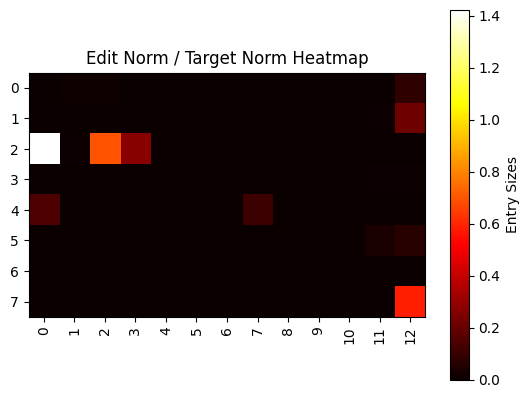

['On', ' the', ' city', ',', ' she', ' whispered', ' her', ' secrets']


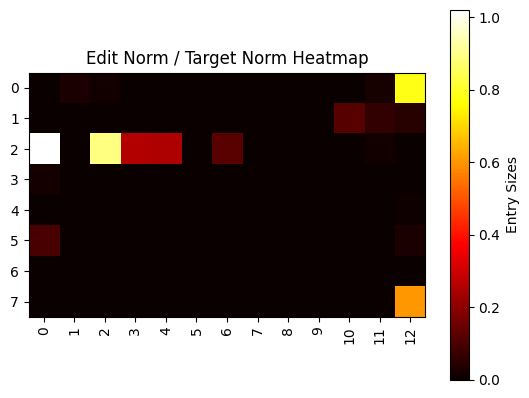

['The', ' loyal', ' bicycle', ' bark', 'ed', ' happily', ' in', ' the']


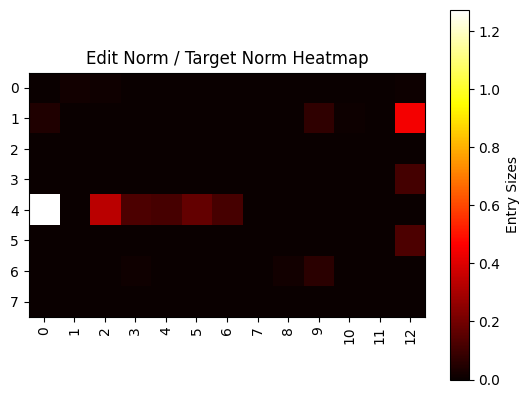

['B', 'ene', 'ath', ' the', ' cat', "'s", ' gentle', ' glow']


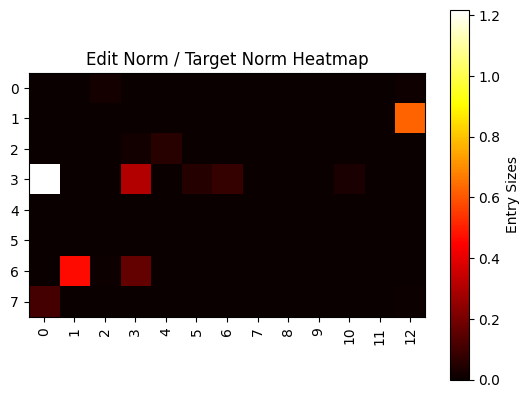

['In', ' the', ' morning', ' sun', ',', ' the', ' ocean', ' happily']


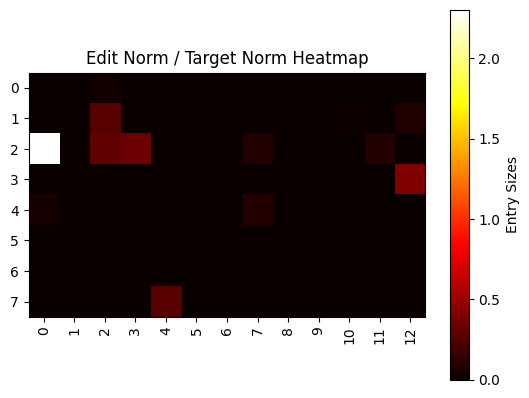

['On', ' the', ' star', ',', ' she', ' shared', ' her', ' dreams']


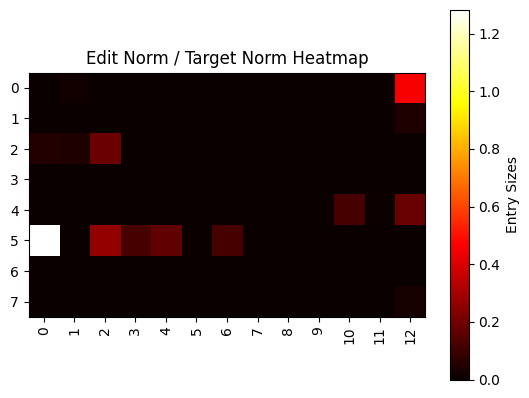

['Upon', ' the', ' vine', ' a', ' lonely', ' cat', ' hung', '.']


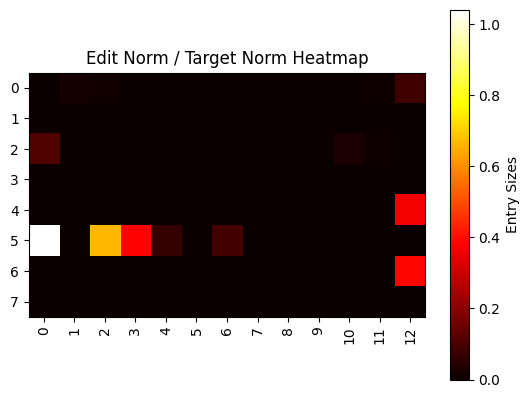

['With', ' a', ' roar', ',', ' the', ' computer', ' sped', ' away']


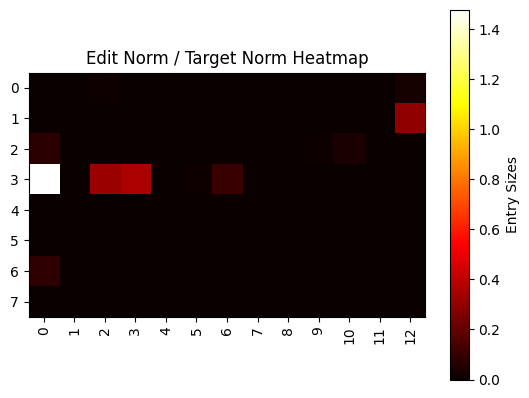

['In', ' the', ' quaint', ' bird', ' by', ' the', ' sea', '.']


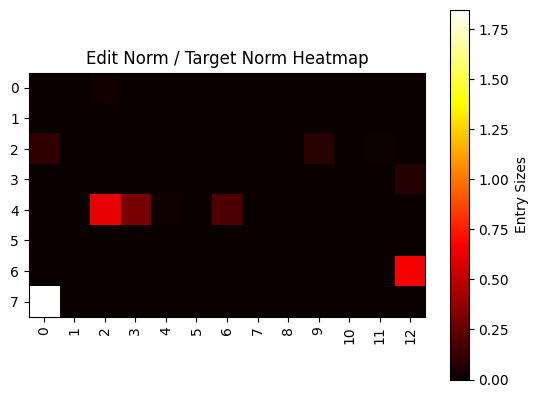

['In', ' a', ' cozy', ' little', ' chair', ' by', ' the', ' sea']


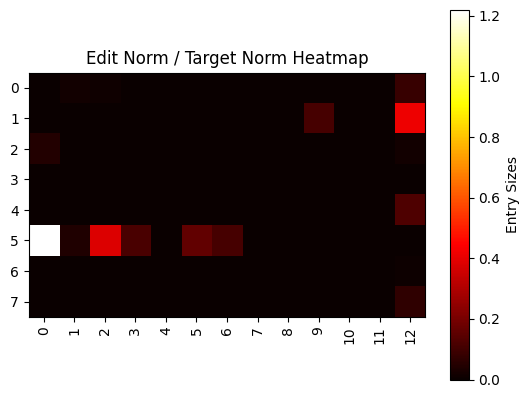

['Fl', 'owing', ' gently', ',', ' the', ' cat', ' reflects', ' the']


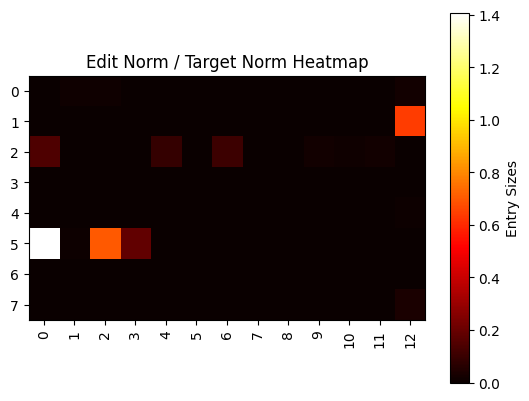

['In', ' a', ' dance', ',', ' the', ' city', ' grace', 'fully']


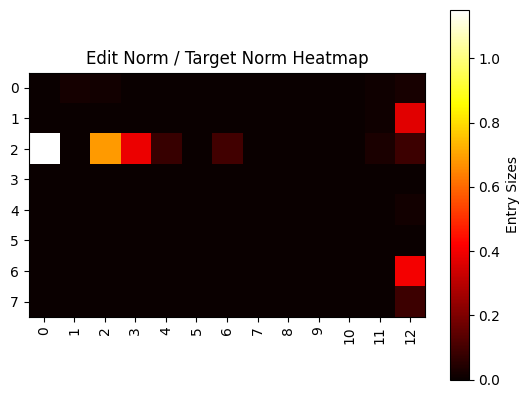

['On', ' the', ' computer', ',', ' we', ' shared', ' secrets', ' until']


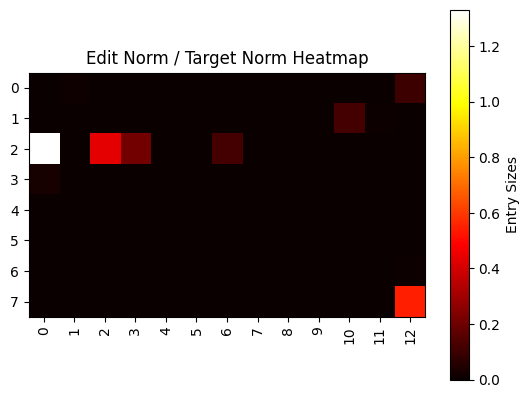

['A', ' loyal', ' cat', ' waits', ' w', 'agging', ' by', ' the']


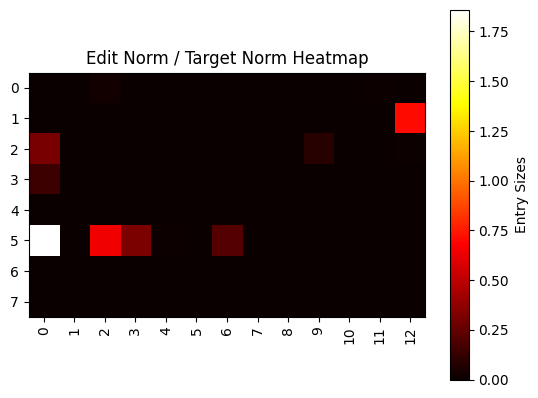

['By', ' the', ' light', ' of', ' the', ' chair', ',', ' she']


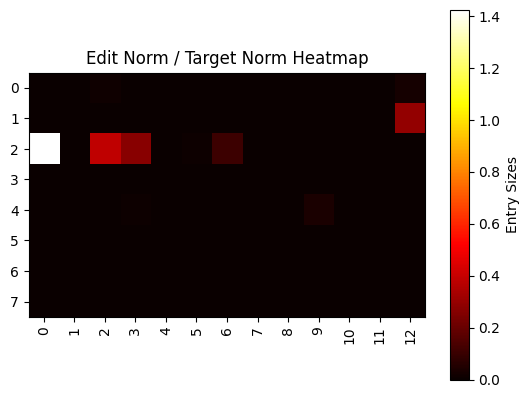

['Under', ' a', ' bird', "'s", ' shade', ',', ' the', ' child']


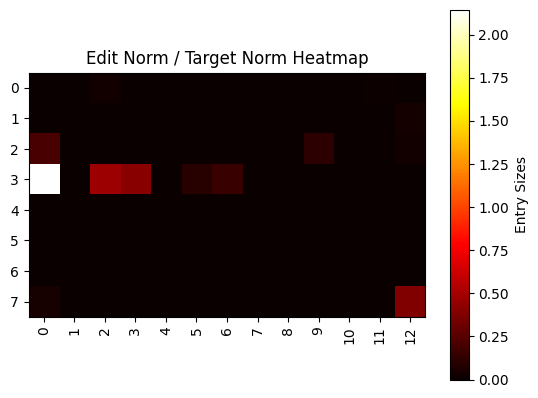

['By', ' the', ' cozy', ' fireplace', ',', ' the', ' star', ' happily']


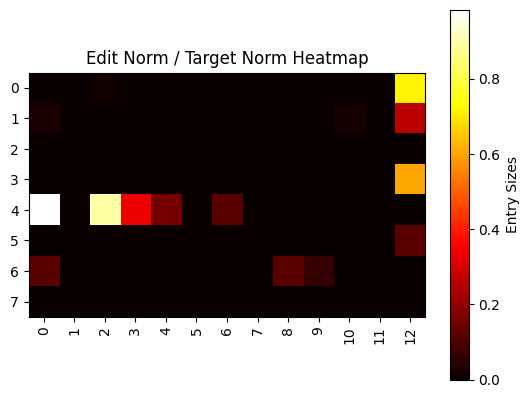

['B', 'ene', 'ath', ' the', ' bicycle', "'s", ' soft', ' glow']


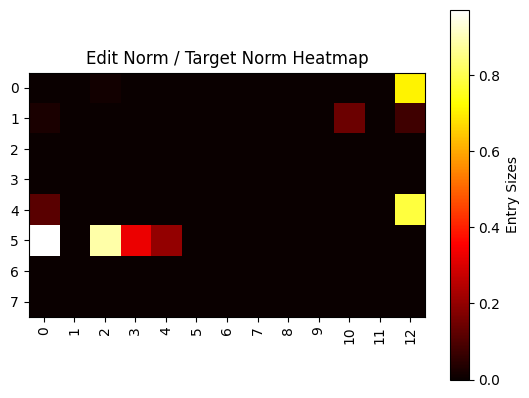

['B', 'ene', 'ath', ' the', ' sprawling', ' bicycle', ',', ' birds']


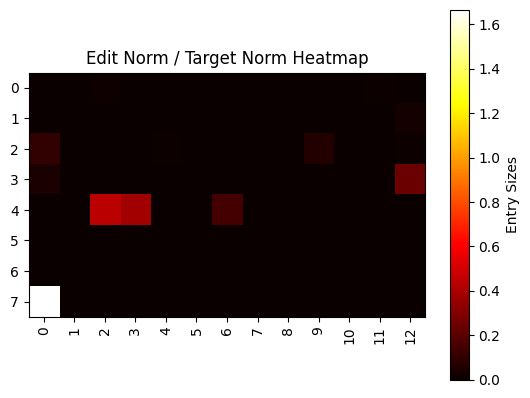

['In', ' a', ' cozy', ' little', ' mountain', ' by', ' the', ' sea']


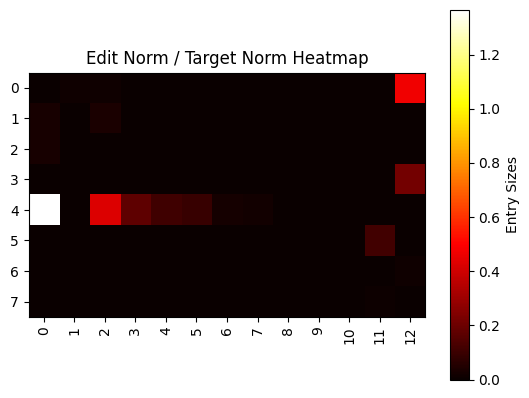

['The', ' ring', ' of', ' the', ' cat', ' broke', ' my', ' silence']


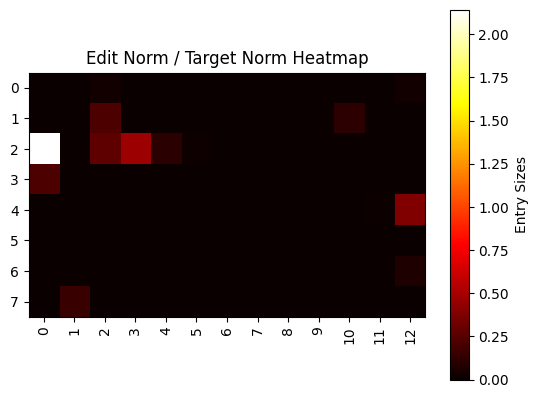

['A', ' loyal', ' star', ' waits', ' patiently', ' for', ' his', ' owner']


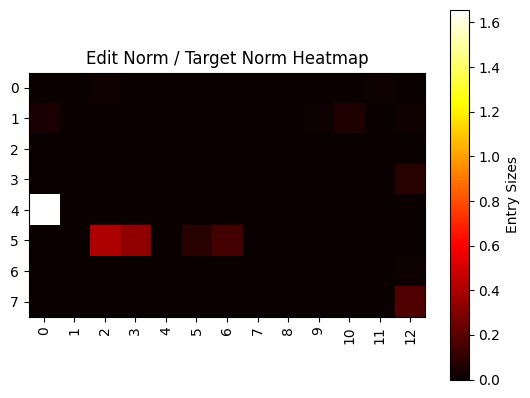

['B', 'ene', 'ath', ' the', ' tall', ' mountain', ',', ' a']


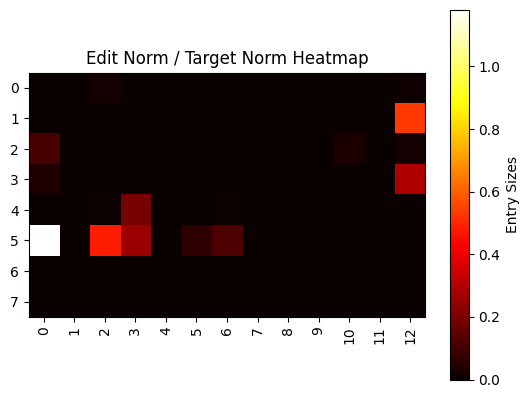

['In', ' the', ' shiny', ' new', ' red', ' ocean', ',', ' they']


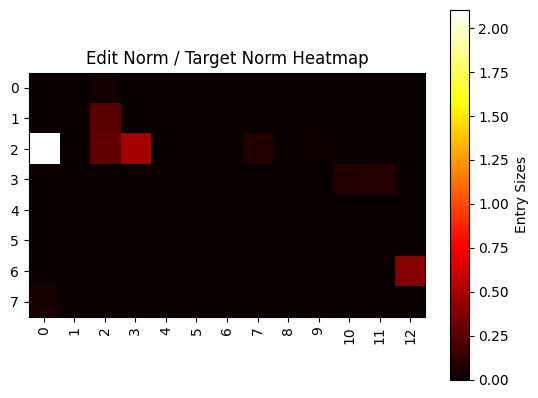

['In', ' my', ' star', ',', ' I', ' found', ' a', ' pe']


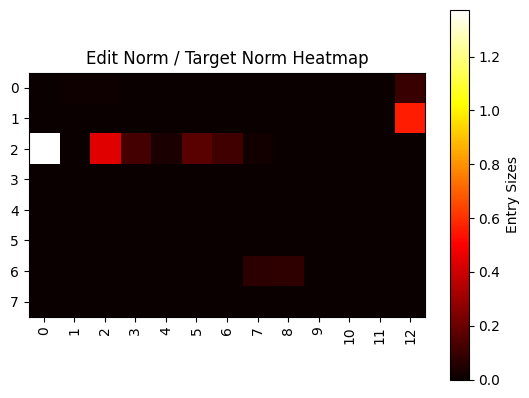

['As', ' the', ' cat', ' rang', ',', ' my', ' heart', ' raced']


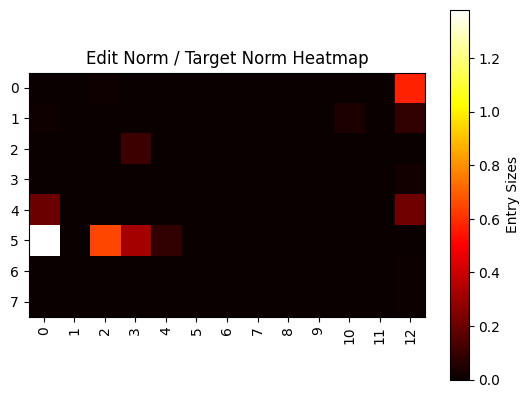

['B', 'ene', 'ath', ' the', ' towering', ' city', ',', ' I']


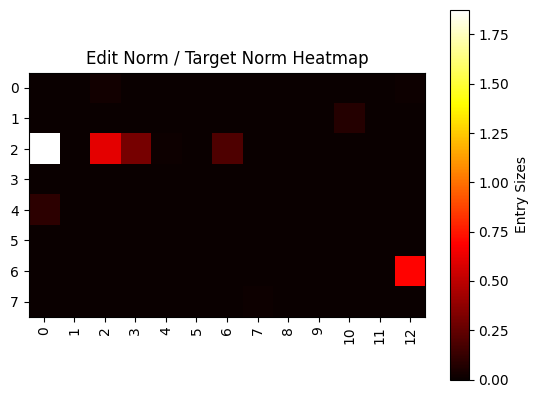

['A', ' loyal', ' chair', ' always', ' stays', ' by', ' your', ' side']


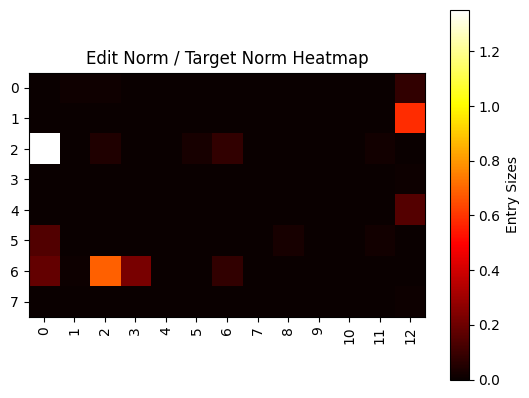

['In', ' the', ' store', ',', ' a', ' shiny', ' city', ' caught']


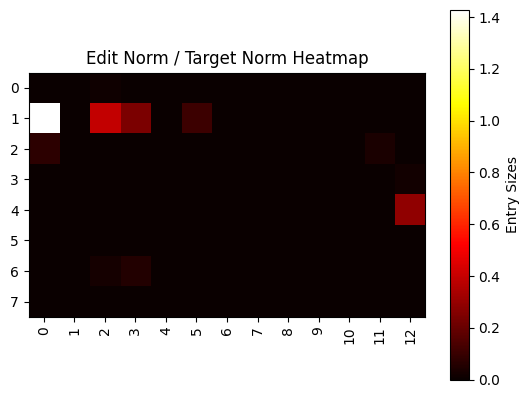

['The', ' bird', ' whispered', ' secrets', ' to', ' the', ' trees', '.']


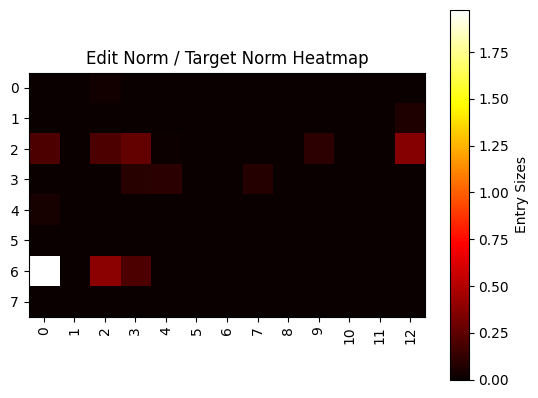

['In', ' the', ' cozy', ' star', ' by', ' the', ' sea', ',']


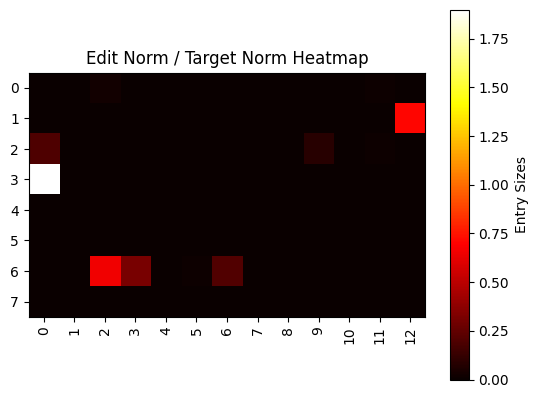

['In', ' the', ' quiet', ' night', ',', ' the', ' chair', ' softly']


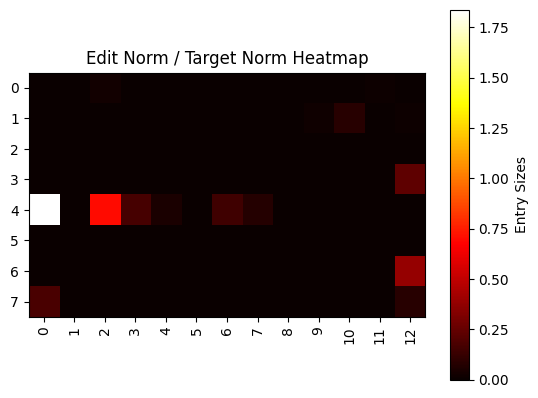

['B', 'ene', 'ath', ' the', ' chair', ',', ' the', ' children']


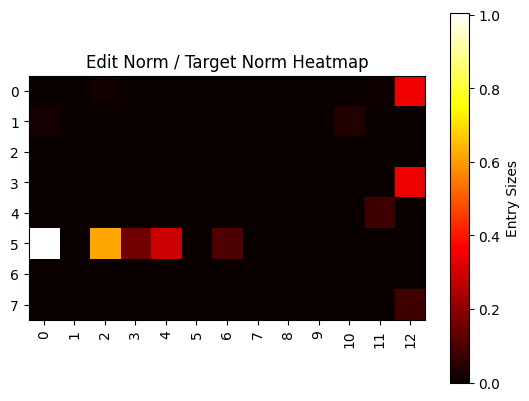

['B', 'ene', 'ath', ' the', ' old', ' computer', ',', ' the']


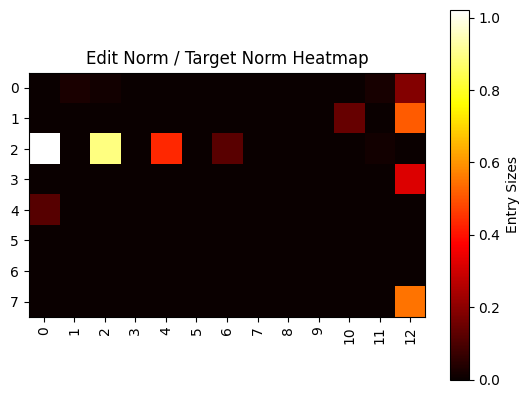

['My', ' loyal', ' bicycle', ' eagerly', ' awaits', ' my', ' return', '.']


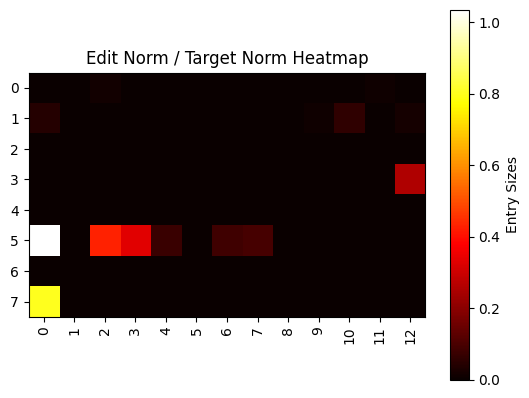

['B', 'ene', 'ath', ' the', ' old', ' mountain', ',', ' birds']


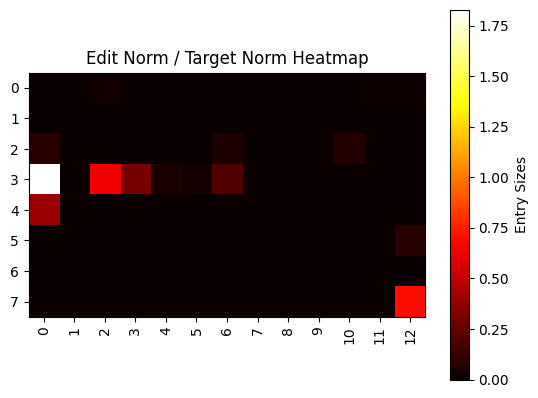

['A', ' shiny', ' red', ' chair', ' zoom', 'ed', ' down', ' the']


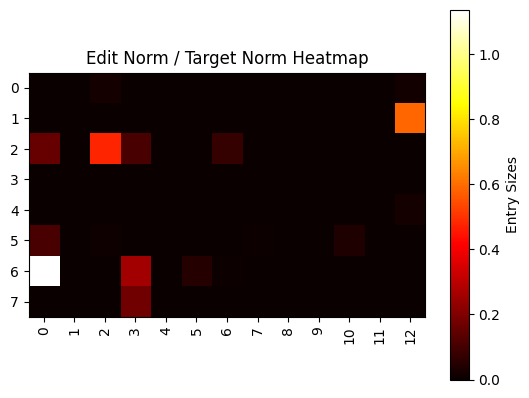

['In', ' the', ' forest', ',', ' a', ' tall', ' ocean', ' stood']


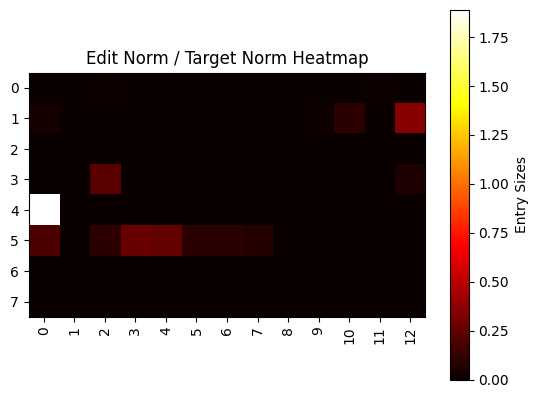

['B', 'ene', 'ath', ' the', ' ancient', ' star', ',', ' wild']


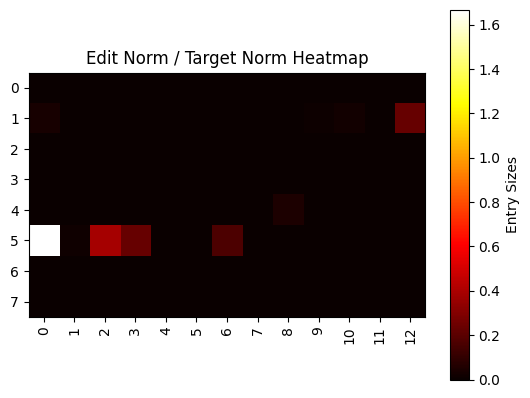

['B', 'ene', 'ath', ' the', ' silver', ' flower', ',', ' the']


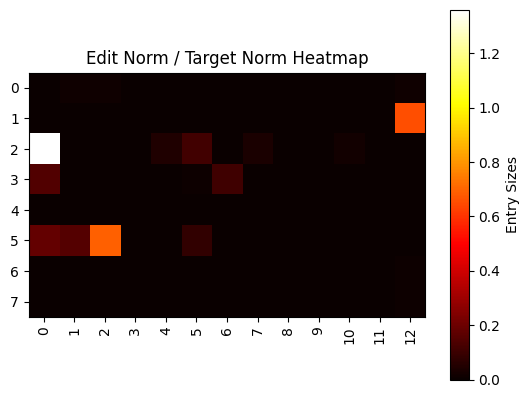

['In', ' a', ' red', ' convertible', ' sports', ' city', ',', ' she']


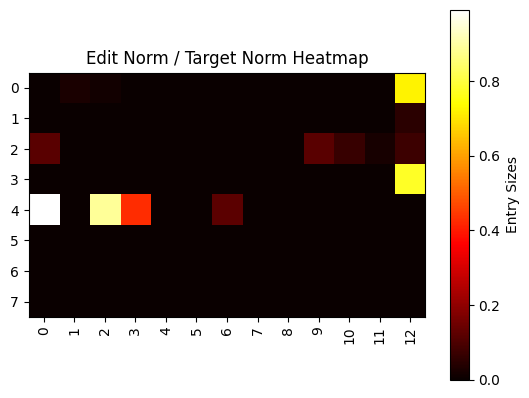

['In', ' the', ' quaint', ' little', ' bicycle', ' by', ' the', ' sea']


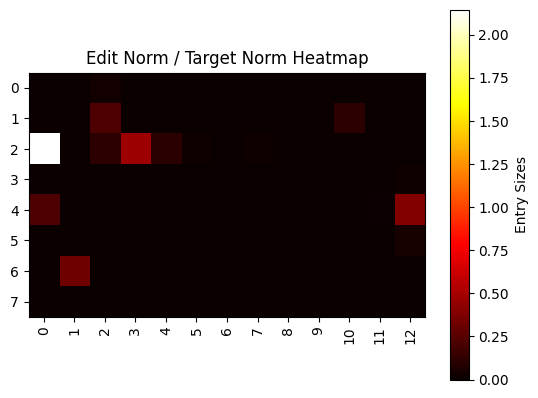

['The', ' loyal', ' star', ' eagerly', ' followed', ' his', ' owner', '.']


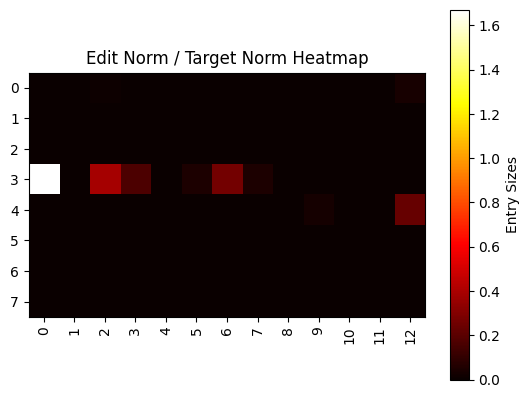

['Bat', 'hed', ' in', ' flower', 'light', ',', ' the', ' night']


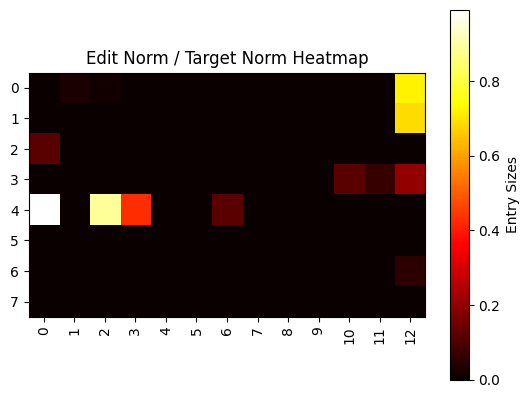

['In', ' the', ' grand', ' old', ' bicycle', ' by', ' the', ' sea']


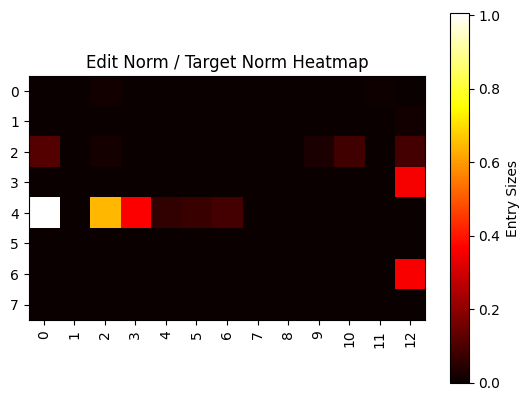

['In', ' the', ' cozy', ' little', ' computer', ' sat', ' a', ' cat']


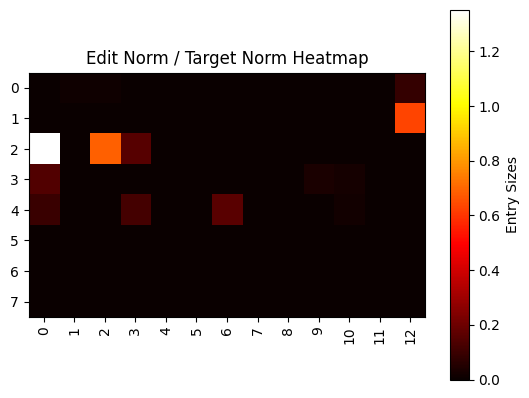

['Under', ' the', ' city', 'lit', ' sky', ',', ' love', ' bloss']


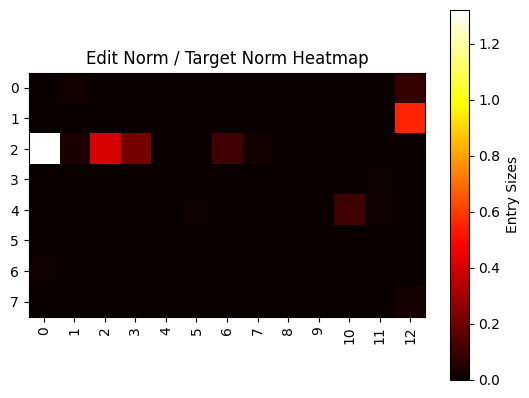

['In', ' a', ' cat', ' of', ' blue', ',', ' we', ' traveled']


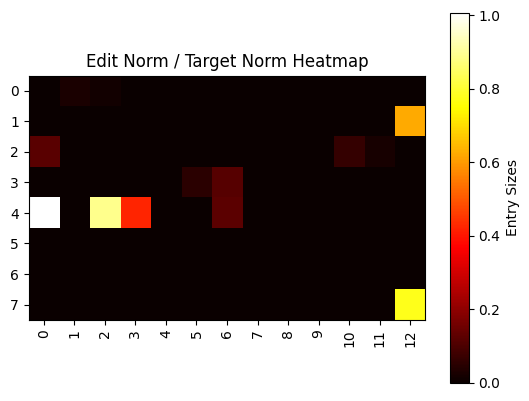

['In', ' a', ' shiny', ' red', ' bicycle', ',', ' we', ' sped']


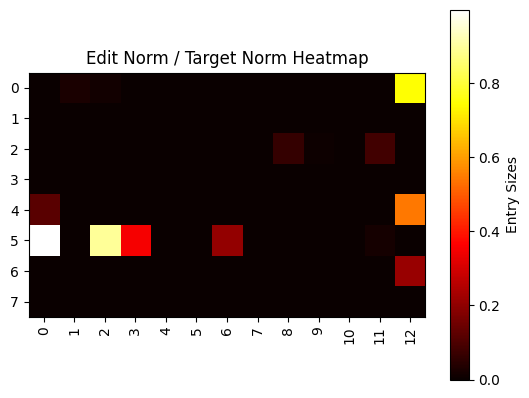

['Sl', 'ip', ' on', ' your', ' favorite', ' bicycle', ' and', ' dance']


In [ ]:
#This block calculates edit norm relative to the size of the current activations
import matplotlib.pyplot as plt
import numpy as np
for batch_index in range(len(batch["target_tokens"])):

    #The tensor norm comes in an 8x13 matrix
    edit_tensor = result["edit_vectors"][batch_index].to("cpu")
    edit_tensor[:8,:, :] = edit_tensor[:8,:,:]/result["target_hidden_states"][batch_index].norm(dim=2, keepdim=True) .to("cpu")
    edit_tensor_norm = edit_tensor.norm(dim=2)

    # is this any better??
    # attention_matrix = result['editor_attention'][batch_index].reshape(104).to("cpu").reshape(13,8).permute(1,0)

    # Detach and convert to numpy
    edit_tensor_norm = edit_tensor_norm.detach().numpy()[0:stopping_index, :]

    # Create the heatmap
    fig, ax = plt.subplots()
    heatmap = ax.imshow(edit_tensor_norm, cmap="hot")

    # Color the heatmap according to the entry sizes
    heatmap.set_clim(vmin=np.min(0), vmax=np.max(edit_tensor_norm))
    cbar = plt.colorbar(heatmap)
    cbar.set_label("Entry Sizes")

    # Add labels to the x and y axes
    ax.set_xticks(np.arange(13))
    ax.set_yticks(np.arange(8))
    ax.set_xticklabels(np.arange(13))
    ax.set_yticklabels(np.arange(8))

    # Rotate the x-axis labels
    plt.xticks(rotation=90)

    # Add a title
    plt.title("Edit Norm / Target Norm Heatmap")

    # Show the plot
    plt.show()

    print(tokenizer.batch_decode(batch["result_text"][batch_index][0:8]))

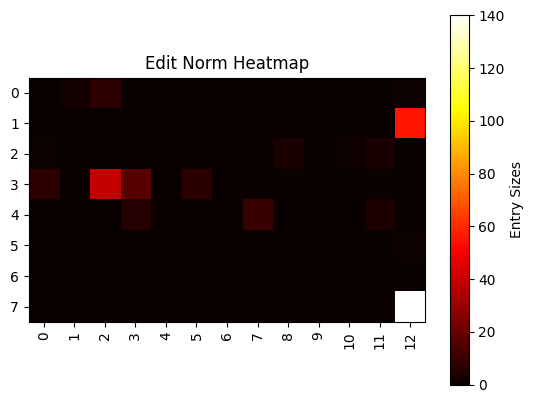

['In', ' a', ' shiny', ' city', ' box', ',', ' new', ' possibilities']


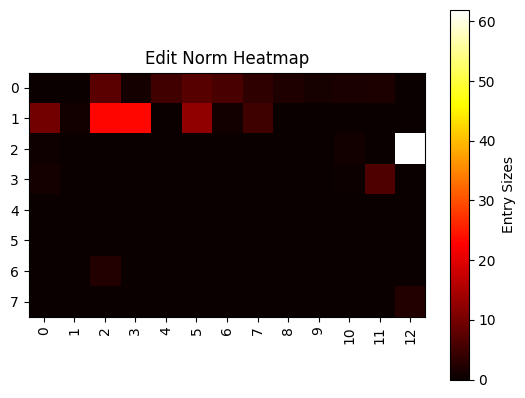

['The', ' flower', ' flowed', ' gently', ' through', ' the', ' valley', '.']


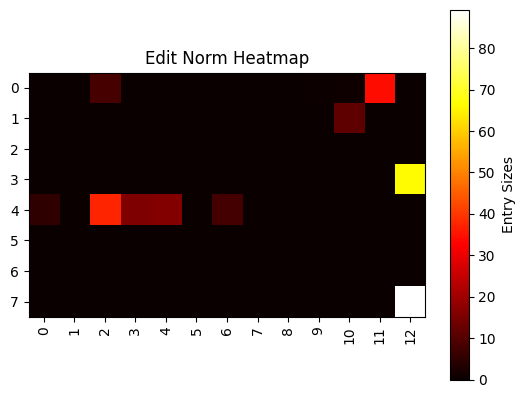

['B', 'ene', 'ath', ' the', ' computer', ',', ' the', ' children']


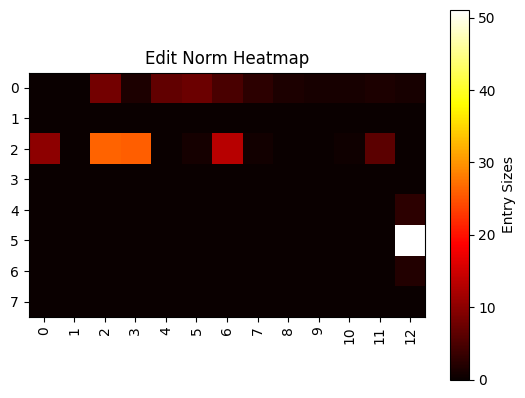

['On', ' the', ' flower', ',', ' she', ' whispered', ' a', ' secret']


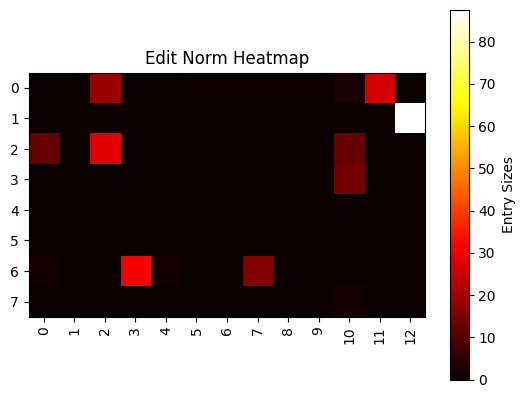

['In', ' the', ' morning', ' light', ',', ' the', ' star', ' gle']


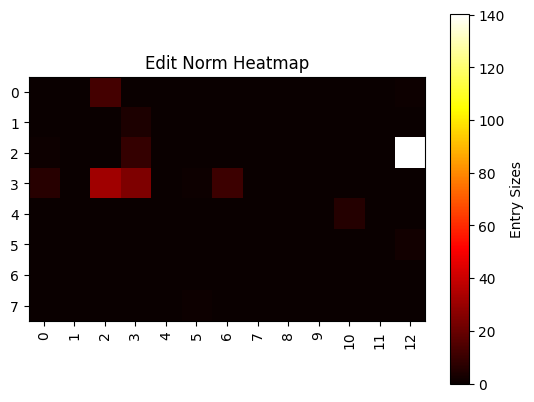

['In', ' my', ' favorite', ' ocean', ',', ' I', ' dance', ' grace']


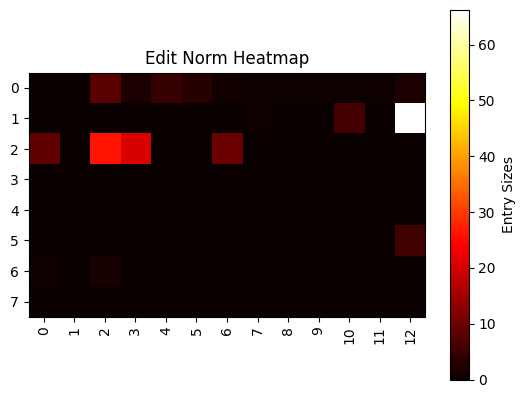

['A', ' delightful', ' bird', ' sat', ' on', ' the', ' table', ',']


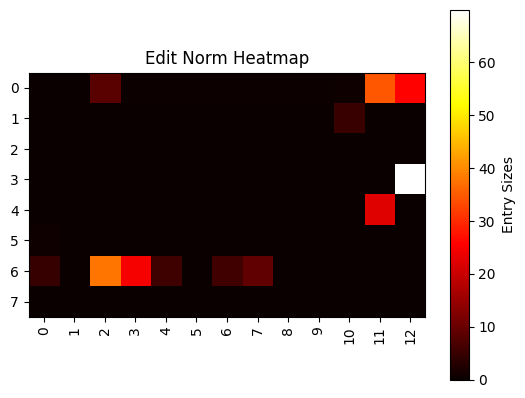

['B', 'ene', 'ath', ' the', ' old', ' oak', ' computer', ',']


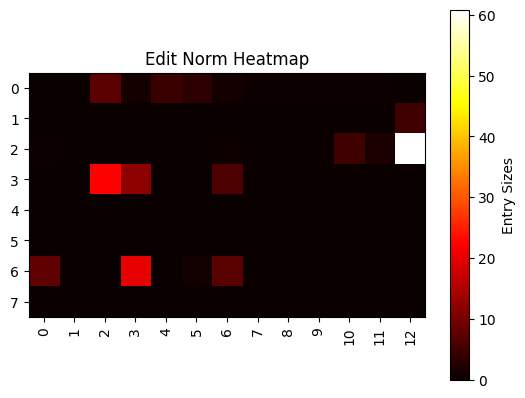

['In', ' the', ' Georgian', ' mansion', ',', ' the', ' bird', ' party']


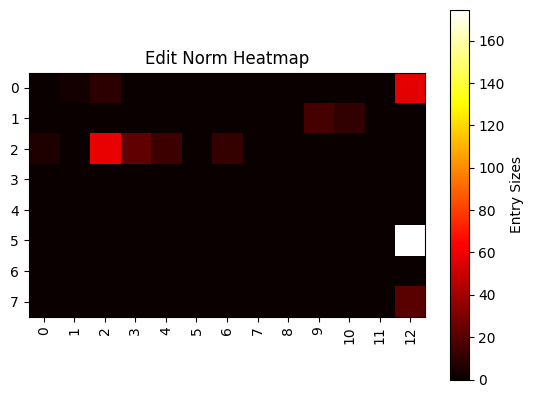

['A', ' faithful', ' bicycle', ' waits', ' for', ' his', ' master', '.']


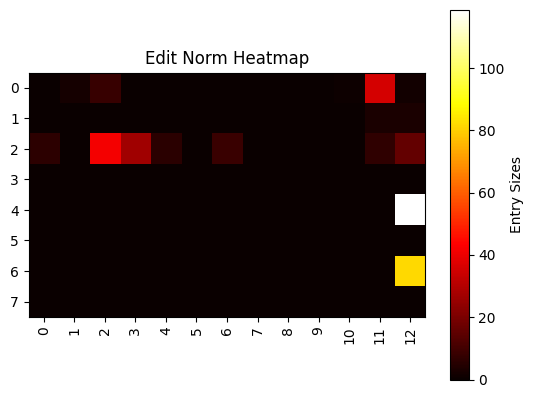

['On', ' the', ' computer', ',', ' she', ' heard', ' the', ' news']


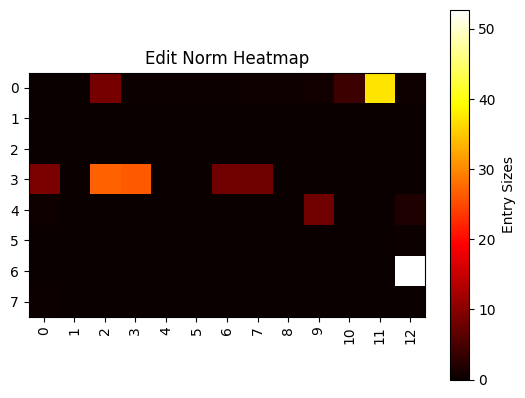

['Bat', 'hed', ' in', ' mountain', 'light', ',', ' the', ' night']


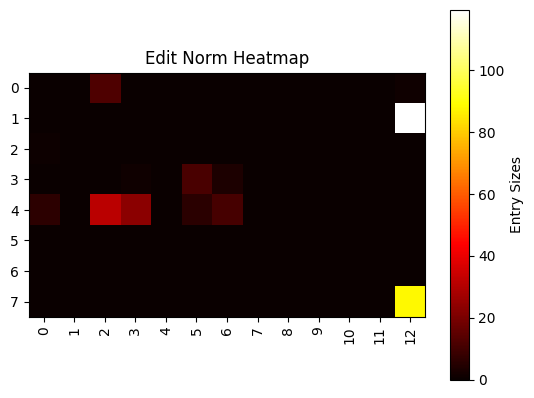

['In', ' a', ' shiny', ' red', ' ocean', ',', ' we', ' drove']


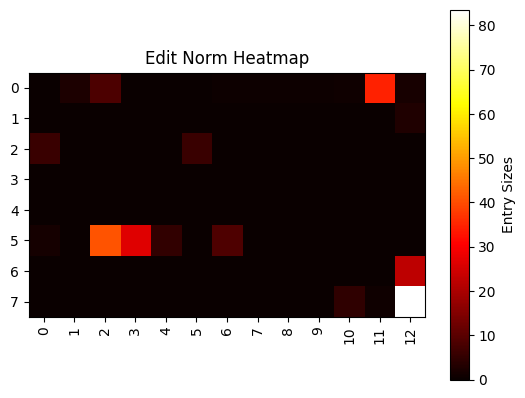

['In', ' the', ' sky', ',', ' the', ' computer', ' shone', ' brightly']


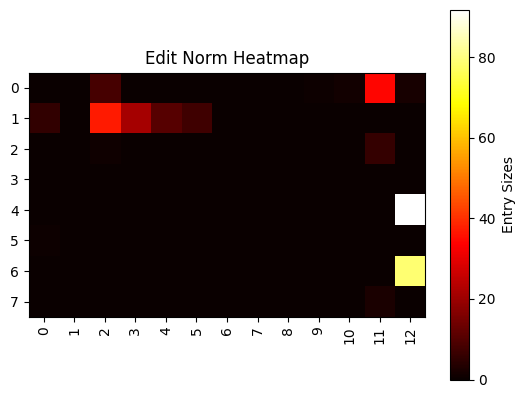

['The', ' computer', ' wound', ' grace', 'fully', ' through', ' the', ' valley']


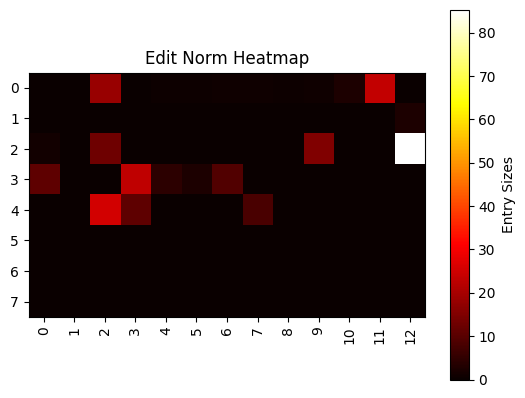

['On', ' the', ' elegant', ' star', ' rack', ',', ' lives', ' shine']


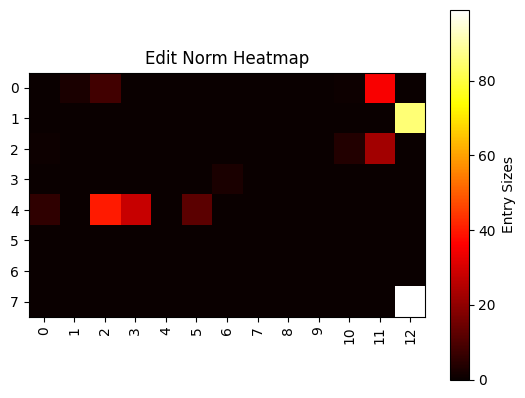

['In', ' her', ' sleek', ' red', ' computer', ',', ' she', ' sped']


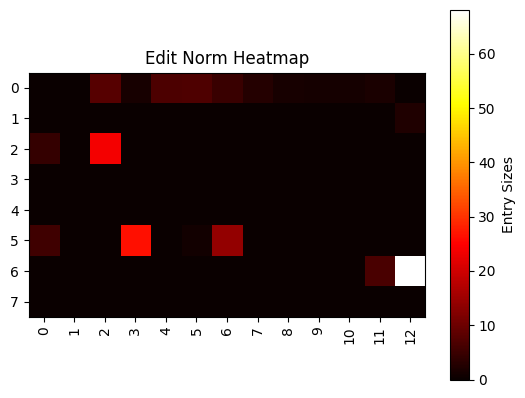

['In', ' the', ' city', ',', ' the', ' flower', ' sped', ' by']


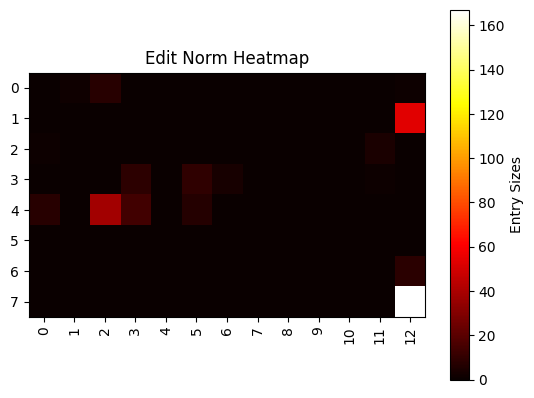

['In', ' a', ' shiny', ' red', ' city', ',', ' they', ' drove']


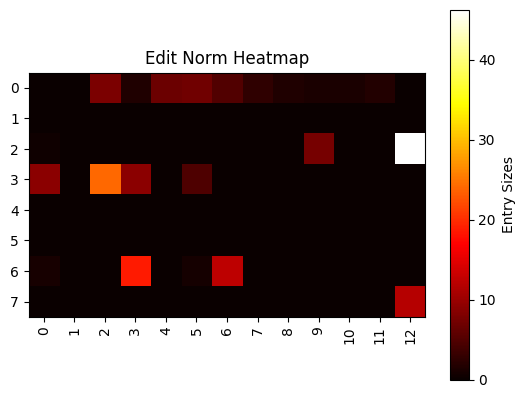

['In', ' the', ' crowded', ' street', ',', ' the', ' flower', ' sped']


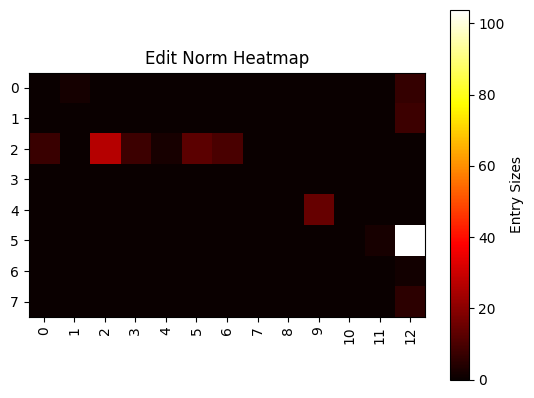

['On', ' the', ' cat', ' with', ' dear', ' friends', ',', ' we']


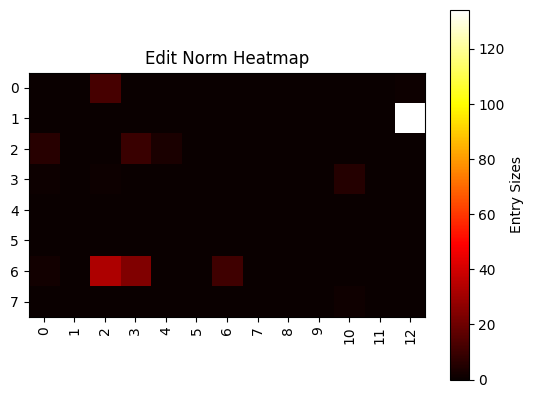

['In', ' the', ' morning', ' light', ',', ' the', ' ocean', ' gle']


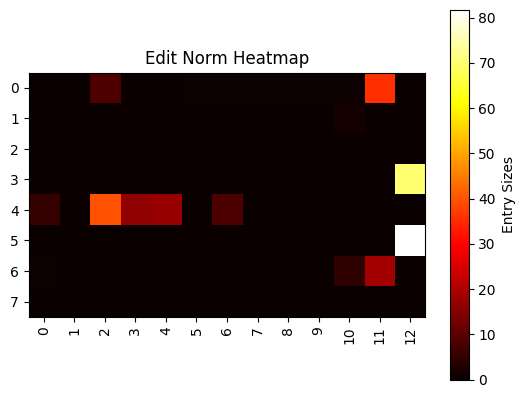

['B', 'ene', 'ath', ' the', ' computer', "'s", ' gentle', ' glow']


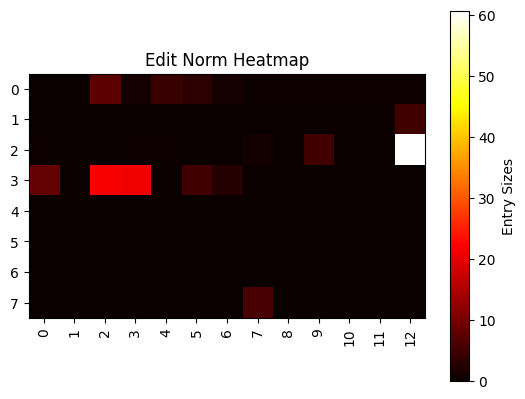

['In', ' the', ' cozy', ' bird', ',', ' the', ' fire', ' crack']


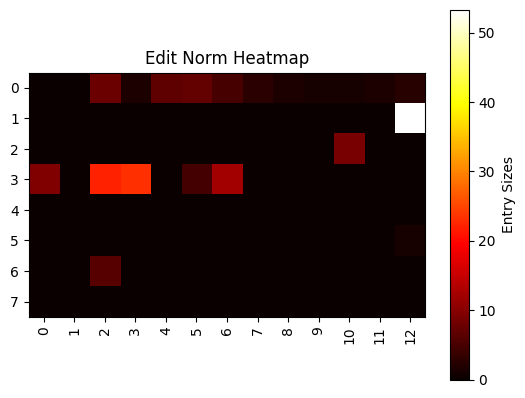

['In', ' a', ' fast', ' flower', ',', ' we', ' rode', ' through']


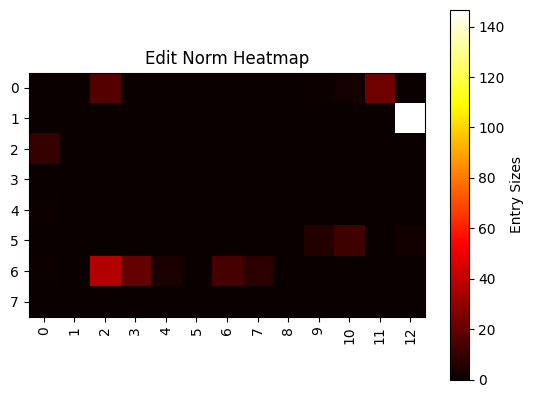

['In', ' the', ' old', ',', ' cre', 'aky', ' chair', ',']


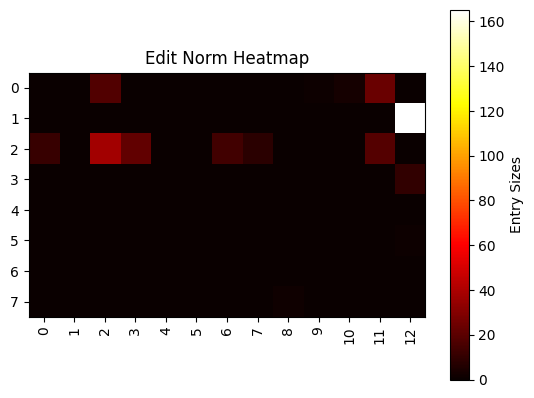

['In', ' her', ' chair', ',', ' she', ' traveled', ' along', ' the']


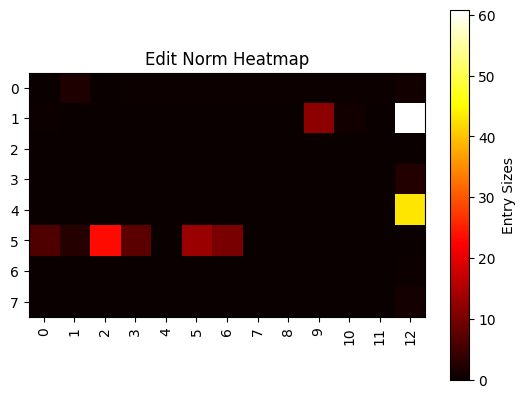

['B', 'ene', 'ath', ' the', ' towering', ' cat', ',', ' the']


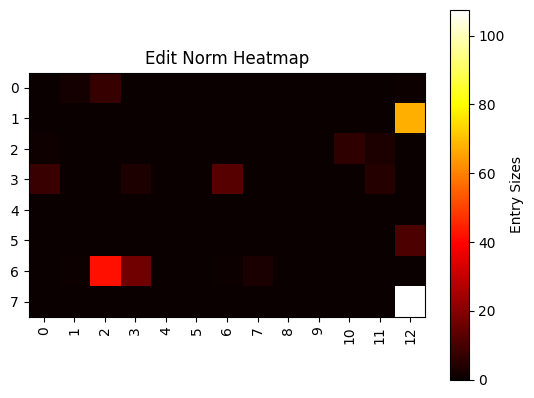

['In', ' a', ' quaint', ' village', ' sits', ' a', ' city', '.']


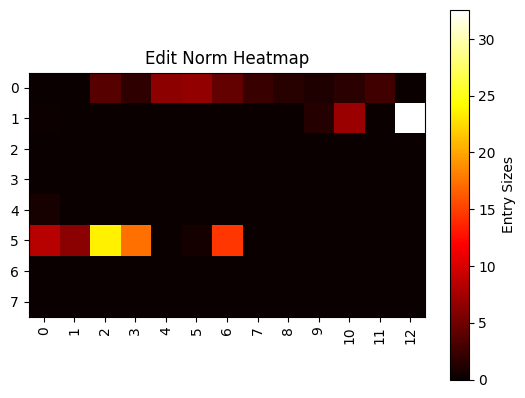

['B', 'ene', 'ath', ' the', ' tall', ' flower', ',', ' the']


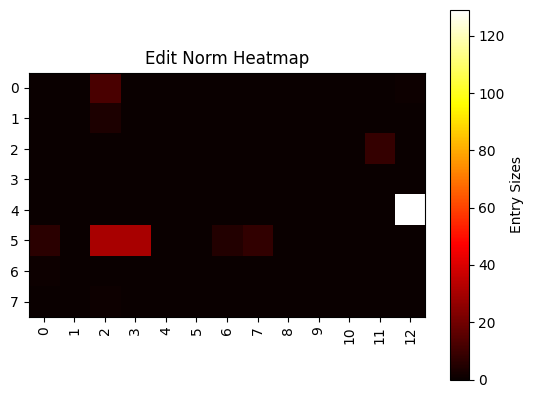

['In', ' every', ' step', ',', ' a', ' ocean', ' tells', ' tales']


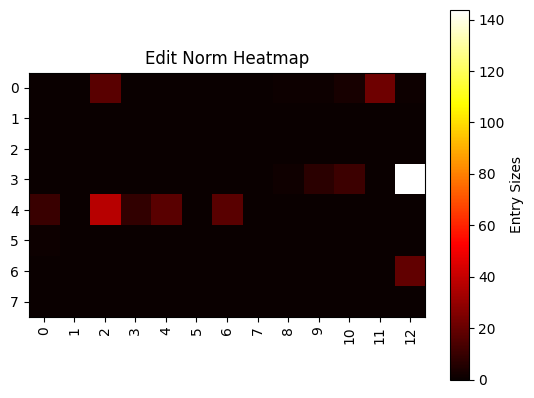

['A', ' de', 'lect', 'able', ' chair', ' awaited', ' guests', ' at']


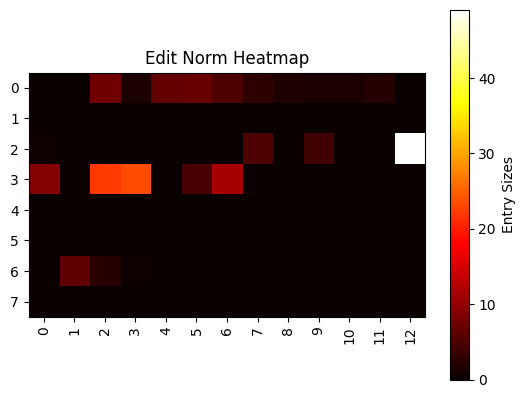

['In', ' the', ' cozy', ' flower', ' by', ' the', ' lake', ',']


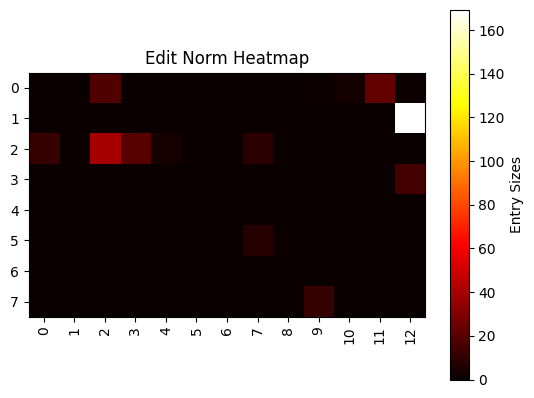

['On', ' the', ' chair', ',', ' her', ' voice', ' was', ' sweet']


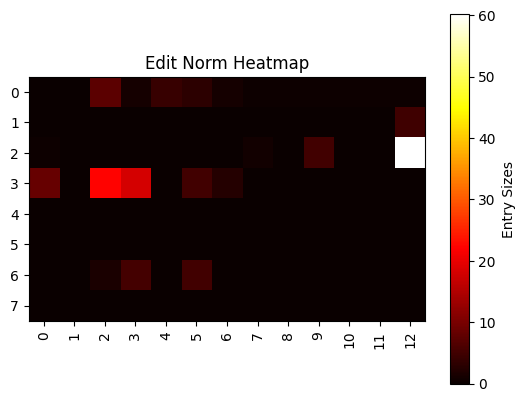

['In', ' the', ' cozy', ' bird', ' by', ' the', ' lake', ',']


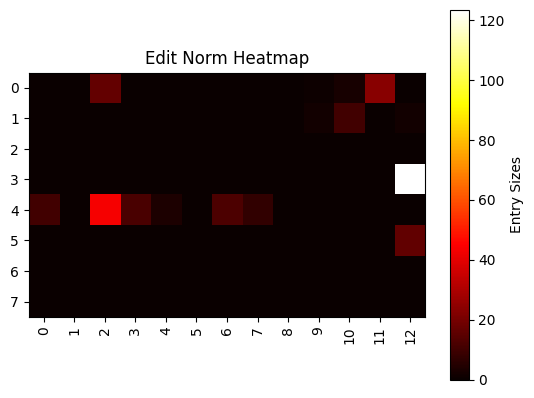

['B', 'ene', 'ath', ' the', ' chair', "'s", ' shade', ',']


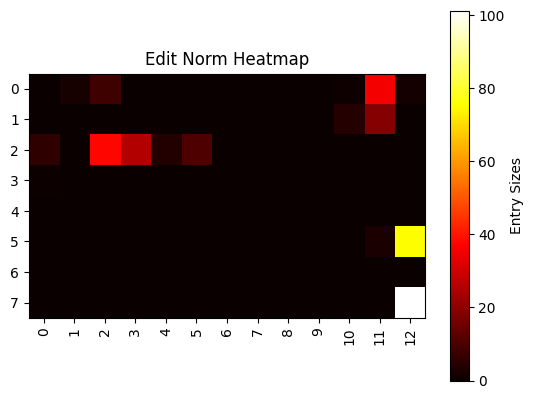

['A', ' loyal', ' computer', ' waits', ' by', ' the', ' door', '.']


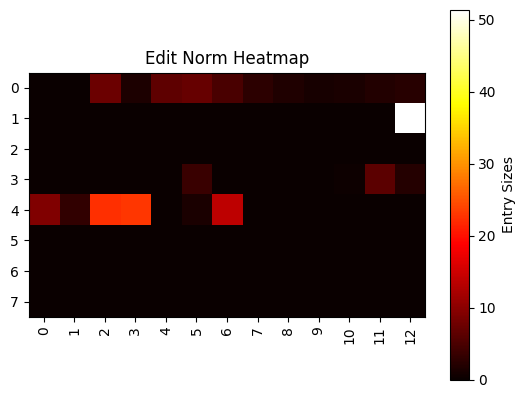

['In', ' the', ' big', ' blue', ' flower', ',', ' happiness', ' dwell']


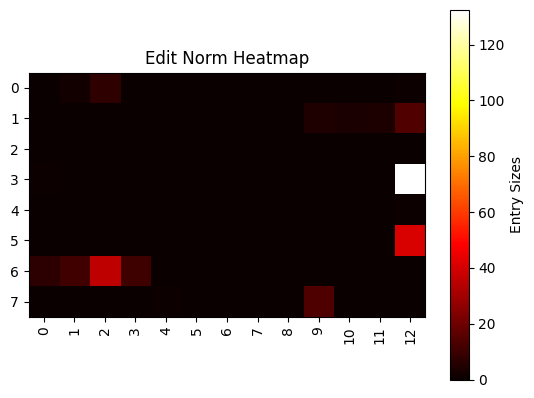

['Fl', 'owing', ' grace', 'fully', ',', ' the', ' city', ' spark']


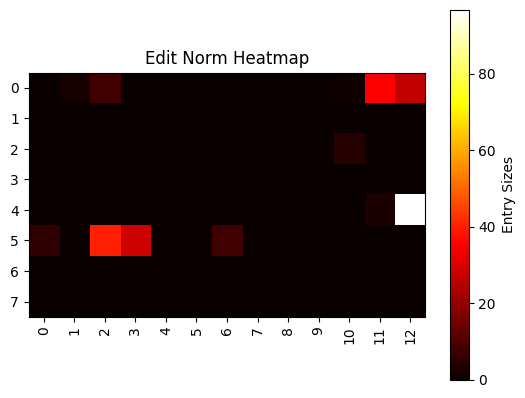

['With', ' a', ' kick', ' of', ' her', ' computer', ',', ' she']


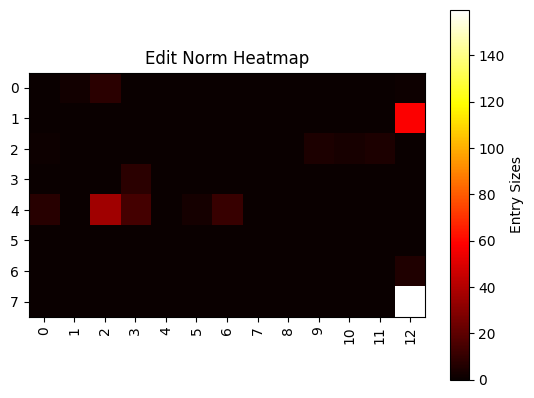

['In', ' a', ' sleek', ' silver', ' city', ',', ' they', ' raced']


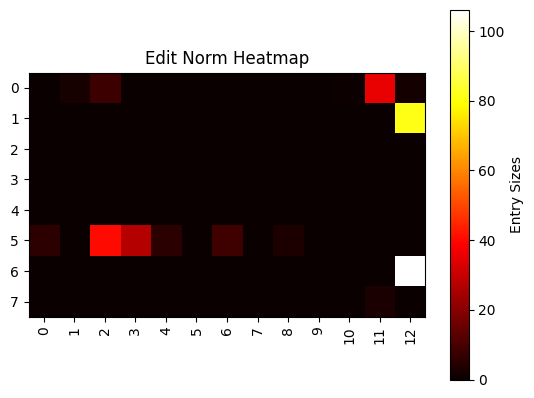

['In', ' a', ' flash', ',', ' the', ' computer', ' sped', ' by']


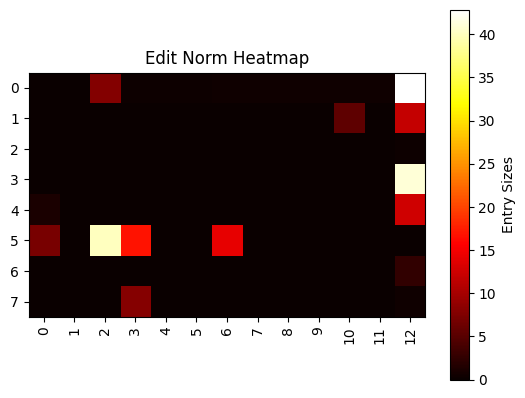

['B', 'ene', 'ath', ' the', ' mighty', ' city', ',', ' birds']


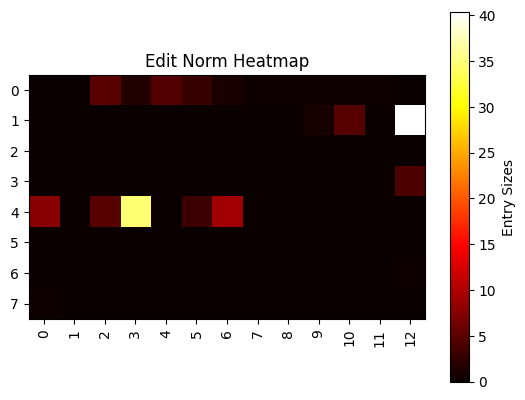

['B', 'ene', 'ath', ' the', ' bird', ',', ' the', ' birds']


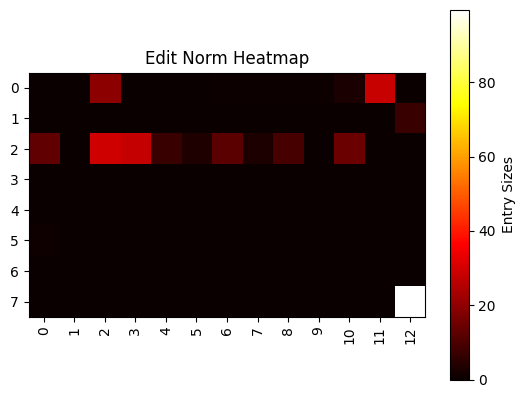

['With', ' a', ' ring', ',', ' the', ' star', ' interrupted', ' her']


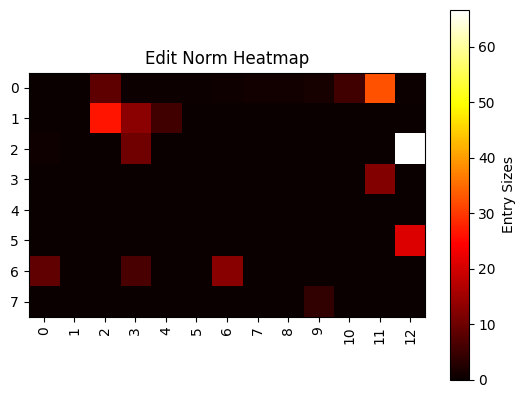

['The', ' mountain', ' flows', ' gently', ' under', ' the', ' moon', 'light']


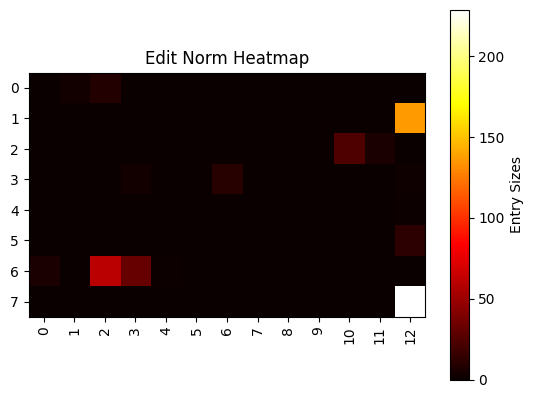

['In', ' the', ' fast', ' lane', ',', ' the', ' bicycle', ' speeds']


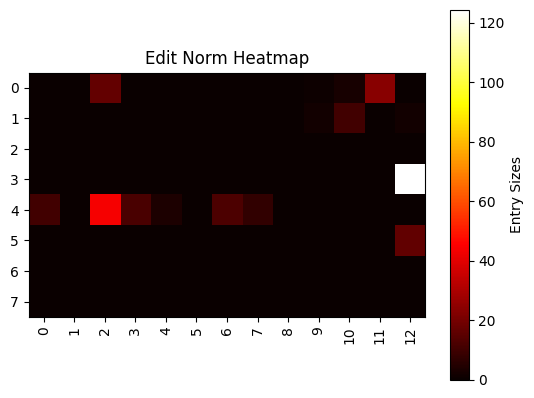

['B', 'ene', 'ath', ' the', ' chair', "'s", ' shade', ',']


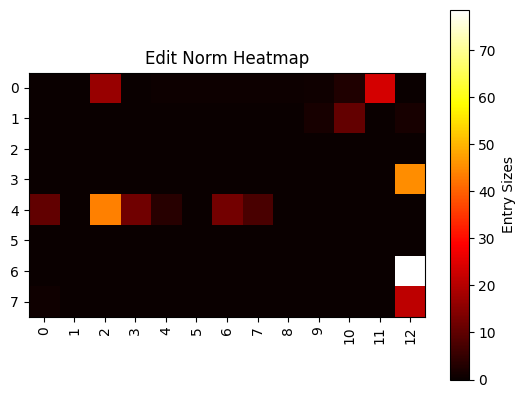

['B', 'ene', 'ath', ' the', ' chair', ',', ' the', ' children']


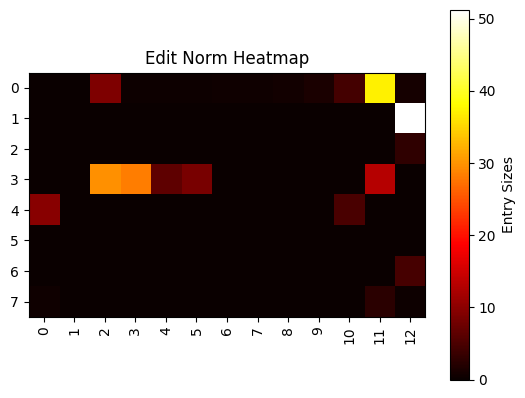

['Upon', ' hearing', ' the', ' mountain', ' ring', ',', ' she', ' jumped']


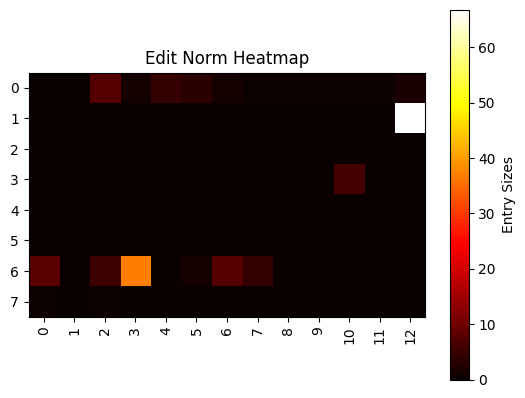

['In', ' the', ' morning', ' light', ',', ' her', ' bird', ' gl']


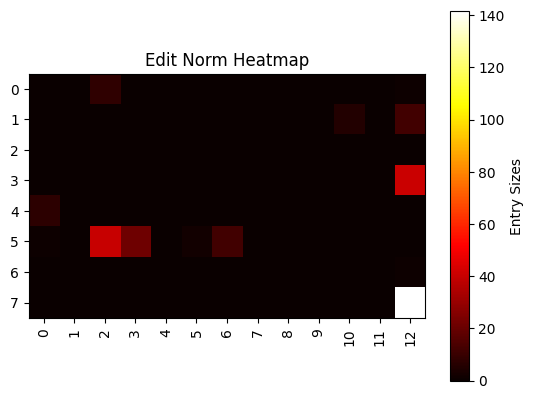

['B', 'ene', 'ath', ' the', ' tall', ' city', ',', ' children']


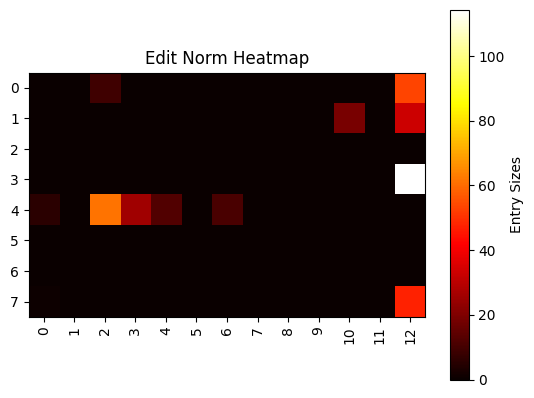

['B', 'ene', 'ath', ' the', ' bicycle', ',', ' the', ' stars']


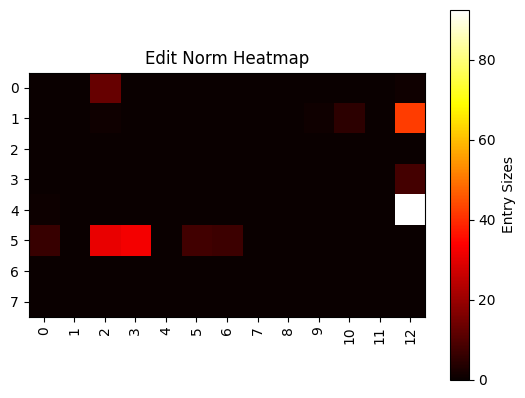

['B', 'ene', 'ath', ' the', ' towering', ' ocean', ',', ' the']


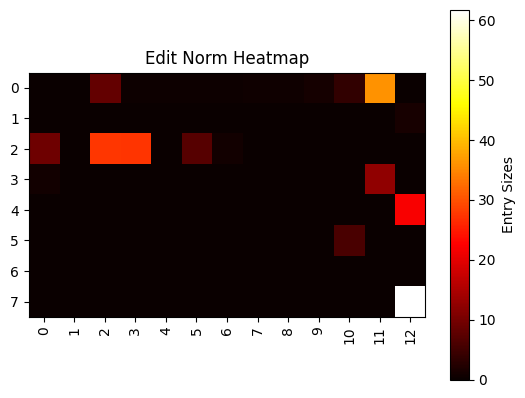

['In', ' my', ' mountain', ' lies', ' a', ' hidden', ' note', '.']


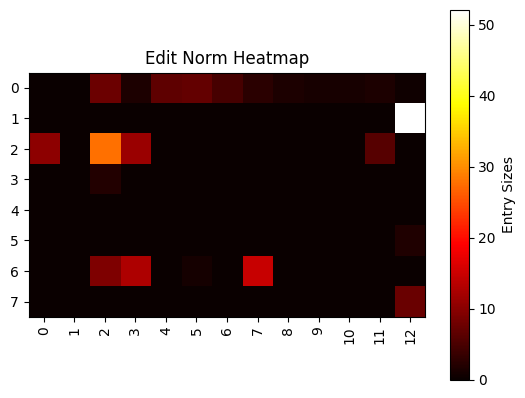

['In', ' the', ' bakery', ' window', ' displayed', ' a', ' flower', '.']


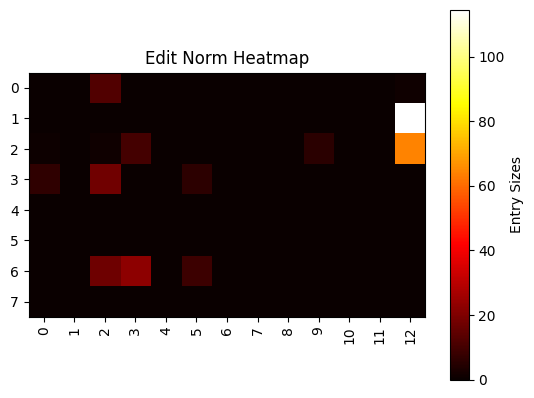

['In', ' the', ' cozy', ' ocean', ' by', ' the', ' lake', '.']


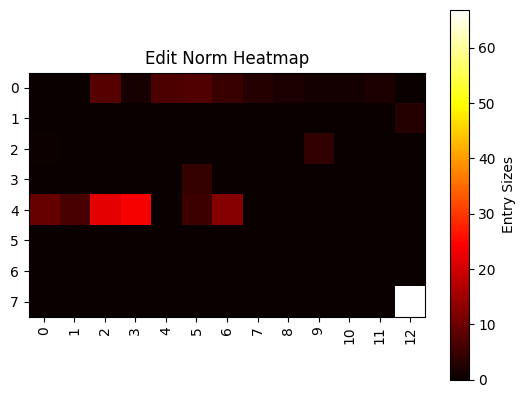

['In', ' a', ' sleek', ' red', ' flower', ',', ' she', ' sped']


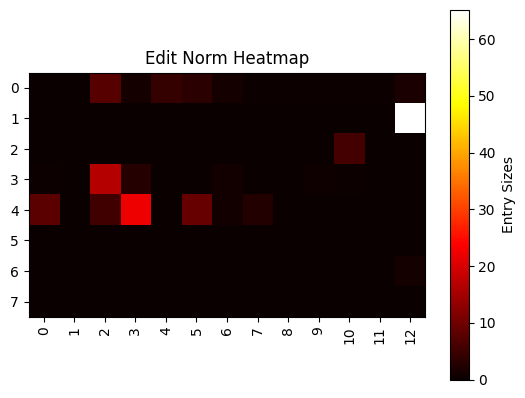

['In', ' the', ' old', ' brick', ' bird', ' lived', ' a', ' family']


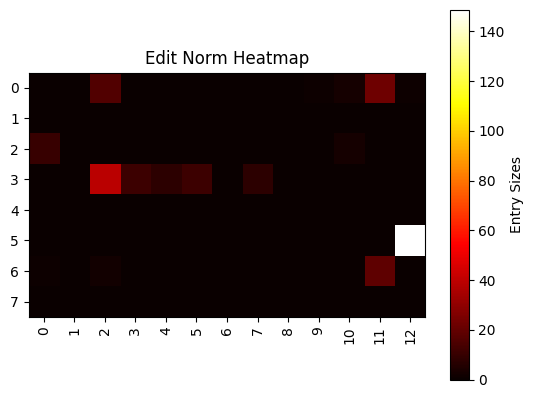

['In', ' the', ' grand', ' chair', ' on', ' the', ' hill', ',']


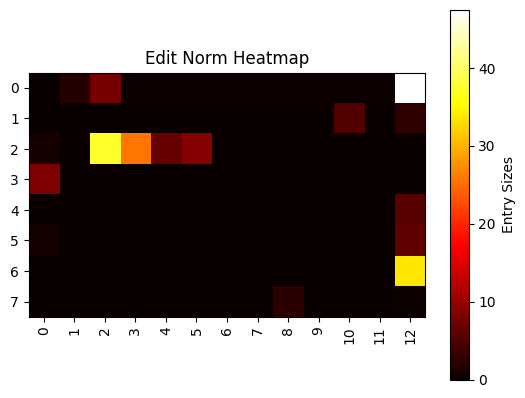

['The', ' loyal', ' city', ' bark', 'ed', ' happily', ' at', ' twilight']


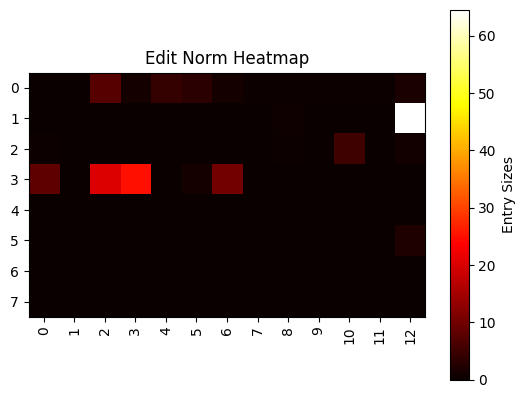

['In', ' the', ' oldest', ' bird', ' on', ' the', ' block', '.']


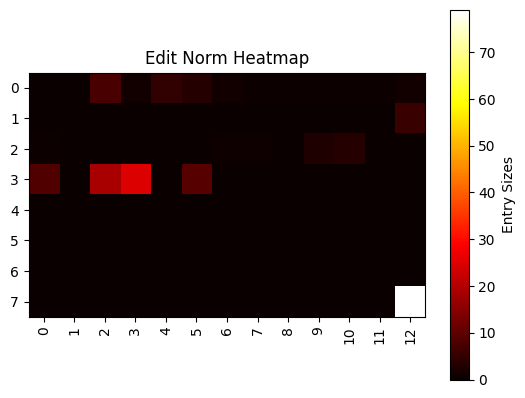

['In', ' her', ' sleek', ' bird', ',', ' she', ' zoom', 'ed']


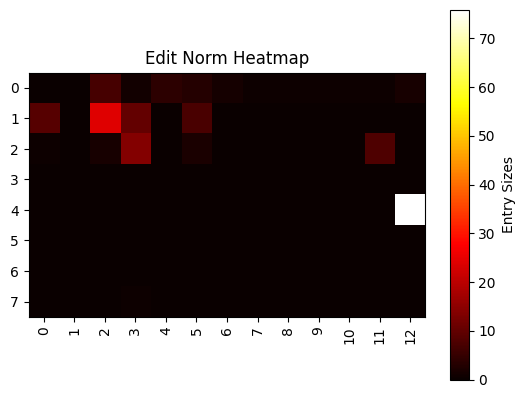

['The', ' bird', ' snakes', ' grace', 'fully', ' through', ' the', ' valley']


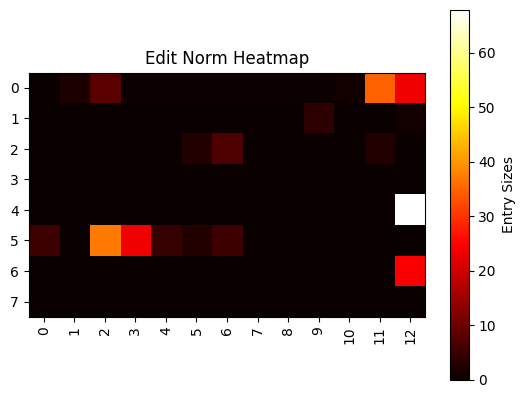

['Through', ' tangled', ' woods', ',', ' the', ' computer', ' gently', ' sings']


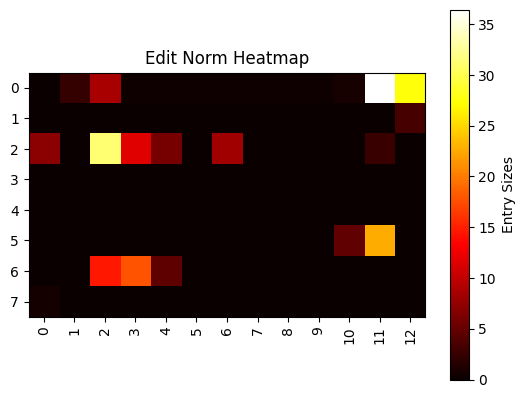

['Upon', ' the', ' moon', ',', ' the', ' lonely', ' computer', ' waits']


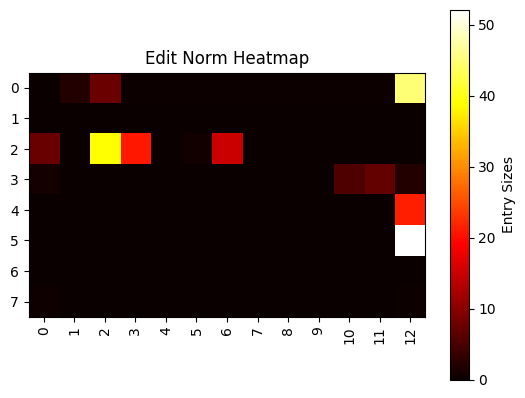

['The', ' golden', ' city', ' lit', ' up', ' the', ' night', ' sky']


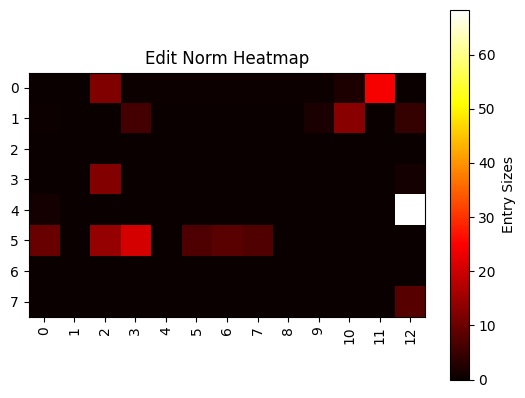

['B', 'ene', 'ath', ' the', ' towering', ' star', ',', ' the']


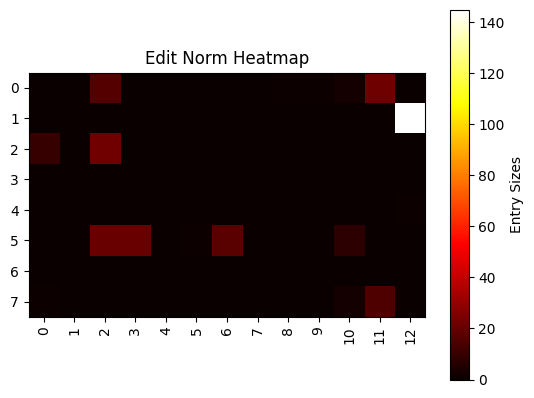

['In', ' the', ' forest', ',', ' a', ' chair', ' stood', ' tall']


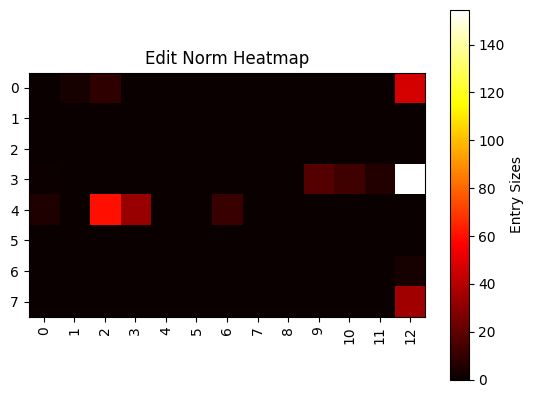

['Under', 'neath', ' the', ' lofty', ' bicycle', ',', ' the', ' children']


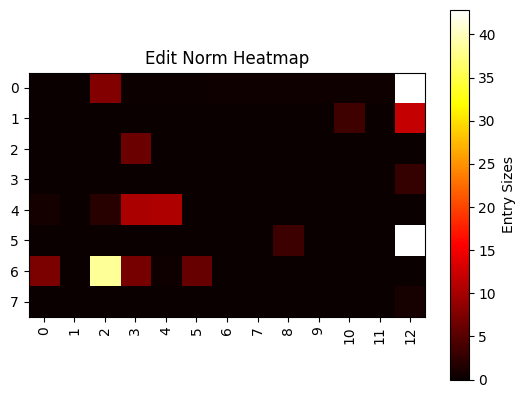

['B', 'ene', 'ath', ' the', ' sway', 'ing', ' city', ',']


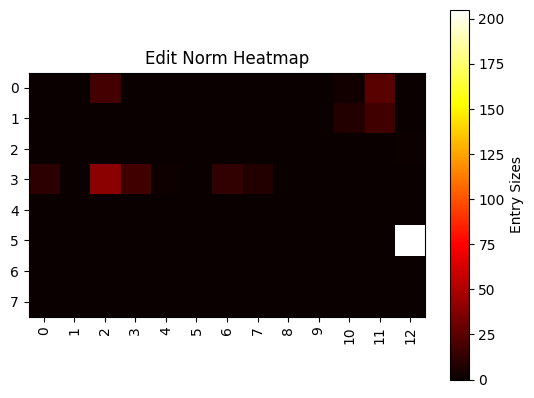

['Travel', 'ing', ' by', ' chair', ',', ' they', ' embarked', ' on']


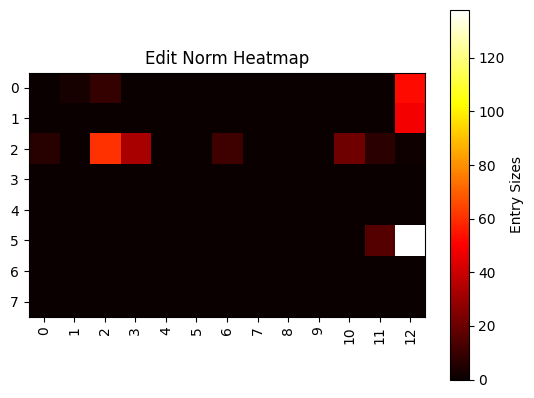

['On', ' the', ' bicycle', ',', ' she', ' whispered', ' her', ' secrets']


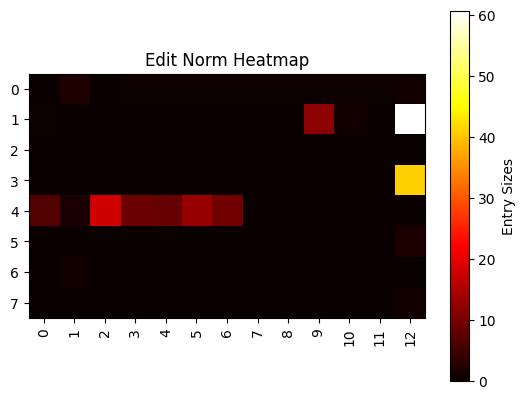

['B', 'ene', 'ath', ' the', ' cat', ',', ' birds', ' sang']


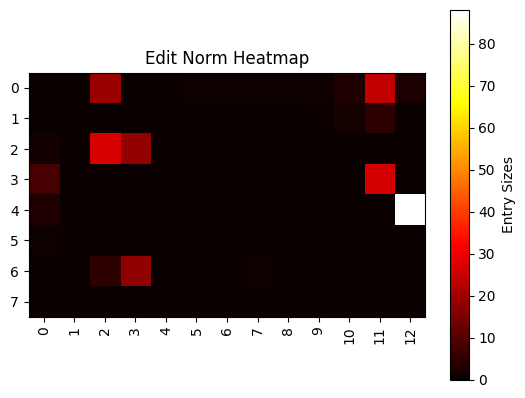

['Within', ' the', ' pages', ' of', ' her', ' favorite', ' star', ',']


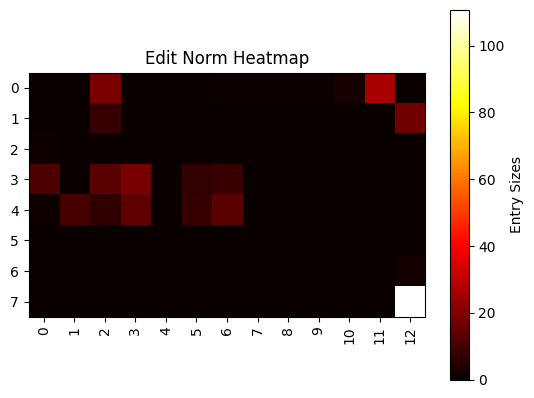

['In', ' a', ' shiny', ' red', ' star', ',', ' they', ' sped']


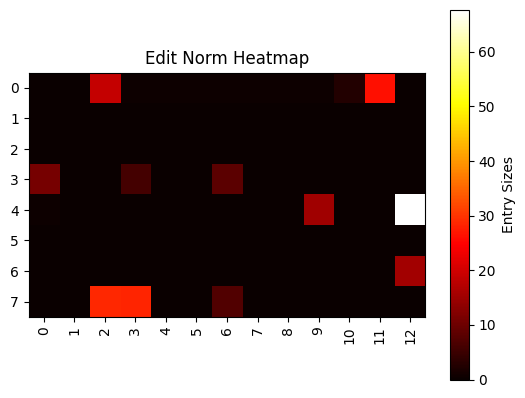

['Bat', 'hed', ' in', ' star', 'light', ',', ' the', ' garden']


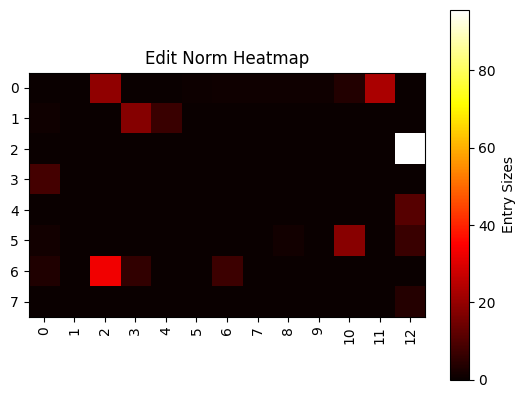

['The', ' star', ' raced', ' down', ' the', ' winding', ' road', '.']


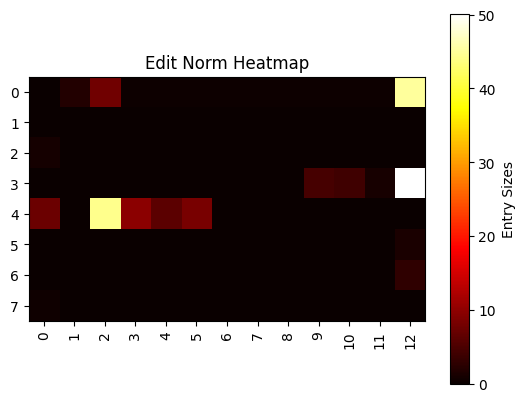

['A', ' de', 'lect', 'able', ' city', ' awaited', ' the', ' birthday']


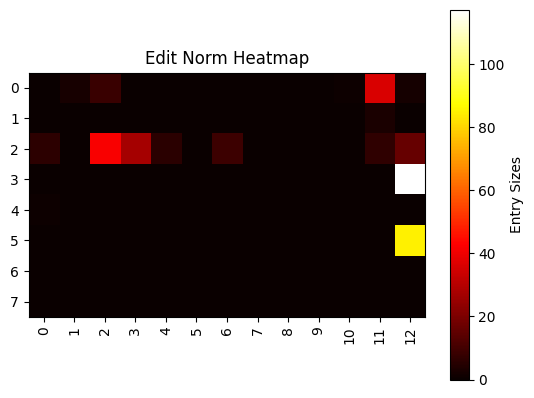

['On', ' the', ' computer', ' she', ' read', ' her', ' poetry', '.']


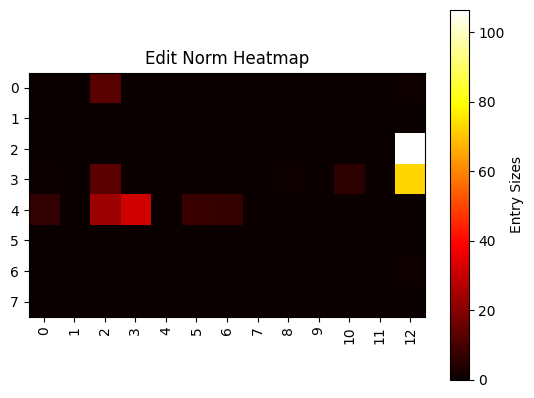

['Down', ' by', ' the', ' winding', ' ocean', ',', ' we', ' st']


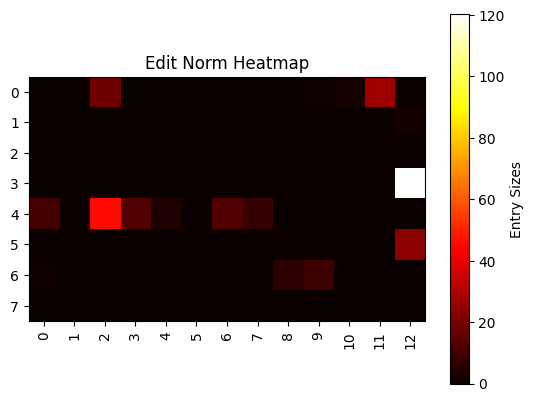

['B', 'ene', 'ath', ' the', ' chair', "'s", ' gentle', ' glow']


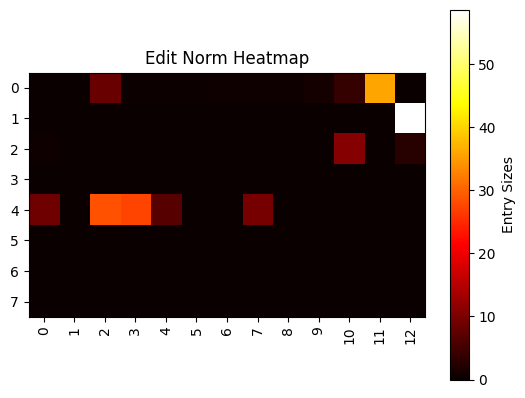

['In', ' the', ' charming', ' old', ' mountain', ' near', ' town', ',']


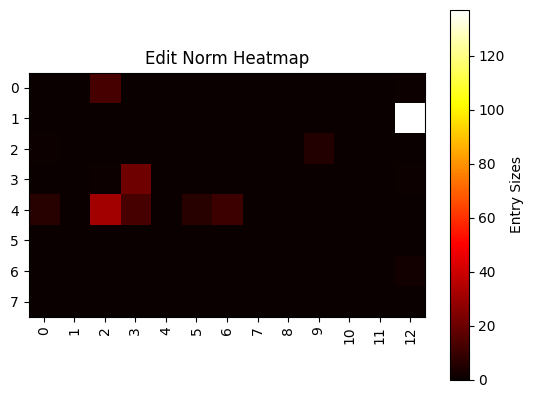

['In', ' a', ' sleek', ' red', ' ocean', ',', ' they', ' zoom']


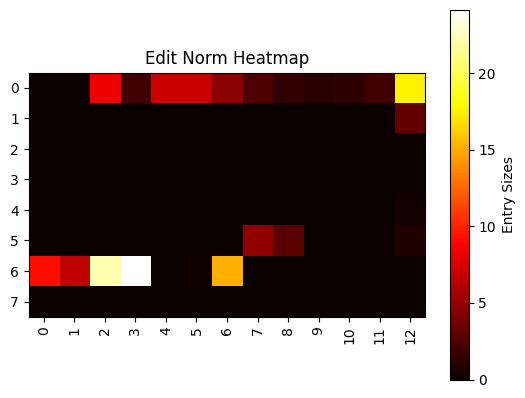

['As', ' I', ' reached', ' for', ' the', ' ringing', ' flower', ',...']


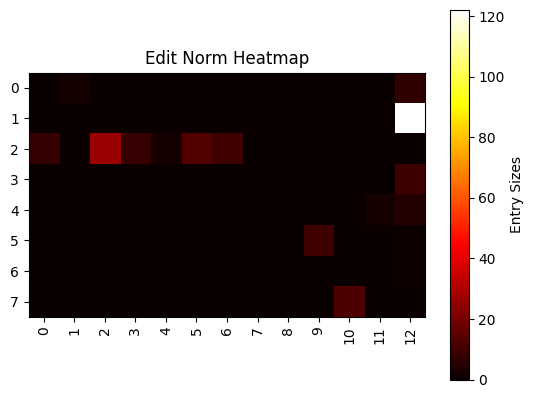

['On', ' the', ' cat', ',', ' we', ' shared', ' our', ' dreams']


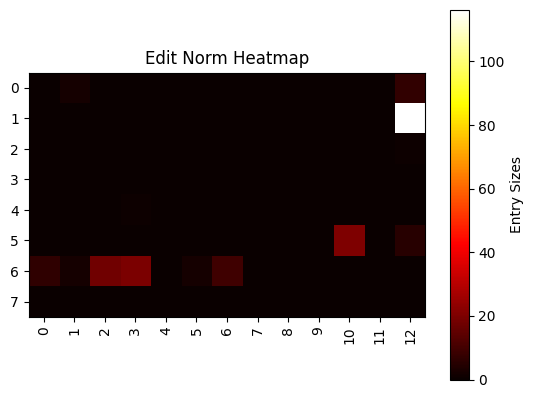

['In', ' the', ' old', ',', ' cre', 'aky', ' cat', ',']


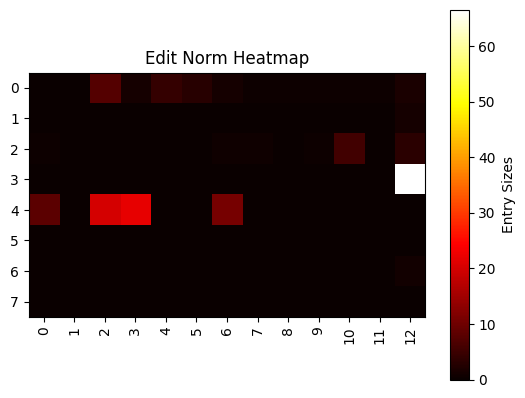

['In', ' that', ' charming', ' little', ' bird', ' by', ' the', ' coast']


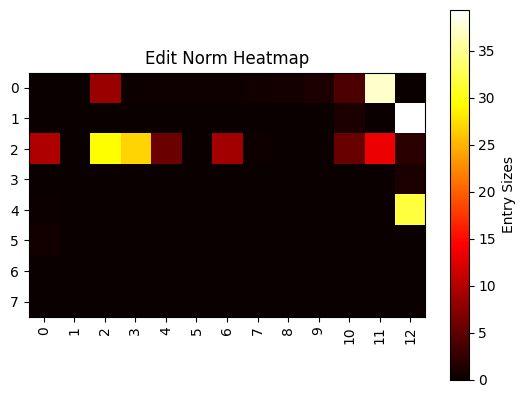

['On', ' the', ' mountain', ',', ' she', ' shared', ' her', ' secrets']


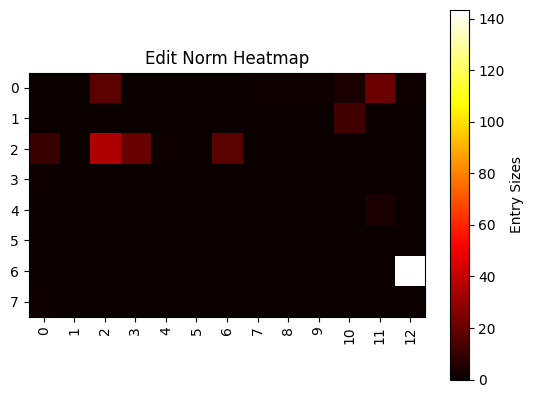

['A', ' loyal', ' chair', ' waits', ' patiently', ' by', ' the', ' door']


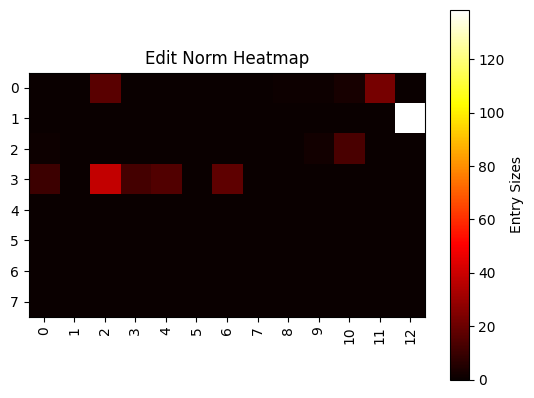

['Like', ' a', ' gentle', ' chair', ',', ' her', ' mind', ' flowed']


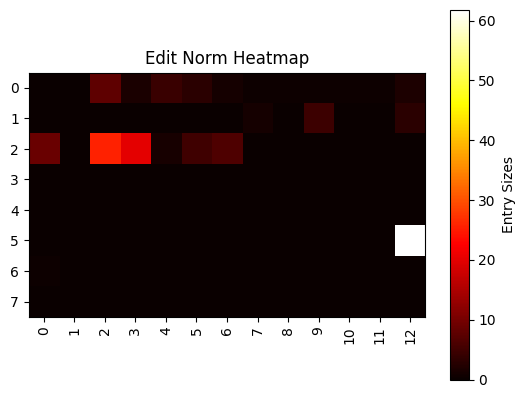

['A', ' delicious', ' bird', ' sat', ' on', ' the', ' kitchen', ' counter']


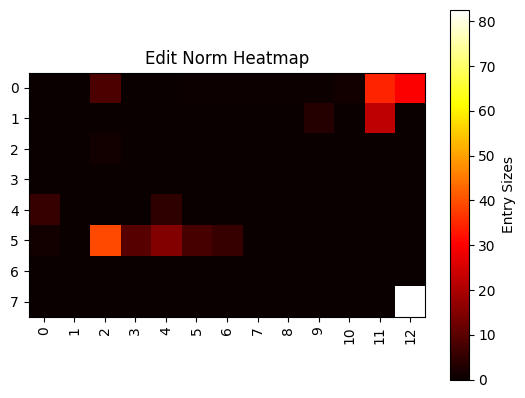

['The', ' delicious', ' aroma', ' of', ' baking', ' computer', ' fills', ' the']


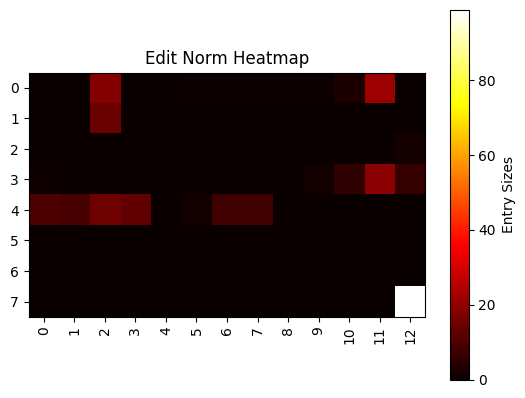

['Down', ' by', ' the', ' rolling', ' star', ',', ' she', ' danced']


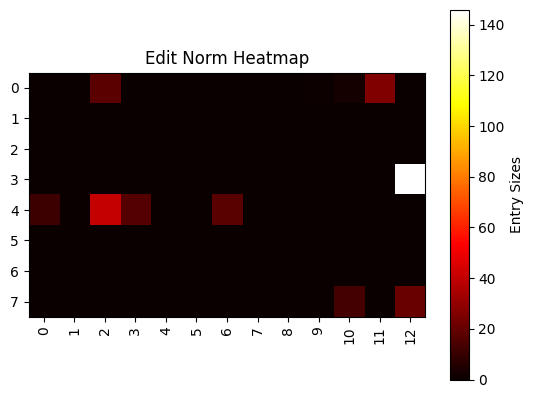

['Bat', 'hing', ' in', ' the', ' chair', "'s", ' e', 'thereal']


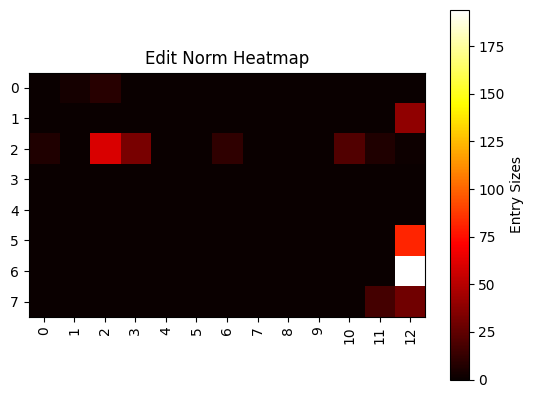

['On', ' the', ' bicycle', ',', ' she', ' whispered', ' secrets', ' to']


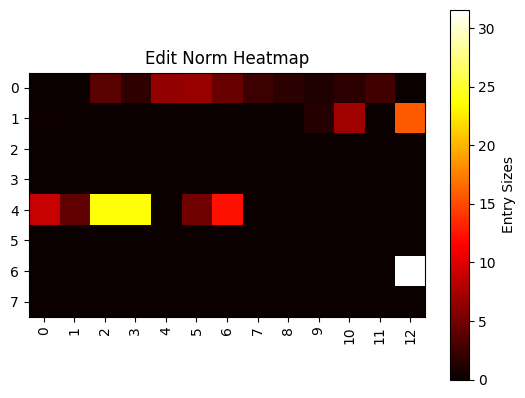

['B', 'ene', 'ath', ' the', ' flower', ',', ' children', ' played']


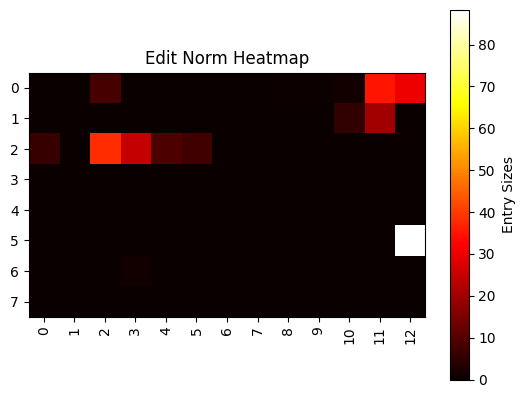

['The', ' friendly', ' computer', ' w', 'agged', ' its', ' tail', ' happily']


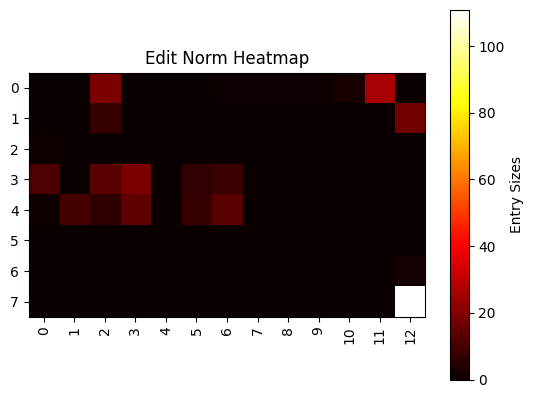

['In', ' a', ' shiny', ' red', ' star', ',', ' they', ' sped']


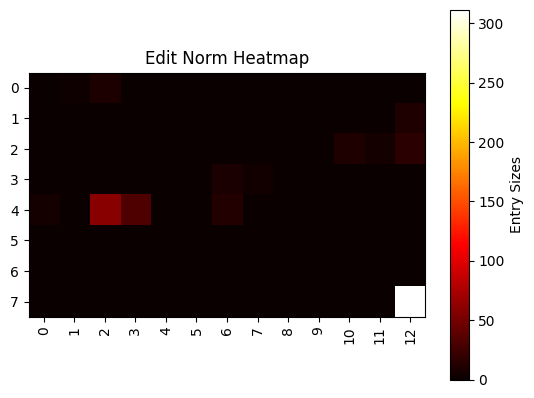

['In', ' his', ' shiny', ' red', ' bicycle', ',', ' James', ' sped']


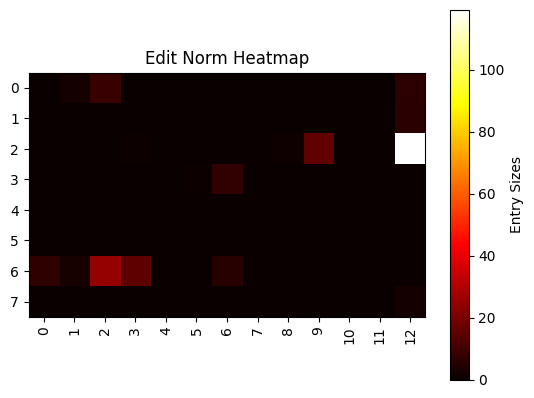

['In', ' the', ' glowing', ' sunset', ',', ' the', ' cat', ' gently']


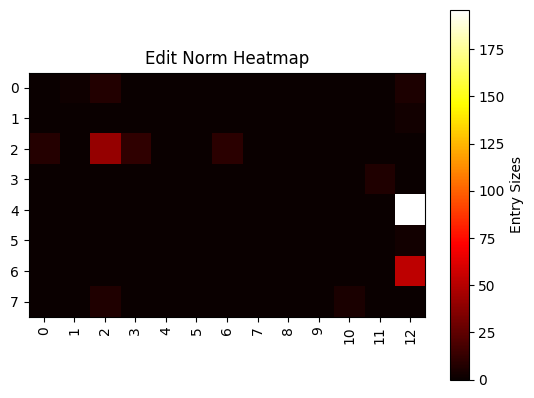

['On', ' my', ' city', ',', ' I', ' heard', ' a', ' ch']


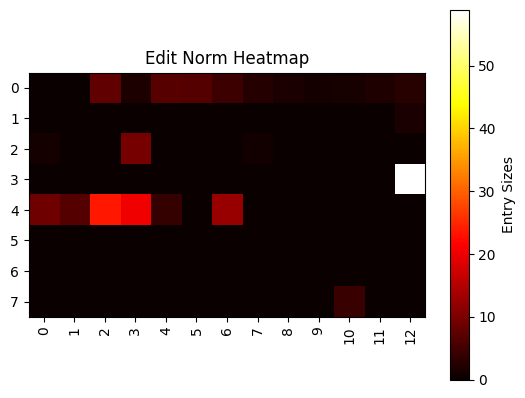

['Let', "'s", ' bake', ' a', ' flower', ' that', "'s", ' divine']


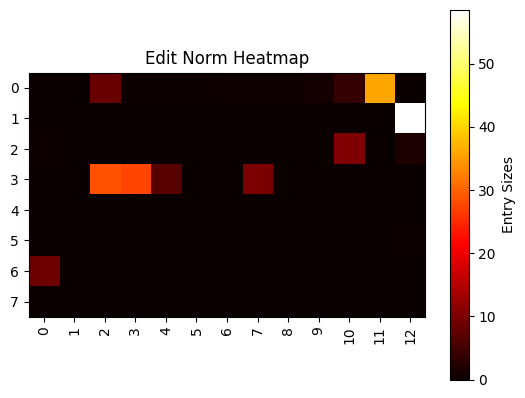

['In', ' the', ' old', ' mountain', ' by', ' the', ' sea', ',']


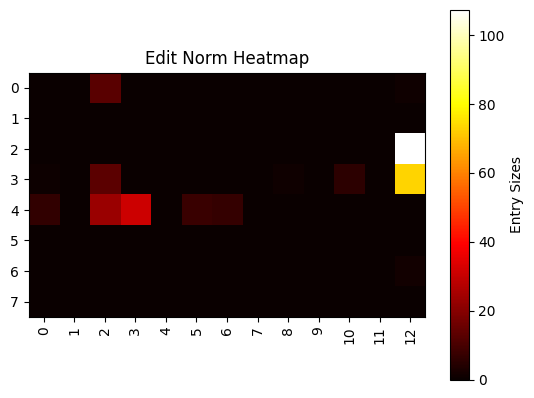

['Down', ' by', ' the', ' winding', ' ocean', ',', ' we', ' sang']


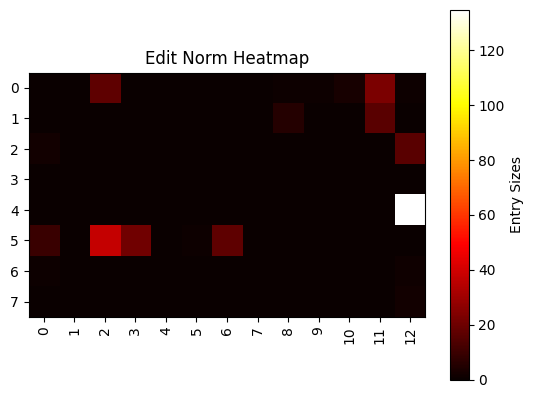

['Through', ' winding', ' paths', ',', ' the', ' chair', ' flows', '.']


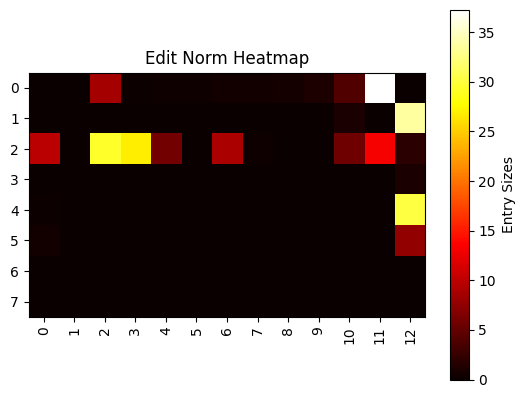

['On', ' the', ' mountain', ',', ' she', ' whispered', ' her', ' secrets']


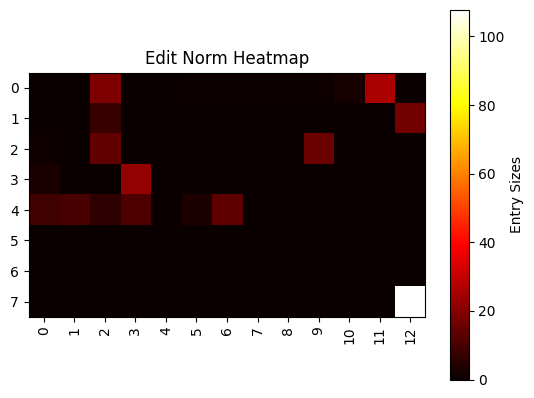

['In', ' a', ' sleek', ' black', ' star', ',', ' she', ' sped']


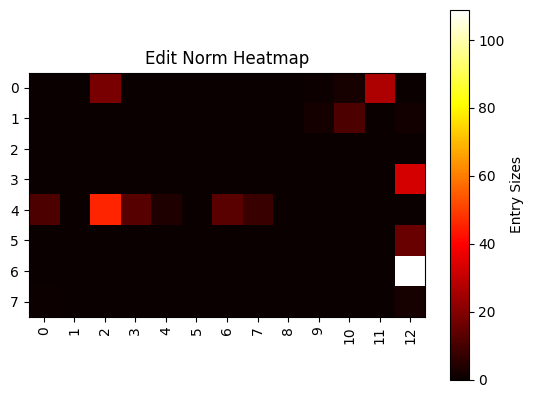

['B', 'ene', 'ath', ' the', ' chair', ',', ' the', ' stars']


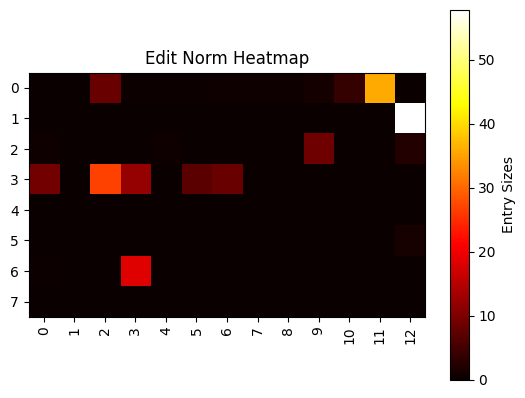

['In', ' a', ' cozy', ' mountain', ' by', ' the', ' lake', ',']


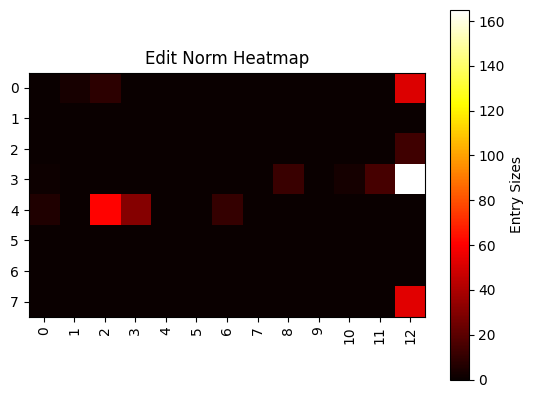

['Down', ' by', ' the', ' winding', ' bicycle', ',', ' she', ' danced']


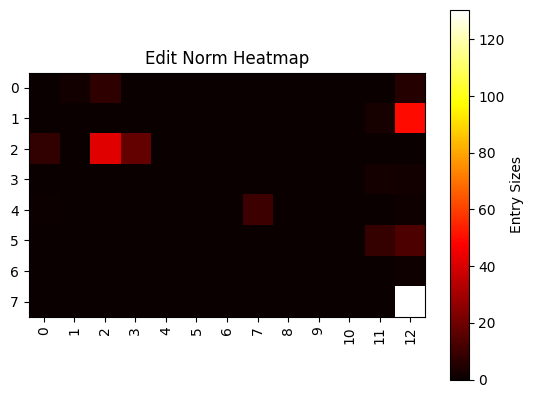

['On', ' the', ' city', ',', ' she', ' whispered', ' her', ' secrets']


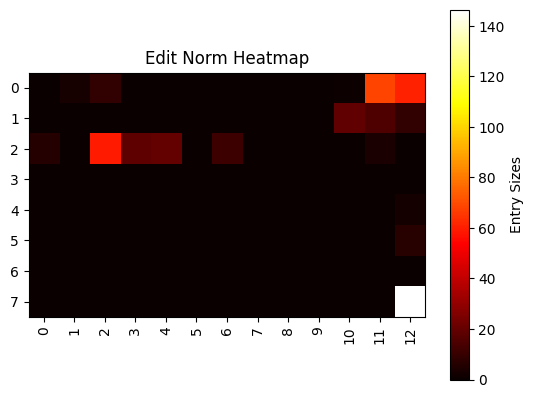

['The', ' loyal', ' bicycle', ' bark', 'ed', ' happily', ' in', ' the']


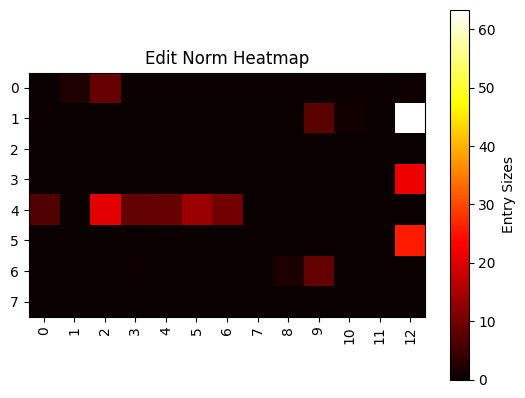

['B', 'ene', 'ath', ' the', ' cat', "'s", ' gentle', ' glow']


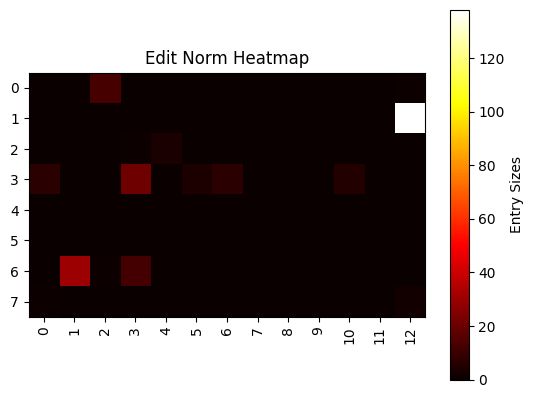

['In', ' the', ' morning', ' sun', ',', ' the', ' ocean', ' happily']


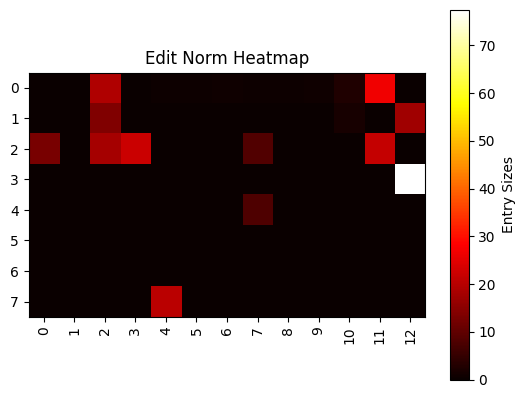

['On', ' the', ' star', ',', ' she', ' shared', ' her', ' dreams']


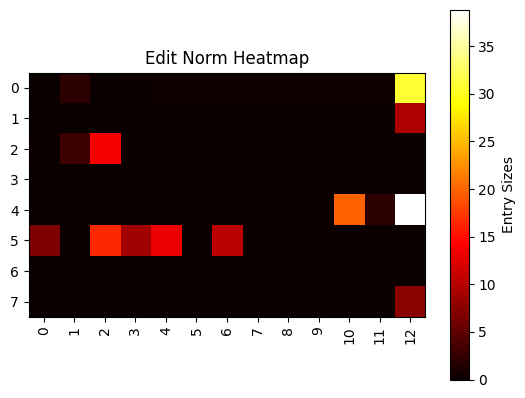

['Upon', ' the', ' vine', ' a', ' lonely', ' cat', ' hung', '.']


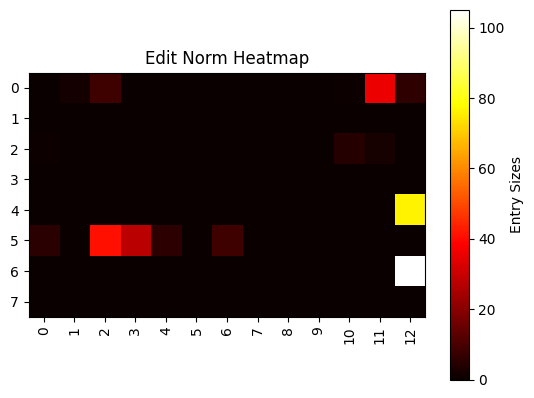

['With', ' a', ' roar', ',', ' the', ' computer', ' sped', ' away']


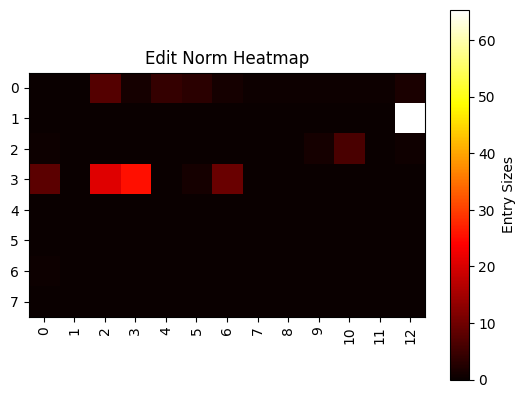

['In', ' the', ' quaint', ' bird', ' by', ' the', ' sea', '.']


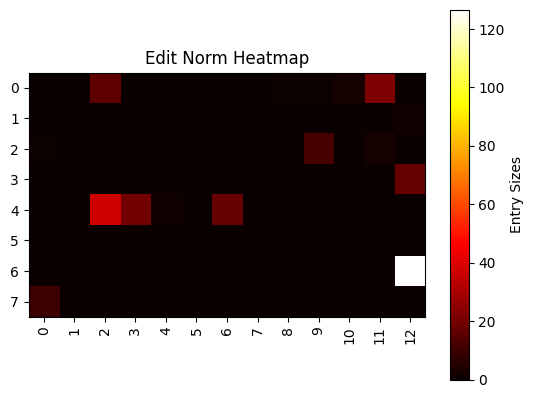

['In', ' a', ' cozy', ' little', ' chair', ' by', ' the', ' sea']


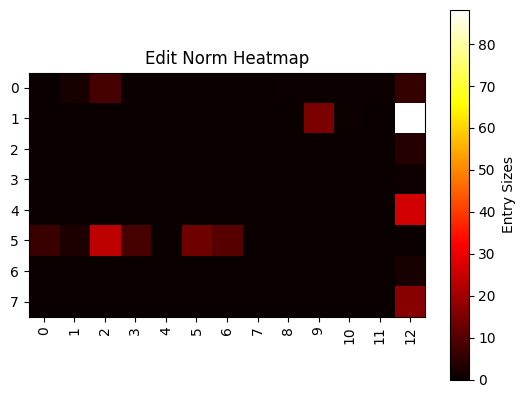

['Fl', 'owing', ' gently', ',', ' the', ' cat', ' reflects', ' the']


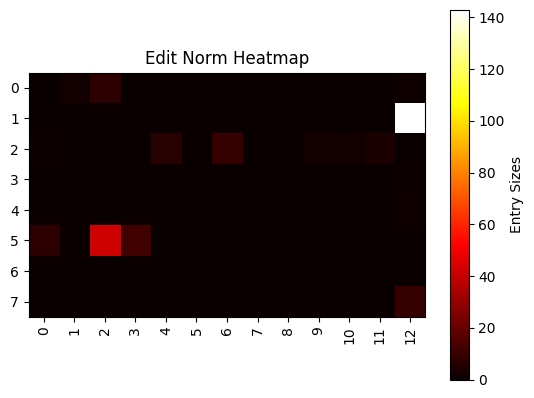

['In', ' a', ' dance', ',', ' the', ' city', ' grace', 'fully']


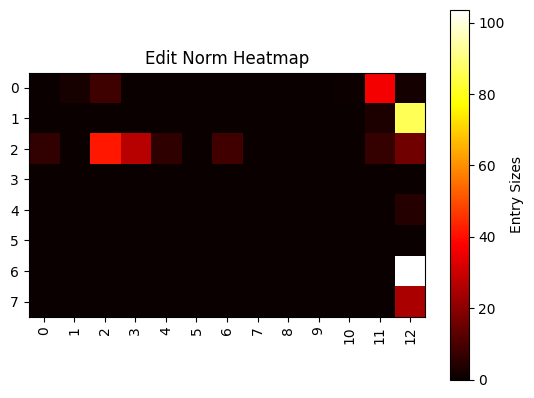

['On', ' the', ' computer', ',', ' we', ' shared', ' secrets', ' until']


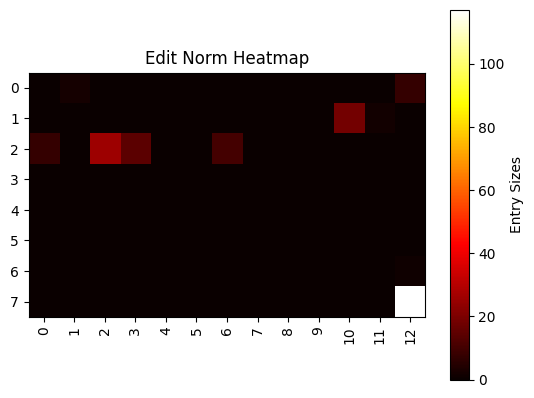

['A', ' loyal', ' cat', ' waits', ' w', 'agging', ' by', ' the']


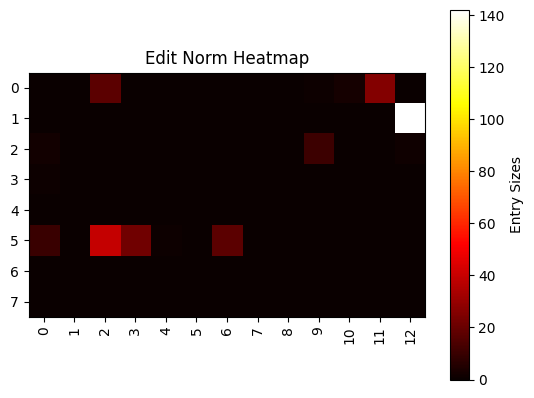

['By', ' the', ' light', ' of', ' the', ' chair', ',', ' she']


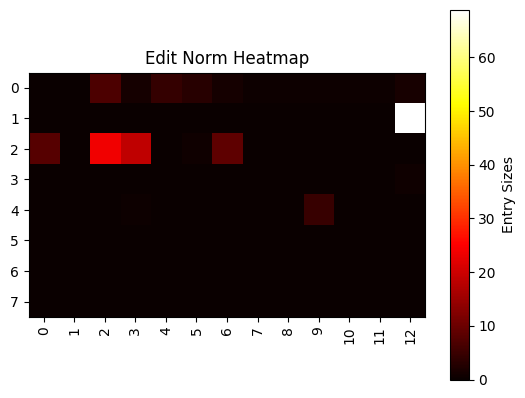

['Under', ' a', ' bird', "'s", ' shade', ',', ' the', ' child']


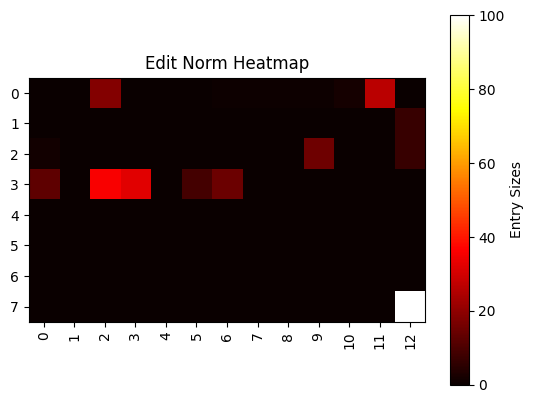

['By', ' the', ' cozy', ' fireplace', ',', ' the', ' star', ' happily']


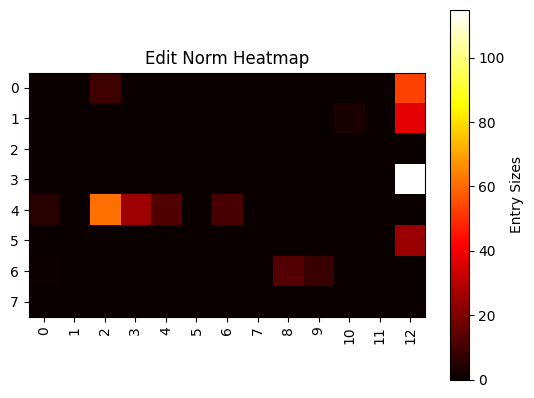

['B', 'ene', 'ath', ' the', ' bicycle', "'s", ' soft', ' glow']


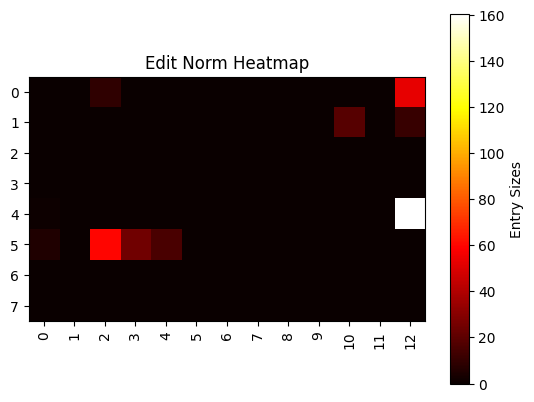

['B', 'ene', 'ath', ' the', ' sprawling', ' bicycle', ',', ' birds']


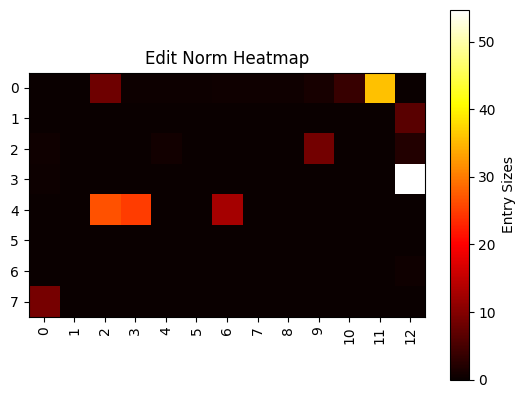

['In', ' a', ' cozy', ' little', ' mountain', ' by', ' the', ' sea']


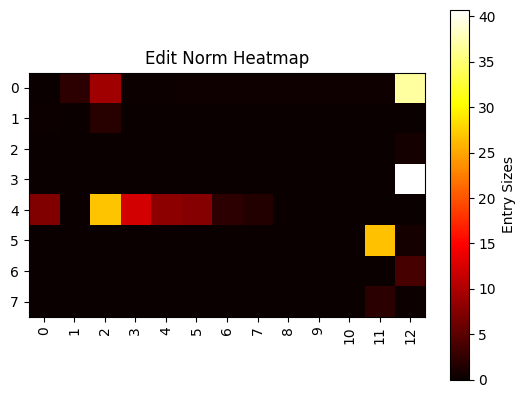

['The', ' ring', ' of', ' the', ' cat', ' broke', ' my', ' silence']


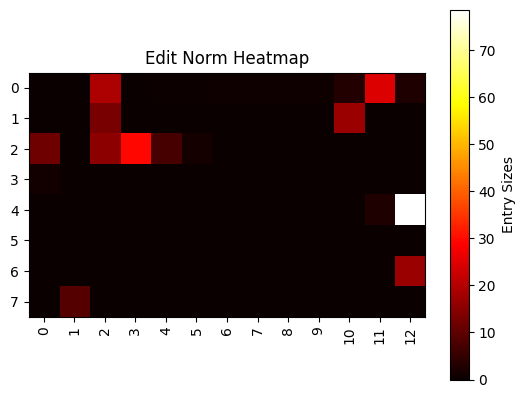

['A', ' loyal', ' star', ' waits', ' patiently', ' for', ' his', ' owner']


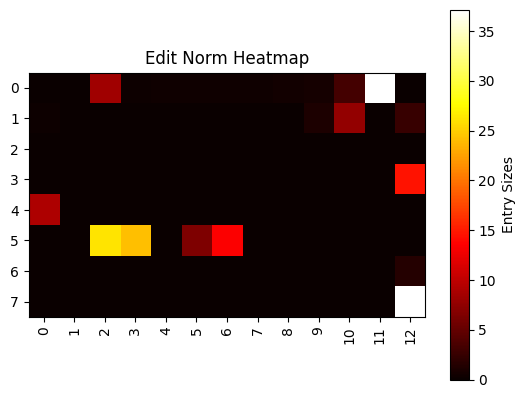

['B', 'ene', 'ath', ' the', ' tall', ' mountain', ',', ' a']


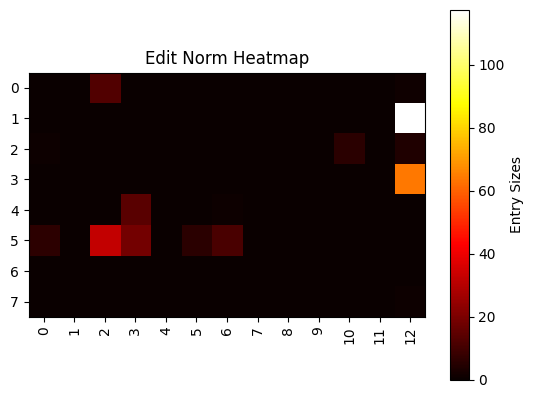

['In', ' the', ' shiny', ' new', ' red', ' ocean', ',', ' they']


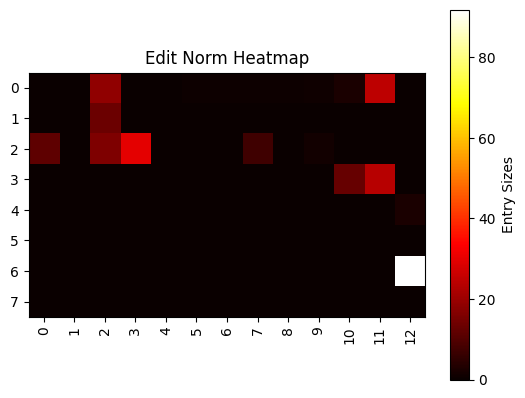

['In', ' my', ' star', ',', ' I', ' found', ' a', ' pe']


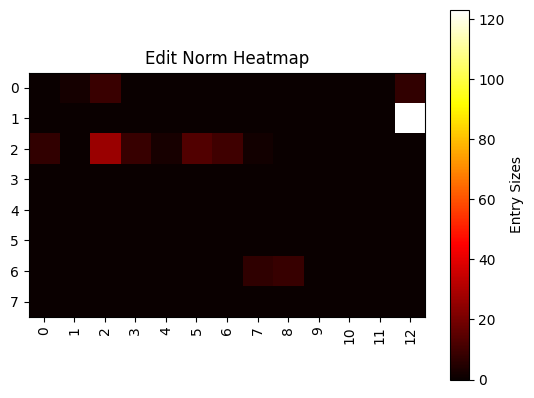

['As', ' the', ' cat', ' rang', ',', ' my', ' heart', ' raced']


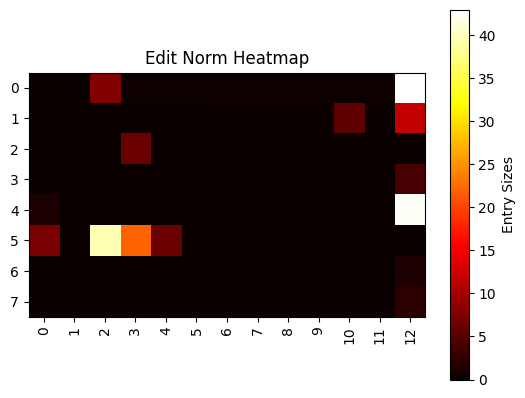

['B', 'ene', 'ath', ' the', ' towering', ' city', ',', ' I']


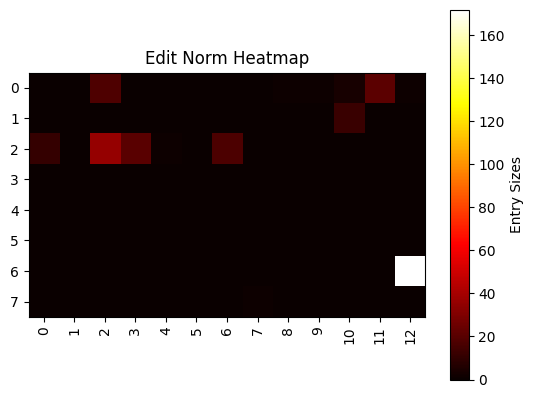

['A', ' loyal', ' chair', ' always', ' stays', ' by', ' your', ' side']


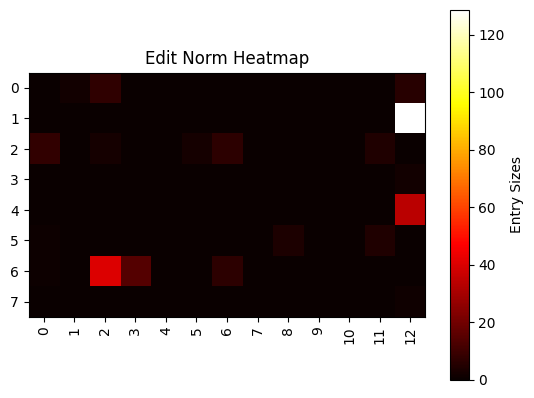

['In', ' the', ' store', ',', ' a', ' shiny', ' city', ' caught']


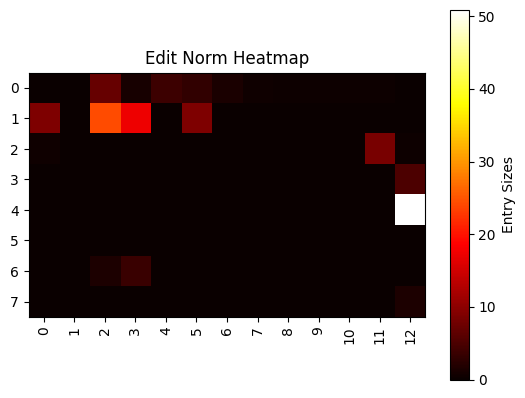

['The', ' bird', ' whispered', ' secrets', ' to', ' the', ' trees', '.']


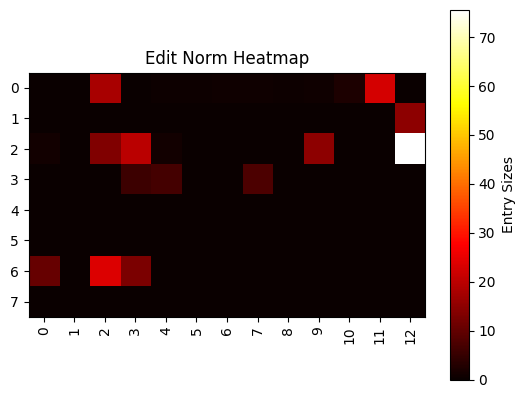

['In', ' the', ' cozy', ' star', ' by', ' the', ' sea', ',']


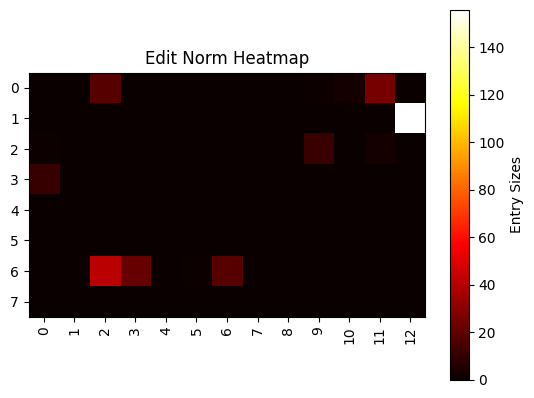

['In', ' the', ' quiet', ' night', ',', ' the', ' chair', ' softly']


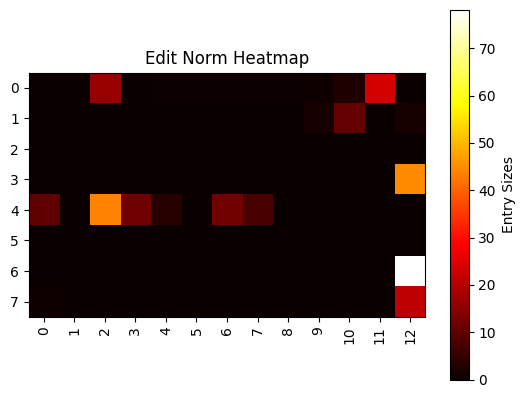

['B', 'ene', 'ath', ' the', ' chair', ',', ' the', ' children']


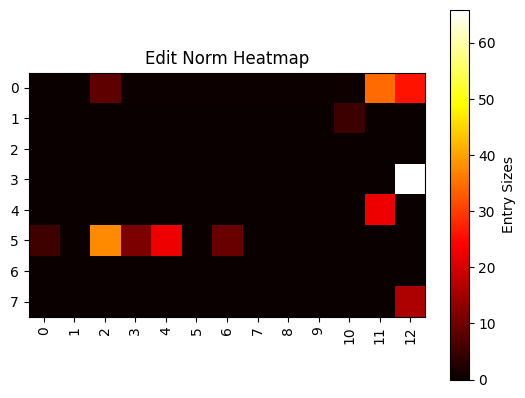

['B', 'ene', 'ath', ' the', ' old', ' computer', ',', ' the']


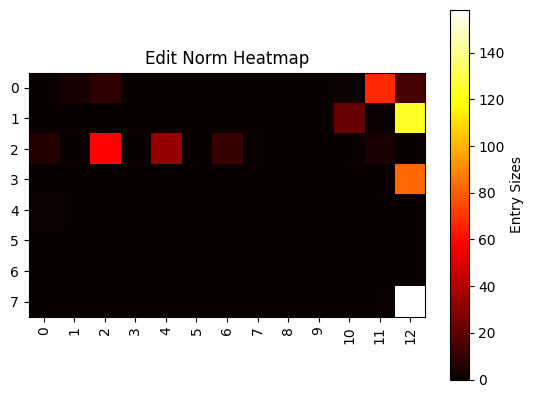

['My', ' loyal', ' bicycle', ' eagerly', ' awaits', ' my', ' return', '.']


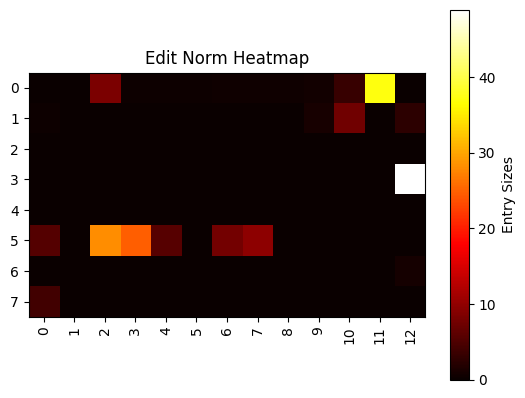

['B', 'ene', 'ath', ' the', ' old', ' mountain', ',', ' birds']


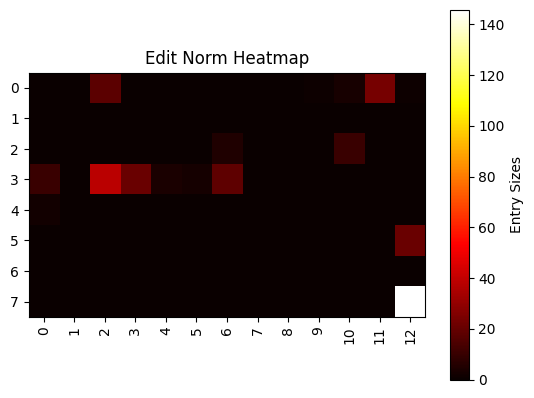

['A', ' shiny', ' red', ' chair', ' zoom', 'ed', ' down', ' the']


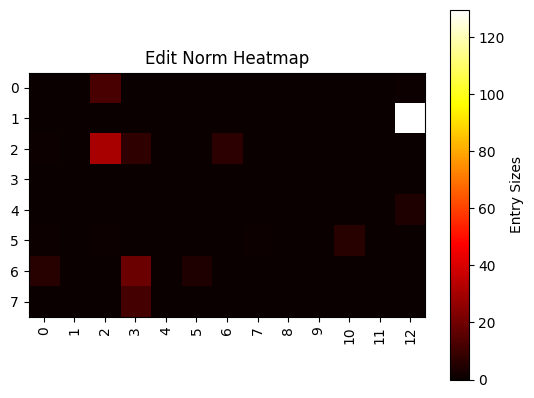

['In', ' the', ' forest', ',', ' a', ' tall', ' ocean', ' stood']


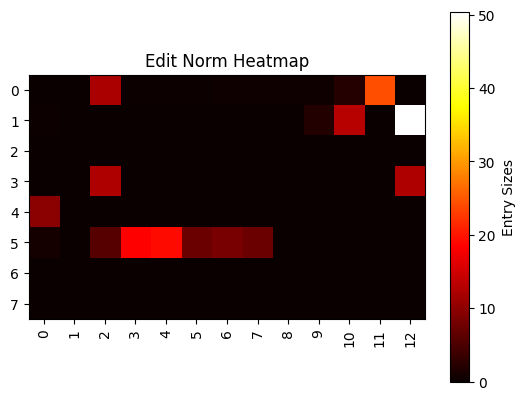

['B', 'ene', 'ath', ' the', ' ancient', ' star', ',', ' wild']


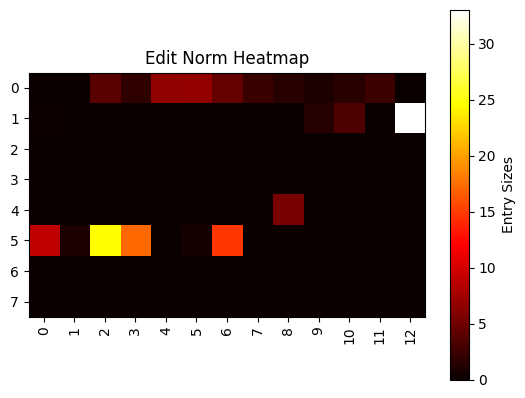

['B', 'ene', 'ath', ' the', ' silver', ' flower', ',', ' the']


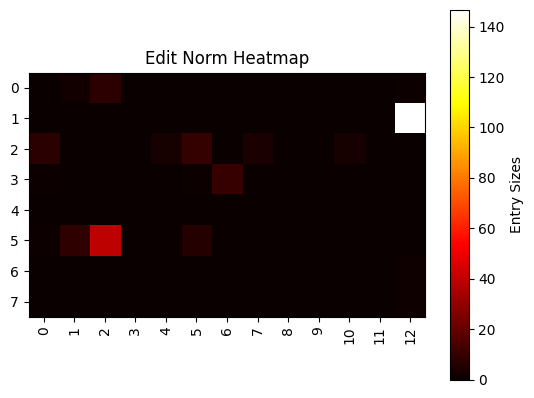

['In', ' a', ' red', ' convertible', ' sports', ' city', ',', ' she']


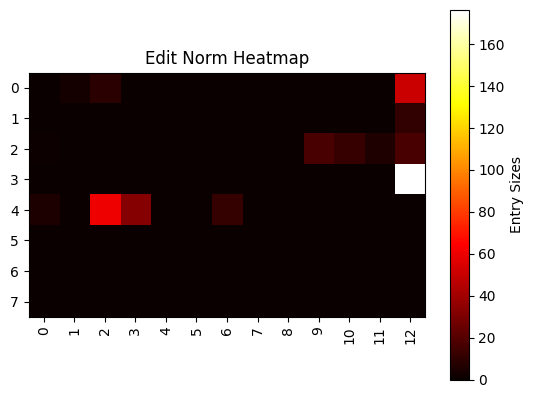

['In', ' the', ' quaint', ' little', ' bicycle', ' by', ' the', ' sea']


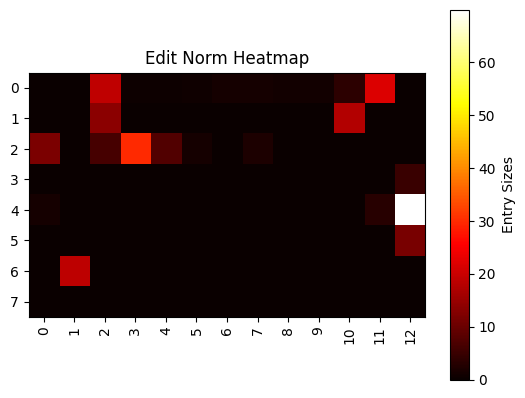

['The', ' loyal', ' star', ' eagerly', ' followed', ' his', ' owner', '.']


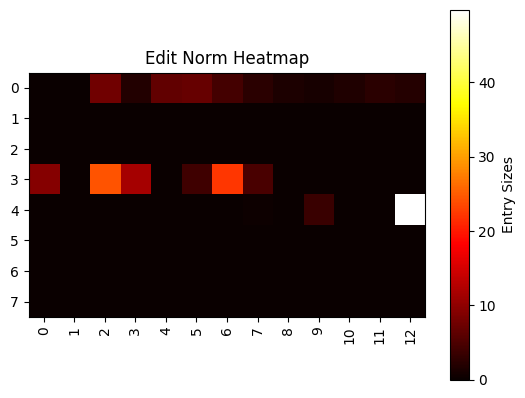

['Bat', 'hed', ' in', ' flower', 'light', ',', ' the', ' night']


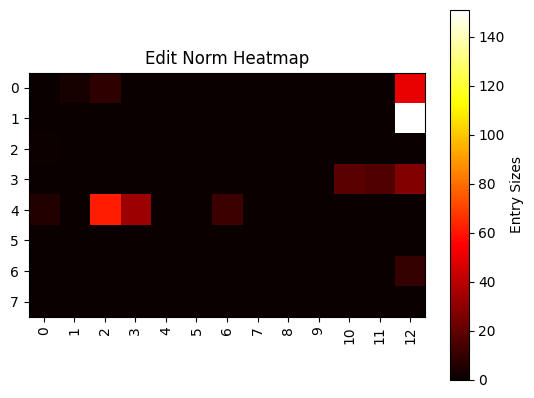

['In', ' the', ' grand', ' old', ' bicycle', ' by', ' the', ' sea']


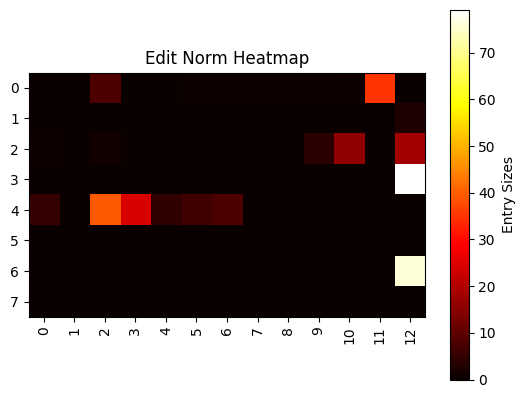

['In', ' the', ' cozy', ' little', ' computer', ' sat', ' a', ' cat']


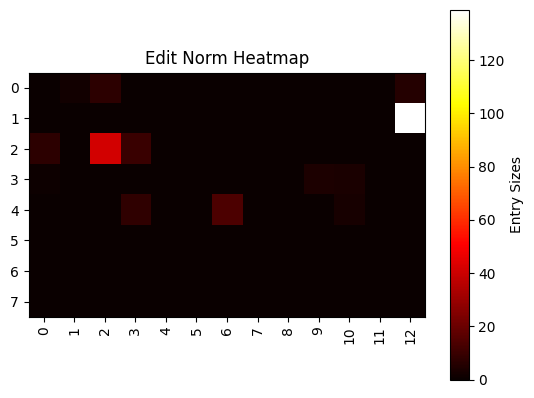

['Under', ' the', ' city', 'lit', ' sky', ',', ' love', ' bloss']


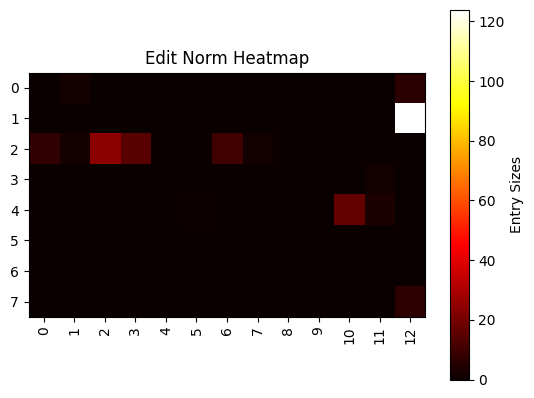

['In', ' a', ' cat', ' of', ' blue', ',', ' we', ' traveled']


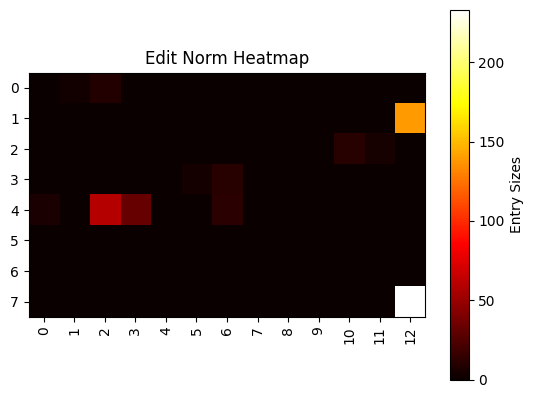

['In', ' a', ' shiny', ' red', ' bicycle', ',', ' we', ' sped']


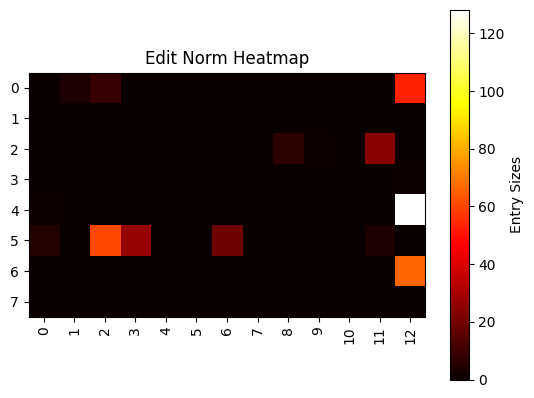

['Sl', 'ip', ' on', ' your', ' favorite', ' bicycle', ' and', ' dance']


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
for batch_index in range(len(batch["target_tokens"])):

    #The tensor norm comes in an 8x13 matrix
    edit_tensor = result["edit_vectors"][batch_index].to("cpu")
    edit_tensor_norm = edit_tensor.norm(dim=2)

    # is this any better??
    # attention_matrix = result['editor_attention'][batch_index].reshape(104).to("cpu").reshape(13,8).permute(1,0)

    # Detach and convert to numpy
    edit_tensor_norm = edit_tensor_norm.detach().numpy()[0:stopping_index, :]

    # Create the heatmap
    fig, ax = plt.subplots()
    heatmap = ax.imshow(edit_tensor_norm, cmap="hot")

    # Color the heatmap according to the entry sizes
    heatmap.set_clim(vmin=np.min(0), vmax=np.max(edit_tensor_norm))
    cbar = plt.colorbar(heatmap)
    cbar.set_label("Entry Sizes")

    # Add labels to the x and y axes
    ax.set_xticks(np.arange(13))
    ax.set_yticks(np.arange(8))
    ax.set_xticklabels(np.arange(13))
    ax.set_yticklabels(np.arange(8))

    # Rotate the x-axis labels
    plt.xticks(rotation=90)

    # Add a title
    plt.title("Edit Norm Heatmap")

    # Show the plot
    plt.show()

    print(tokenizer.batch_decode(batch["result_text"][batch_index][0:8]))

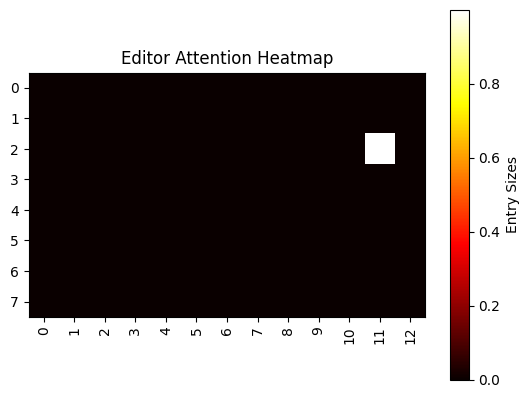

['In', ' a', ' shiny', ' city', ' box', ',', ' new', ' possibilities', ' are', ' being', ' explored', '.', '\n', '\n', 'The', ' city', ' of', ' San', ' Francisco', ' is', ' home', ' to', ' the']


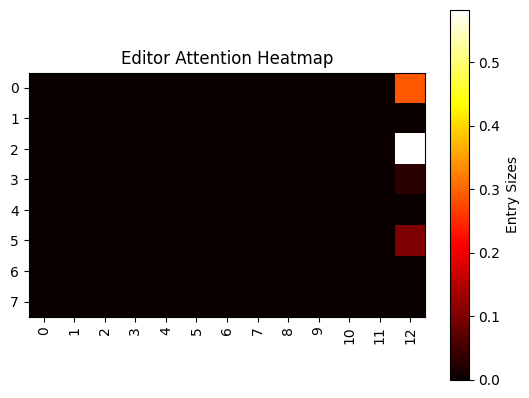

['The', ' flower', ' flowed', ' gently', ' through', ' the', ' valley', '.', '\n', '\n', '"', 'I', "'m", ' not', ' sure', ' if', ' it', "'s", ' a', ' flower', ' or', ' not', ',']


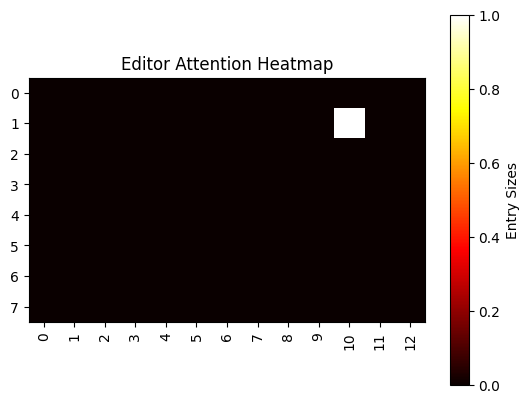

['B', 'ene', 'ath', ' the', ' computer', ',', ' the', ' children', ' are', ' still', ' in', ' the', ' same', ' room', '.', '\n', '\n', '"', 'I', "'m", ' not', ' sure', ' if']


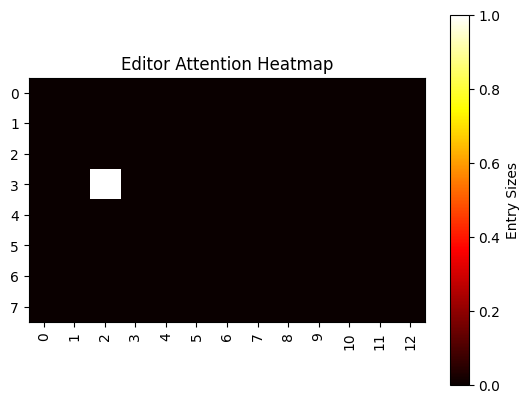

['In', ' a', ' shiny', ' city', ' box', ',', ' new', ' possibilities', ' are', ' being', ' explored', '.', '\n', '\n', 'The', ' city', ' of', ' San', ' Francisco', ' is', ' home', ' to', ' the']


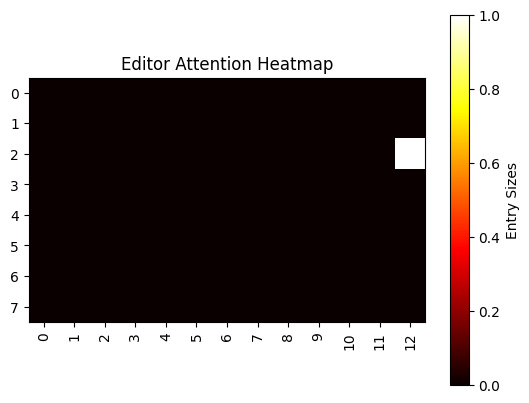

['The', ' flower', ' flowed', ' gently', ' through', ' the', ' valley', '.', '\n', '\n', '"', 'I', "'m", ' not', ' sure', ' if', ' it', "'s", ' a', ' flower', ' or', ' not', ',']


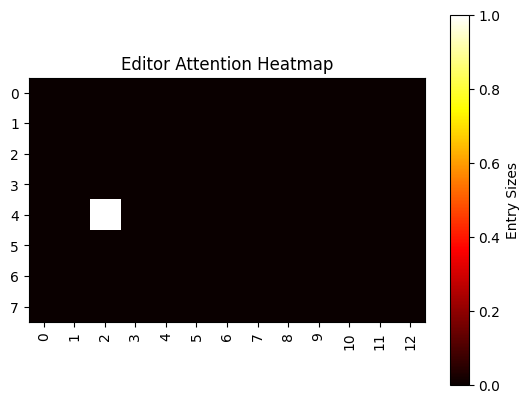

['B', 'ene', 'ath', ' the', ' computer', ',', ' the', ' children', ' are', ' still', ' in', ' the', ' same', ' room', '.', '\n', '\n', '"', 'I', "'m", ' not', ' sure', ' if']


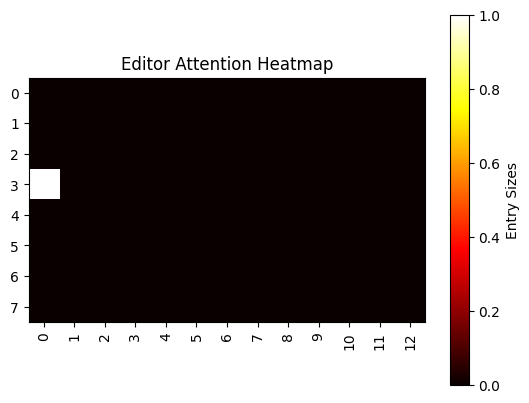

['In', ' a', ' shiny', ' city', ' box', ',', ' new', ' possibilities', ' are', ' being', ' explored', '.', '\n', '\n', 'The', ' city', ' of', ' San', ' Francisco', ' is', ' home', ' to', ' the']


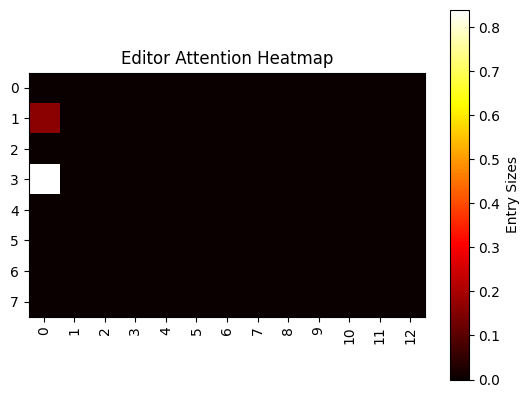

['The', ' flower', ' flowed', ' gently', ' through', ' the', ' valley', '.', '\n', '\n', '"', 'I', "'m", ' not', ' sure', ' if', ' it', "'s", ' a', ' flower', ' or', ' not', ',']


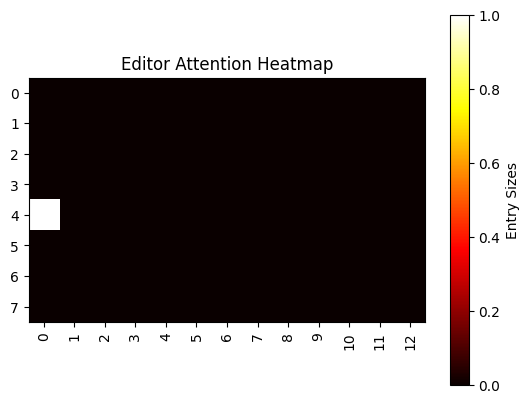

['B', 'ene', 'ath', ' the', ' computer', ',', ' the', ' children', ' are', ' still', ' in', ' the', ' same', ' room', '.', '\n', '\n', '"', 'I', "'m", ' not', ' sure', ' if']


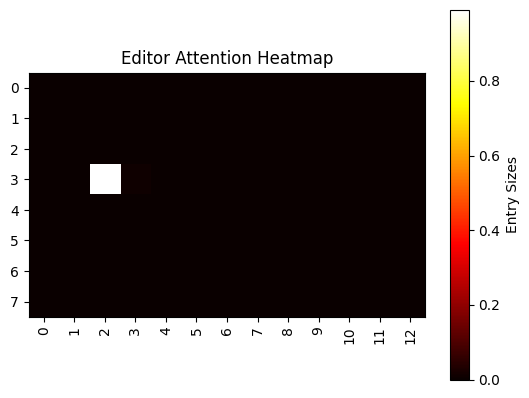

['In', ' a', ' shiny', ' city', ' box', ',', ' new', ' possibilities', ' are', ' being', ' explored', '.', '\n', '\n', 'The', ' city', ' of', ' San', ' Francisco', ' is', ' home', ' to', ' the']


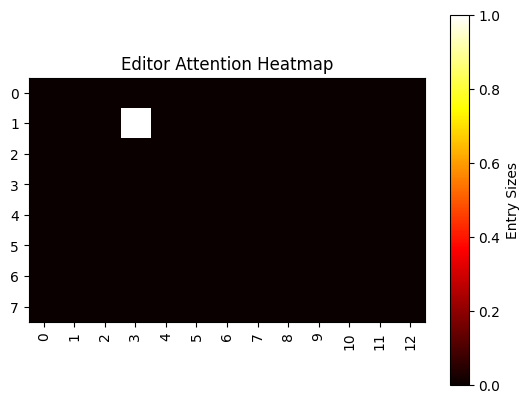

['The', ' flower', ' flowed', ' gently', ' through', ' the', ' valley', '.', '\n', '\n', '"', 'I', "'m", ' not', ' sure', ' if', ' it', "'s", ' a', ' flower', ' or', ' not', ',']


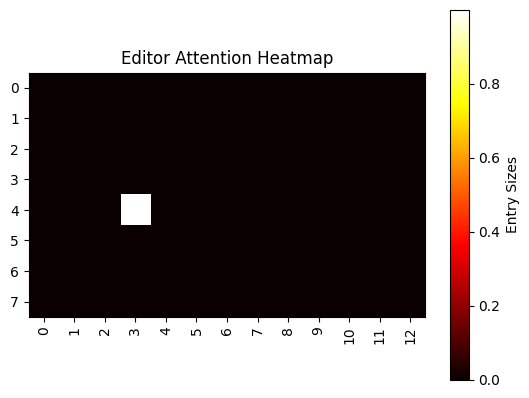

['B', 'ene', 'ath', ' the', ' computer', ',', ' the', ' children', ' are', ' still', ' in', ' the', ' same', ' room', '.', '\n', '\n', '"', 'I', "'m", ' not', ' sure', ' if']


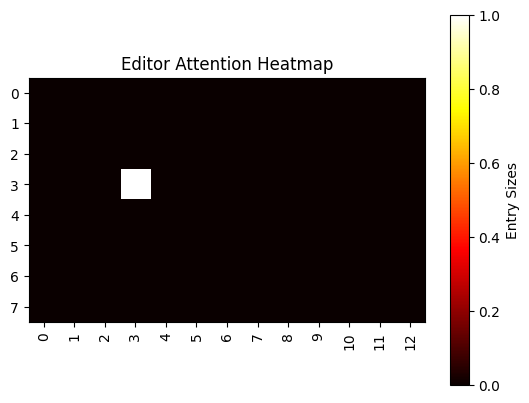

['In', ' a', ' shiny', ' city', ' box', ',', ' new', ' possibilities', ' are', ' being', ' explored', '.', '\n', '\n', 'The', ' city', ' of', ' San', ' Francisco', ' is', ' home', ' to', ' the']


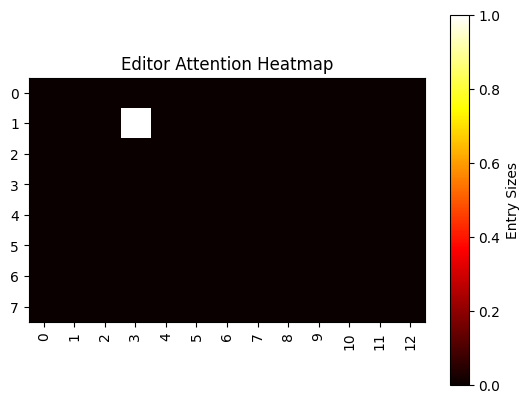

['The', ' flower', ' flowed', ' gently', ' through', ' the', ' valley', '.', '\n', '\n', '"', 'I', "'m", ' not', ' sure', ' if', ' it', "'s", ' a', ' flower', ' or', ' not', ',']


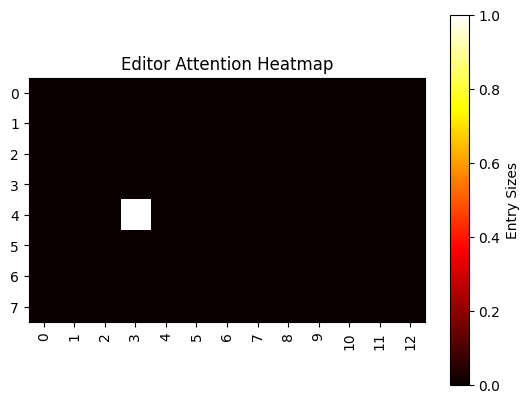

['B', 'ene', 'ath', ' the', ' computer', ',', ' the', ' children', ' are', ' still', ' in', ' the', ' same', ' room', '.', '\n', '\n', '"', 'I', "'m", ' not', ' sure', ' if']


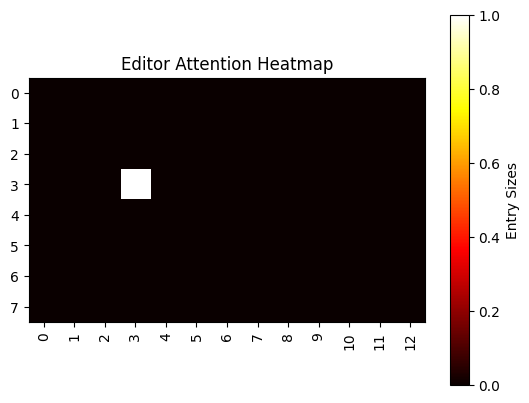

['In', ' a', ' shiny', ' city', ' box', ',', ' new', ' possibilities', ' are', ' being', ' explored', '.', '\n', '\n', 'The', ' city', ' of', ' San', ' Francisco', ' is', ' home', ' to', ' the']


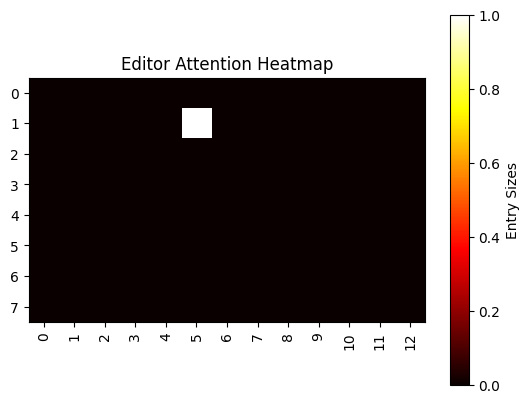

['The', ' flower', ' flowed', ' gently', ' through', ' the', ' valley', '.', '\n', '\n', '"', 'I', "'m", ' not', ' sure', ' if', ' it', "'s", ' a', ' flower', ' or', ' not', ',']


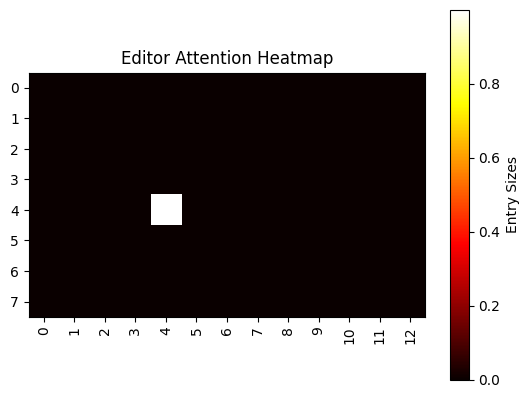

['B', 'ene', 'ath', ' the', ' computer', ',', ' the', ' children', ' are', ' still', ' in', ' the', ' same', ' room', '.', '\n', '\n', '"', 'I', "'m", ' not', ' sure', ' if']


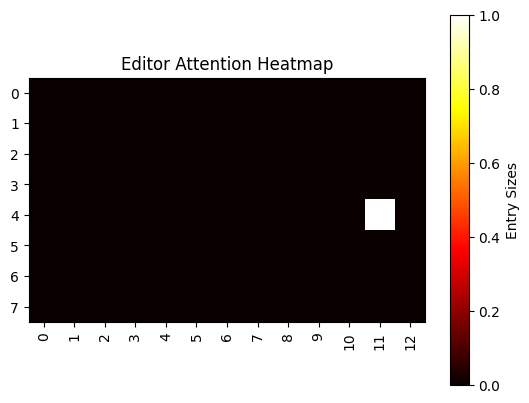

['In', ' a', ' shiny', ' city', ' box', ',', ' new', ' possibilities', ' are', ' being', ' explored', '.', '\n', '\n', 'The', ' city', ' of', ' San', ' Francisco', ' is', ' home', ' to', ' the']


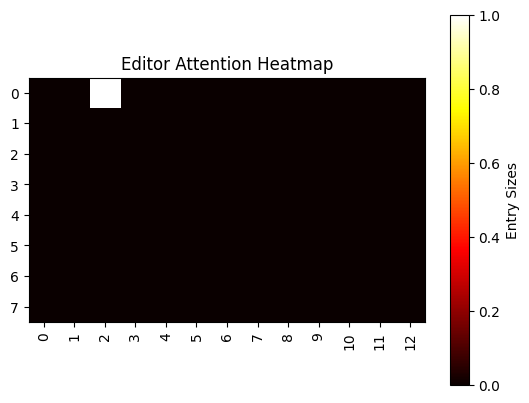

['The', ' flower', ' flowed', ' gently', ' through', ' the', ' valley', '.', '\n', '\n', '"', 'I', "'m", ' not', ' sure', ' if', ' it', "'s", ' a', ' flower', ' or', ' not', ',']


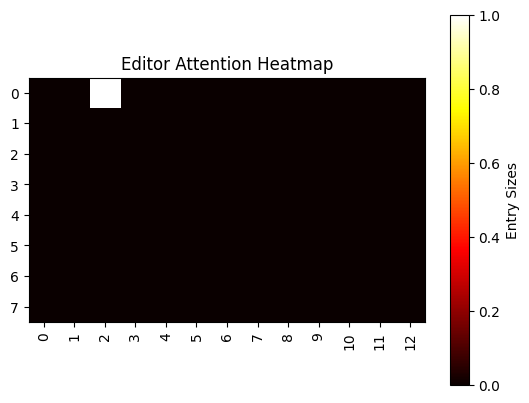

['B', 'ene', 'ath', ' the', ' computer', ',', ' the', ' children', ' are', ' still', ' in', ' the', ' same', ' room', '.', '\n', '\n', '"', 'I', "'m", ' not', ' sure', ' if']


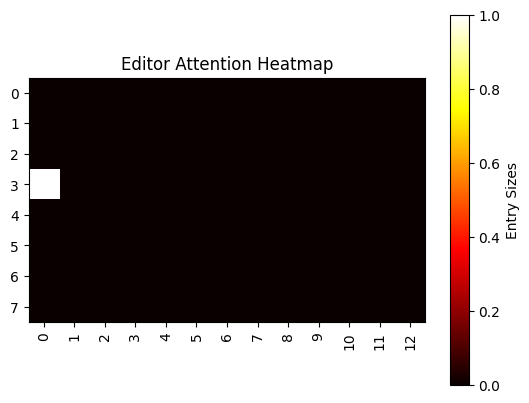

['In', ' a', ' shiny', ' city', ' box', ',', ' new', ' possibilities', ' are', ' being', ' explored', '.', '\n', '\n', 'The', ' city', ' of', ' San', ' Francisco', ' is', ' home', ' to', ' the']


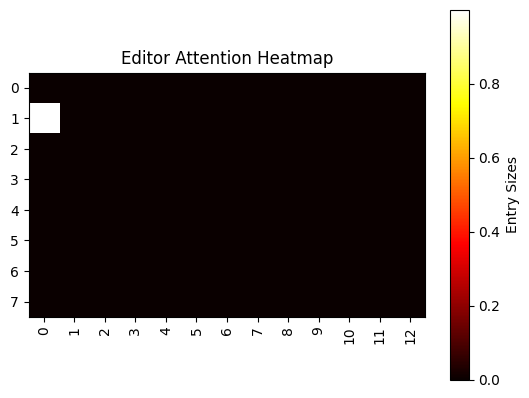

['The', ' flower', ' flowed', ' gently', ' through', ' the', ' valley', '.', '\n', '\n', '"', 'I', "'m", ' not', ' sure', ' if', ' it', "'s", ' a', ' flower', ' or', ' not', ',']


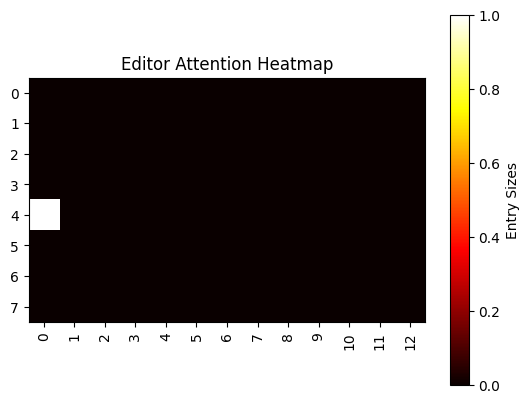

['B', 'ene', 'ath', ' the', ' computer', ',', ' the', ' children', ' are', ' still', ' in', ' the', ' same', ' room', '.', '\n', '\n', '"', 'I', "'m", ' not', ' sure', ' if']


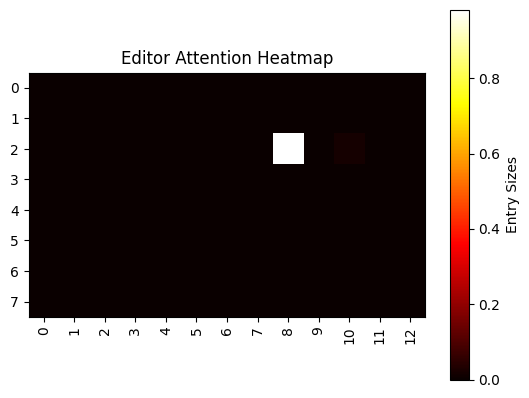

['In', ' a', ' shiny', ' city', ' box', ',', ' new', ' possibilities', ' are', ' being', ' explored', '.', '\n', '\n', 'The', ' city', ' of', ' San', ' Francisco', ' is', ' home', ' to', ' the']


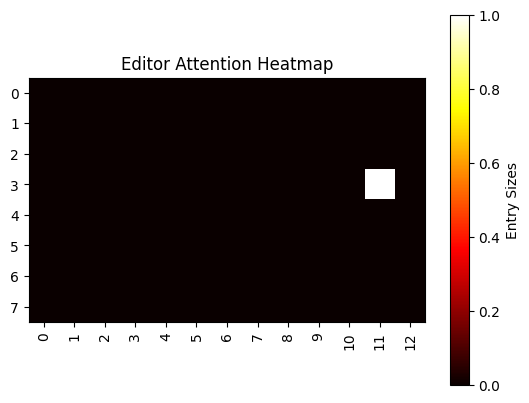

['The', ' flower', ' flowed', ' gently', ' through', ' the', ' valley', '.', '\n', '\n', '"', 'I', "'m", ' not', ' sure', ' if', ' it', "'s", ' a', ' flower', ' or', ' not', ',']


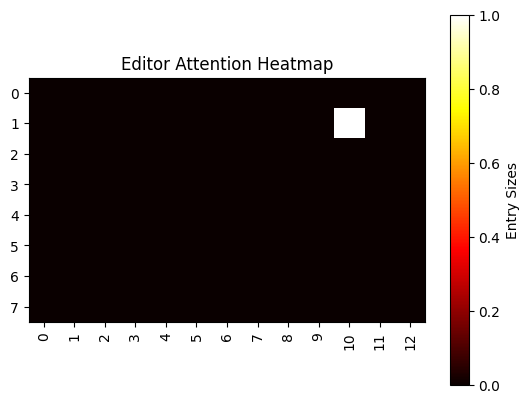

['B', 'ene', 'ath', ' the', ' computer', ',', ' the', ' children', ' are', ' still', ' in', ' the', ' same', ' room', '.', '\n', '\n', '"', 'I', "'m", ' not', ' sure', ' if']


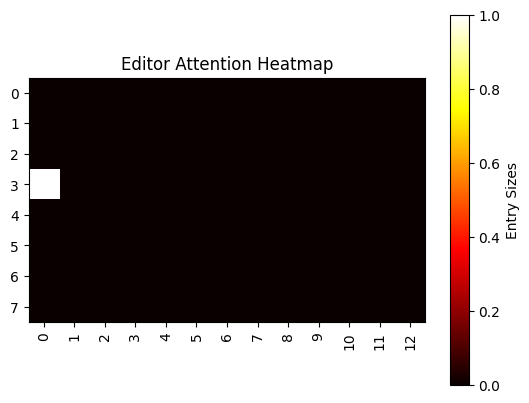

['In', ' a', ' shiny', ' city', ' box', ',', ' new', ' possibilities', ' are', ' being', ' explored', '.', '\n', '\n', 'The', ' city', ' of', ' San', ' Francisco', ' is', ' home', ' to', ' the']


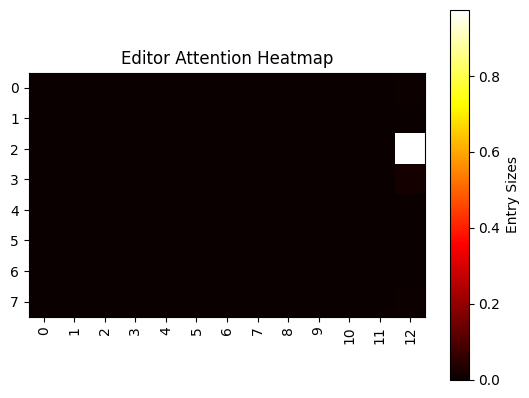

['The', ' flower', ' flowed', ' gently', ' through', ' the', ' valley', '.', '\n', '\n', '"', 'I', "'m", ' not', ' sure', ' if', ' it', "'s", ' a', ' flower', ' or', ' not', ',']


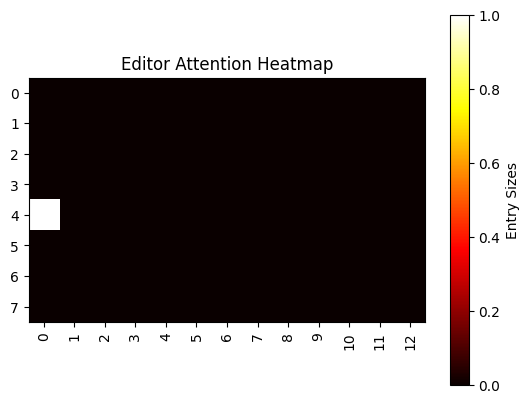

['B', 'ene', 'ath', ' the', ' computer', ',', ' the', ' children', ' are', ' still', ' in', ' the', ' same', ' room', '.', '\n', '\n', '"', 'I', "'m", ' not', ' sure', ' if']


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
stopping_index = 8

for head_index in range(min(hypernetwork.editor_model.config.num_editing_heads,10)):
    for batch_index in range(3):

        # Reshape the tensor into an 8x13 matrix
        attention_matrix = result["editor_attention"][batch_index][head_index].reshape(8, 13).to("cpu")

        # is this any better??
        # attention_matrix = result['editor_attention'][batch_index].reshape(104).to("cpu").reshape(13,8).permute(1,0)

        # Detach and convert to numpy
        attention_matrix = attention_matrix.detach().numpy()

        # Create the heatmap
        fig, ax = plt.subplots()
        heatmap = ax.imshow(attention_matrix, cmap="hot")

        # Color the heatmap according to the entry sizes
        heatmap.set_clim(vmin=np.min(attention_matrix), vmax=np.max(attention_matrix))
        cbar = plt.colorbar(heatmap)
        cbar.set_label("Entry Sizes")

        # Add labels to the x and y axes
        ax.set_xticks(np.arange(13))
        ax.set_yticks(np.arange(8))
        ax.set_xticklabels(np.arange(13))
        ax.set_yticklabels(np.arange(8))

        # Rotate the x-axis labels
        plt.xticks(rotation=90)

        # Add a title
        plt.title("Editor Attention Heatmap")

        # Show the plot
        plt.show()


        print(tokenizer.batch_decode(batch["result_text"][batch_index]))

In [ ]:
# torch.norm(
#     result["edit_vectors"][batch_index][:stopping_index, :, :].to("cpu"), dim=[0, 2]
# )  # looks better now!

Notes: It seems, currently, like we are not giving sufficient incentive to intervene at the lowest possible layer

In [ ]:
result["edit_vectors"].shape

torch.Size([160, 23, 13, 768])

In [ ]:
edit_tensor = result["edit_vectors"][batch_index].reshape(8, 13, -1).to("cpu")
edit_tensor_norm = edit_tensor.norm(dim=2)
edit_tensor_norm.shape

torch.Size([8, 13])

In [ ]:
edited_states = torch.stack(result['edited_hidden_states'],dim = 2)
edited_states.shape

torch.Size([160, 23, 13, 768])

In [ ]:
for i in range(8):
    print(edited_states[0][i][0].norm())

tensor(10.1000, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(5.7675, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(5.8729, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(10.8826, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(5.3322, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(5.1028, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(5.0002, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(5.3511, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


In [ ]:
# # Some basic checks of embedding norms 

# # Access the embedding layer
# embeddings = model.get_input_embeddings()

# # Get the weight matrix of the embeddings
# embedding_weights = embeddings.weight

# # Calculate the L2 norm for each embedding vector
# norms = torch.norm(embedding_weights, p=2, dim=1)

# # Iterate over each token in the tokenizer to display its norm
# token_norms = {}
# for token, index in tokenizer.get_vocab().items():
#     token_norms[token] = norms[index].item()

# # Example output for a few tokens
# # for token, norm in list(token_norms.items())[:100]:  # Displaying the first 10 for brevity
# #     print(f"Token: {token}, Norm: {norm}")

# print(embedding_weights.shape)

# print(token_norms)

# #plt.hist(list(token_norms.values()), bins=100)

# # Access the positional embedding layer
# positional_embeddings = model.transformer.wpe.weight  # For GPT-2, positional embeddings are accessed via `wpe` attribute

# print(positional_embeddings.shape)

# # Calculate the L2 norm for each positional embedding vector
# positional_norms = torch.norm(positional_embeddings, p=2, dim=1)

# print(torch.min(positional_norms), torch.max(positional_norms))

# # Print the norms of the first few positional embeddings
# for position, norm in enumerate(positional_norms[:10]):  # Displaying the first 10 for brevity
#     plt.hist(list(positional_norms.to('cpu').detach().numpy()), bins=100)


In [ ]:
print(
    torch.norm(result['target_hidden_states'][0][6][0]),
    torch.norm(result['target_hidden_states'][0][0][0]),
    edited_states[0][6][0].norm(),
    edited_states[0][2][0].norm()
)


tensor(5.0002, device='cuda:0') tensor(10.1001, device='cuda:0') tensor(5.0002, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>) tensor(5.8729, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


In [ ]:
# tempdata = torch.tensor(dataset['edit_result_ids'][0:1])
# tempdata[:, :stop_editing_index][tempdata[:, :stop_editing_index] == 3797] = 3290
# with torch.no_grad():
#     logits = model(tempdata).logits
#     predictions = torch.nn.functional.softmax(logits, dim=2)
#     temp_output = predictions[:, stop_editing_index:, :].reshape(-1, 50257)
# error = temp_output - nn.functional.softmax(test_output['logits'],dim=2)[0,stop_editing_index:,:]
# torch.max(error)

In [ ]:
# torch.save(hypernetwork.state_dict(), "/root/aiplay-1/hypernetworks/hypernetwork.pth")